##### Copyright 2019 The TensorFlow Authors.

In [1]:
#@title Licensed under the Apache License, Version 2.0 (the "License");
# you may not use this file except in compliance with the License.
# You may obtain a copy of the License at
#
# https://www.apache.org/licenses/LICENSE-2.0
#
# Unless required by applicable law or agreed to in writing, software
# distributed under the License is distributed on an "AS IS" BASIS,
# WITHOUT WARRANTIES OR CONDITIONS OF ANY KIND, either express or implied.
# See the License for the specific language governing permissions and
# limitations under the License.

# Time series forecasting

<table class="tfo-notebook-buttons" align="left">
  <td>
    <a target="_blank" href="https://www.tensorflow.org/tutorials/structured_data/time_series"><img src="https://www.tensorflow.org/images/tf_logo_32px.png" />View on TensorFlow.org</a>
  </td>
  <td>
    <a target="_blank" href="https://colab.research.google.com/github/tensorflow/docs/blob/master/site/en/tutorials/structured_data/time_series.ipynb"><img src="https://www.tensorflow.org/images/colab_logo_32px.png" />Run in Google Colab</a>
  </td>
  <td>
    <a target="_blank" href="https://github.com/tensorflow/docs/blob/master/site/en/tutorials/structured_data/time_series.ipynb"><img src="https://www.tensorflow.org/images/GitHub-Mark-32px.png" />View source on GitHub</a>
  </td>
  <td>
    <a href="https://storage.googleapis.com/tensorflow_docs/docs/site/en/tutorials/structured_data/time_series.ipynb"><img src="https://www.tensorflow.org/images/download_logo_32px.png" />Download notebook</a>
  </td>
</table>

This tutorial is an introduction to time series forecasting using TensorFlow. It builds a few different styles of models including Convolutional and Recurrent Neural Networks (CNNs and RNNs).

This is covered in two main parts, with subsections: 

* Forecast for a single time step:
  * A single feature.
  * All features.
* Forecast multiple steps:
  * Single-shot: Make the predictions all at once.
  * Autoregressive: Make one prediction at a time and feed the output back to the model.

## Setup

In [2]:
import os
import datetime

import IPython
import IPython.display
import matplotlib as mpl
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
import tensorflow as tf

mpl.rcParams['figure.figsize'] = (8, 6)
mpl.rcParams['axes.grid'] = False

## The weather dataset

This tutorial uses a <a href="https://www.bgc-jena.mpg.de/wetter/" class="external">weather time series dataset</a> recorded by the <a href="https://www.bgc-jena.mpg.de" class="external">Max Planck Institute for Biogeochemistry</a>.

This dataset contains 14 different features such as air temperature, atmospheric pressure, and humidity. These were collected every 10 minutes, beginning in 2003. For efficiency, you will use only the data collected between 2009 and 2016. This section of the dataset was prepared by François Chollet for his book <a href="https://www.manning.com/books/deep-learning-with-python" class="external">Deep Learning with Python</a>.

In [3]:
zip_path = tf.keras.utils.get_file(
    origin='https://storage.googleapis.com/tensorflow/tf-keras-datasets/jena_climate_2009_2016.csv.zip',
    fname='jena_climate_2009_2016.csv.zip',
    extract=True)
csv_path, _ = os.path.splitext(zip_path)

13568290/13568290 [==============================] - 1s 0us/step


 5103616/13568290 [==========>...................] - ETA: 0s

 8396800/13568290 [=================>............] - ETA: 0s

13568290/13568290 [==============================] - 0s 0us/step


This tutorial will just deal with **hourly predictions**, so start by sub-sampling the data from 10-minute intervals to one-hour intervals:

In [4]:
df = pd.read_csv(csv_path)
# Slice [start:stop:step], starting from index 5 take every 6th record.
df = df[5::6]

date_time = pd.to_datetime(df.pop('Date Time'), format='%d.%m.%Y %H:%M:%S')

Let's take a glance at the data. Here are the first few rows:

In [5]:
df.head()

,p (mbar),T (degC),Tpot (K),Tdew (degC),rh (%),VPmax (mbar),VPact (mbar),VPdef (mbar),sh (g/kg),H2OC (mmol/mol),rho (g/m**3),wv (m/s),max. wv (m/s),wd (deg)
5,996.50,-8.05,265.38,-8.78,94.4,3.33,3.14,0.19,1.96,3.15,1307.86,0.21,0.63,192.7
11,996.62,-8.88,264.54,-9.77,93.2,3.12,2.90,0.21,1.81,2.91,1312.25,0.25,0.63,190.3
17,996.84,-8.81,264.59,-9.66,93.5,3.13,2.93,0.20,1.83,2.94,1312.18,0.18,0.63,167.2
23,996.99,-9.05,264.34,-10.02,92.6,3.07,2.85,0.23,1.78,2.85,1313.61,0.10,0.38,240.0
29,997.46,-9.63,263.72,-10.65,92.2,2.94,2.71,0.23,1.69,2.71,1317.19,0.40,0.88,157.0


Here is the evolution of a few features over time:

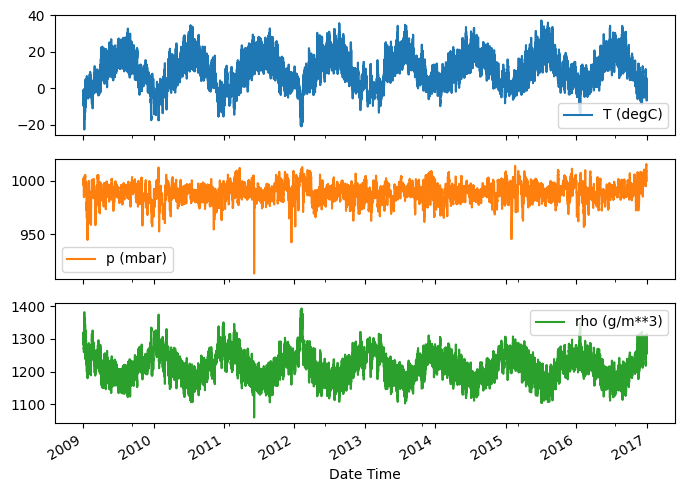

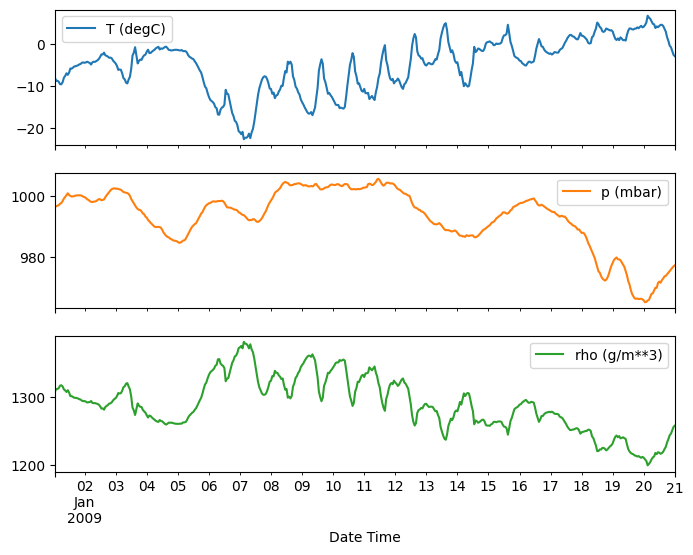

In [6]:
plot_cols = ['T (degC)', 'p (mbar)', 'rho (g/m**3)']
plot_features = df[plot_cols]
plot_features.index = date_time
_ = plot_features.plot(subplots=True)

plot_features = df[plot_cols][:480]
plot_features.index = date_time[:480]
_ = plot_features.plot(subplots=True)

### Inspect and cleanup

Next, look at the statistics of the dataset:

In [7]:
df.describe().transpose()

,count,mean,std,min,25%,50%,75%,max
p (mbar),70091.0,989.212842,8.358886,913.60,984.20,989.57,994.720,1015.29
T (degC),70091.0,9.450482,8.423384,-22.76,3.35,9.41,15.480,37.28
Tpot (K),70091.0,283.493086,8.504424,250.85,277.44,283.46,289.530,311.21
Tdew (degC),70091.0,4.956471,6.730081,-24.80,0.24,5.21,10.080,23.06
rh (%),70091.0,76.009788,16.474920,13.88,65.21,79.30,89.400,100.00
VPmax (mbar),70091.0,13.576576,7.739883,0.97,7.77,11.82,17.610,63.77
VPact (mbar),70091.0,9.533968,4.183658,0.81,6.22,8.86,12.360,28.25
VPdef (mbar),70091.0,4.042536,4.898549,0.00,0.87,2.19,5.300,46.01
sh (g/kg),70091.0,6.022560,2.655812,0.51,3.92,5.59,7.800,18.07
H2OC (mmol/mol),70091.0,9.640437,4.234862,0.81,6.29,8.96,12.490,28.74


#### Wind velocity

One thing that should stand out is the `min` value of the wind velocity (`wv (m/s)`) and the maximum value (`max. wv (m/s)`) columns. This `-9999` is likely erroneous.

There's a separate wind direction column, so the velocity should be greater than zero (`>=0`). Replace it with zeros:

In [8]:
wv = df['wv (m/s)']
bad_wv = wv == -9999.0
wv[bad_wv] = 0.0

max_wv = df['max. wv (m/s)']
bad_max_wv = max_wv == -9999.0
max_wv[bad_max_wv] = 0.0

# The above inplace edits are reflected in the DataFrame.
df['wv (m/s)'].min()

0.0

### Feature engineering

Before diving in to build a model, it's important to understand your data and be sure that you're passing the model appropriately formatted data.

#### Wind
The last column of the data, `wd (deg)`—gives the wind direction in units of degrees. Angles do not make good model inputs: 360° and 0° should be close to each other and wrap around smoothly. Direction shouldn't matter if the wind is not blowing.

Right now the distribution of wind data looks like this:

Text(0, 0.5, 'Wind Velocity [m/s]')

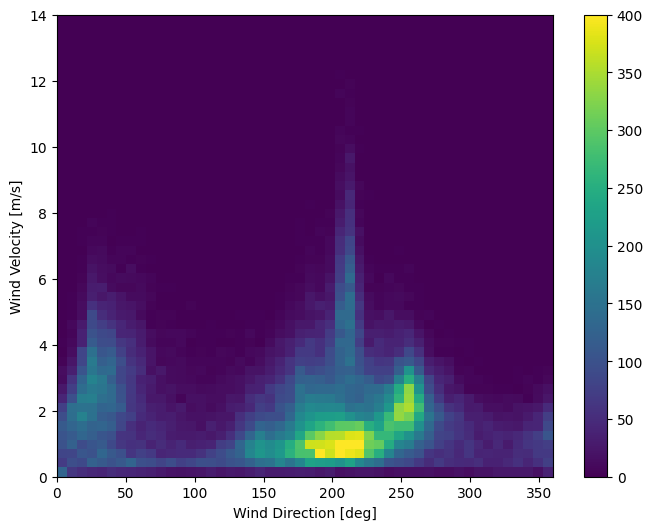

In [9]:
plt.hist2d(df['wd (deg)'], df['wv (m/s)'], bins=(50, 50), vmax=400)
plt.colorbar()
plt.xlabel('Wind Direction [deg]')
plt.ylabel('Wind Velocity [m/s]')

But this will be easier for the model to interpret if you convert the wind direction and velocity columns to a wind **vector**:

In [10]:
wv = df.pop('wv (m/s)')
max_wv = df.pop('max. wv (m/s)')

# Convert to radians.
wd_rad = df.pop('wd (deg)')*np.pi / 180

# Calculate the wind x and y components.
df['Wx'] = wv*np.cos(wd_rad)
df['Wy'] = wv*np.sin(wd_rad)

# Calculate the max wind x and y components.
df['max Wx'] = max_wv*np.cos(wd_rad)
df['max Wy'] = max_wv*np.sin(wd_rad)

The distribution of wind vectors is much simpler for the model to correctly interpret:

(-11.305513973134667, 8.24469928549079, -8.27438540335515, 7.7338312955467785)

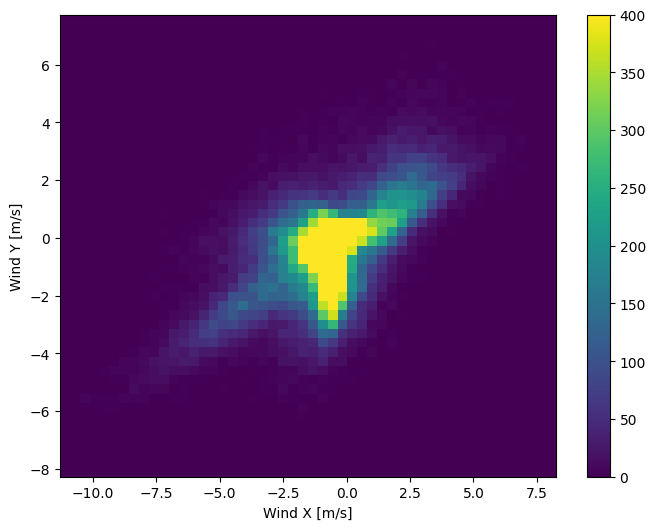

In [11]:
plt.hist2d(df['Wx'], df['Wy'], bins=(50, 50), vmax=400)
plt.colorbar()
plt.xlabel('Wind X [m/s]')
plt.ylabel('Wind Y [m/s]')
ax = plt.gca()
ax.axis('tight')

#### Time

Similarly, the `Date Time` column is very useful, but not in this string form. Start by converting it to seconds:

In [12]:
timestamp_s = date_time.map(pd.Timestamp.timestamp)

Similar to the wind direction, the time in seconds is not a useful model input. Being weather data, it has clear daily and yearly periodicity. There are many ways you could deal with periodicity.

You can get usable signals by using sine and cosine transforms to clear "Time of day" and "Time of year" signals:

In [13]:
day = 24*60*60
year = (365.2425)*day

df['Day sin'] = np.sin(timestamp_s * (2 * np.pi / day))
df['Day cos'] = np.cos(timestamp_s * (2 * np.pi / day))
df['Year sin'] = np.sin(timestamp_s * (2 * np.pi / year))
df['Year cos'] = np.cos(timestamp_s * (2 * np.pi / year))

Text(0.5, 1.0, 'Time of day signal')

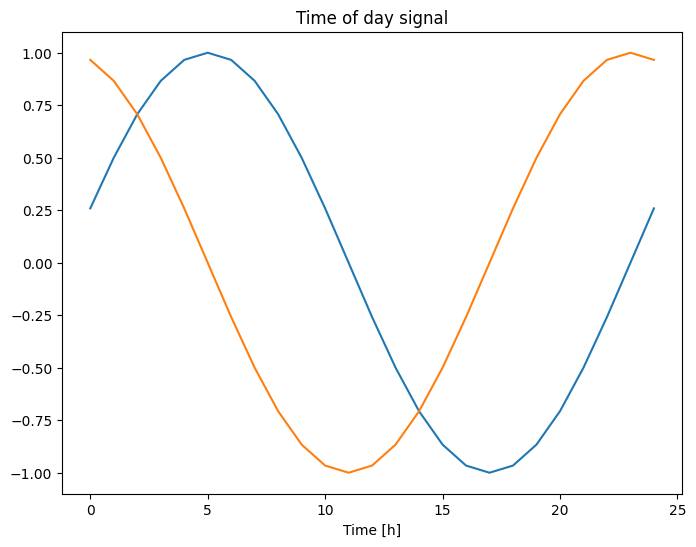

In [14]:
plt.plot(np.array(df['Day sin'])[:25])
plt.plot(np.array(df['Day cos'])[:25])
plt.xlabel('Time [h]')
plt.title('Time of day signal')

This gives the model access to the most important frequency features. In this case you knew ahead of time which frequencies were important. 

If you don't have that information, you can determine which frequencies are important by extracting features with <a href="https://en.wikipedia.org/wiki/Fast_Fourier_transform" class="external">Fast Fourier Transform</a>. To check the assumptions, here is the `tf.signal.rfft` of the temperature over time. Note the obvious peaks at frequencies near `1/year` and `1/day`:


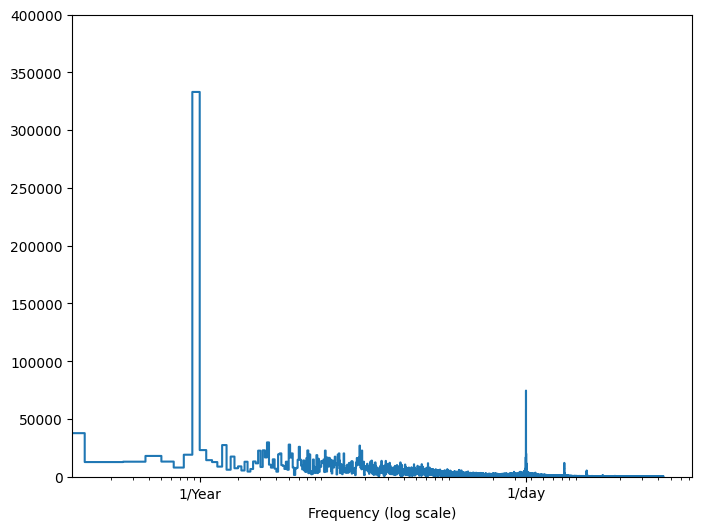

In [15]:
fft = tf.signal.rfft(df['T (degC)'])
f_per_dataset = np.arange(0, len(fft))

n_samples_h = len(df['T (degC)'])
hours_per_year = 24*365.2524
years_per_dataset = n_samples_h/(hours_per_year)

f_per_year = f_per_dataset/years_per_dataset
plt.step(f_per_year, np.abs(fft))
plt.xscale('log')
plt.ylim(0, 400000)
plt.xlim([0.1, max(plt.xlim())])
plt.xticks([1, 365.2524], labels=['1/Year', '1/day'])
_ = plt.xlabel('Frequency (log scale)')

### Split the data

You'll use a `(70%, 20%, 10%)` split for the training, validation, and test sets. Note the data is **not** being randomly shuffled before splitting. This is for two reasons:

1. It ensures that chopping the data into windows of consecutive samples is still possible.
2. It ensures that the validation/test results are more realistic, being evaluated on the data collected after the model was trained.

In [16]:
column_indices = {name: i for i, name in enumerate(df.columns)}

n = len(df)
train_df = df[0:int(n*0.7)]
val_df = df[int(n*0.7):int(n*0.9)]
test_df = df[int(n*0.9):]

num_features = df.shape[1]

### Normalize the data

It is important to scale features before training a neural network. Normalization is a common way of doing this scaling: subtract the mean and divide by the standard deviation of each feature.

The mean and standard deviation should only be computed using the training data so that the models have no access to the values in the validation and test sets.

It's also arguable that the model shouldn't have access to future values in the training set when training, and that this normalization should be done using moving averages. That's not the focus of this tutorial, and the validation and test sets ensure that you get (somewhat) honest metrics. So, in the interest of simplicity this tutorial uses a simple average.

In [17]:
train_mean = train_df.mean()
train_std = train_df.std()

train_df = (train_df - train_mean) / train_std
val_df = (val_df - train_mean) / train_std
test_df = (test_df - train_mean) / train_std

Now, peek at the distribution of the features. Some features do have long tails, but there are no obvious errors like the `-9999` wind velocity value.

/var/folders/ly/qvll8cvj47d6jl_123hgbpdr0000gp/T/ipykernel_81691/3214313372.py:5: UserWarning: FixedFormatter should only be used together with FixedLocator
  _ = ax.set_xticklabels(df.keys(), rotation=90)


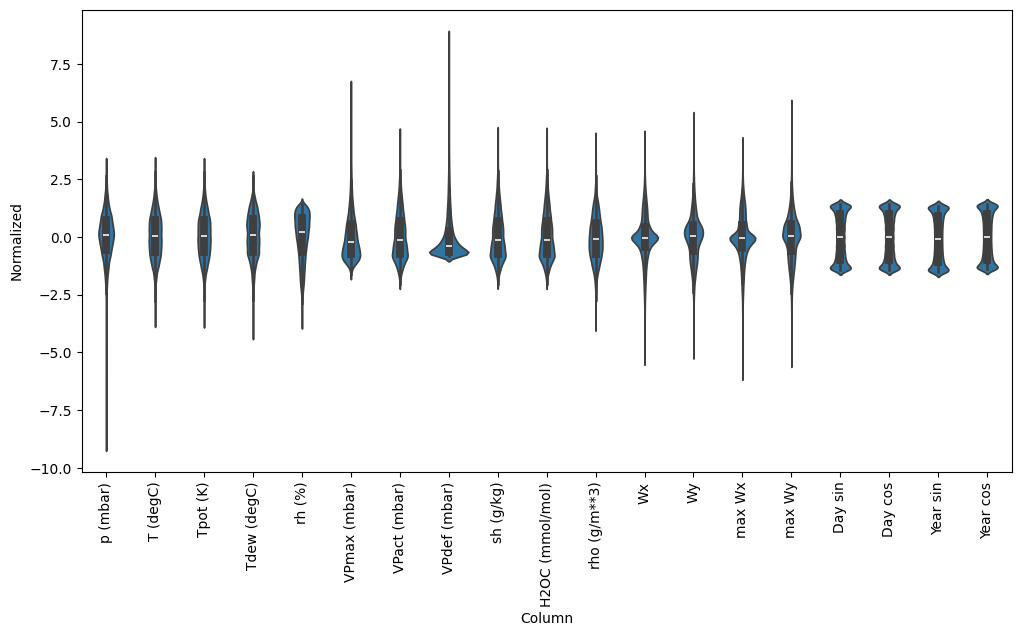

In [18]:
df_std = (df - train_mean) / train_std
df_std = df_std.melt(var_name='Column', value_name='Normalized')
plt.figure(figsize=(12, 6))
ax = sns.violinplot(x='Column', y='Normalized', data=df_std)
_ = ax.set_xticklabels(df.keys(), rotation=90)

## Data windowing

The models in this tutorial will make a set of predictions based on a window of consecutive samples from the data. 

The main features of the input windows are:

- The width (number of time steps) of the input and label windows.
- The time offset between them.
- Which features are used as inputs, labels, or both. 

This tutorial builds a variety of models (including Linear, DNN, CNN and RNN models), and uses them for both:

- *Single-output*, and *multi-output* predictions.
- *Single-time-step* and *multi-time-step* predictions.

This section focuses on implementing the data windowing so that it can be reused for all of those models.


Depending on the task and type of model you may want to generate a variety of data windows. Here are some examples:

1. For example, to make a single prediction 24 hours into the future, given 24 hours of history, you might define a window like this:

  ![One prediction 24 hours into the future.](images/raw_window_24h.png)

2. A model that makes a prediction one hour into the future, given six hours of history, would need a window like this:

  ![One prediction one hour into the future.](images/raw_window_1h.png)

The rest of this section defines a `WindowGenerator` class. This class can:

1. Handle the indexes and offsets as shown in the diagrams above.
1. Split windows of features into `(features, labels)` pairs.
2. Plot the content of the resulting windows.
3. Efficiently generate batches of these windows from the training, evaluation, and test data, using `tf.data.Dataset`s.

### 1. Indexes and offsets

Start by creating the `WindowGenerator` class. The `__init__` method includes all the necessary logic for the input and label indices.

It also takes the training, evaluation, and test DataFrames as input. These will be converted to `tf.data.Dataset`s of windows later.

In [19]:
class WindowGenerator():
  def __init__(self, input_width, label_width, shift,
               train_df=train_df, val_df=val_df, test_df=test_df,
               label_columns=None):
    # Store the raw data.
    self.train_df = train_df
    self.val_df = val_df
    self.test_df = test_df

    # Work out the label column indices.
    self.label_columns = label_columns
    if label_columns is not None:
      self.label_columns_indices = {name: i for i, name in
                                    enumerate(label_columns)}
    self.column_indices = {name: i for i, name in
                           enumerate(train_df.columns)}

    # Work out the window parameters.
    self.input_width = input_width
    self.label_width = label_width
    self.shift = shift

    self.total_window_size = input_width + shift

    self.input_slice = slice(0, input_width)
    self.input_indices = np.arange(self.total_window_size)[self.input_slice]

    self.label_start = self.total_window_size - self.label_width
    self.labels_slice = slice(self.label_start, None)
    self.label_indices = np.arange(self.total_window_size)[self.labels_slice]

  def __repr__(self):
    return '\n'.join([
        f'Total window size: {self.total_window_size}',
        f'Input indices: {self.input_indices}',
        f'Label indices: {self.label_indices}',
        f'Label column name(s): {self.label_columns}'])

Here is code to create the 2 windows shown in the diagrams at the start of this section:

In [20]:
w1 = WindowGenerator(input_width=24, label_width=1, shift=24,
                     label_columns=['T (degC)'])
w1

Total window size: 48
Input indices: [ 0  1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20 21 22 23]
Label indices: [47]
Label column name(s): ['T (degC)']

In [21]:
w2 = WindowGenerator(input_width=6, label_width=1, shift=1,
                     label_columns=['T (degC)'])
w2

Total window size: 7
Input indices: [0 1 2 3 4 5]
Label indices: [6]
Label column name(s): ['T (degC)']

### 2. Split

Given a list of consecutive inputs, the `split_window` method will convert them to a window of inputs and a window of labels.

The example `w2` you define earlier will be split like this:

![The initial window is all consecutive samples, this splits it into an (inputs, labels) pairs](images/split_window.png)

This diagram doesn't show the `features` axis of the data, but this `split_window` function also handles the `label_columns` so it can be used for both the single output and multi-output examples.

In [22]:
def split_window(self, features):
  inputs = features[:, self.input_slice, :]
  labels = features[:, self.labels_slice, :]
  if self.label_columns is not None:
    labels = tf.stack(
        [labels[:, :, self.column_indices[name]] for name in self.label_columns],
        axis=-1)

  # Slicing doesn't preserve static shape information, so set the shapes
  # manually. This way the `tf.data.Datasets` are easier to inspect.
  inputs.set_shape([None, self.input_width, None])
  labels.set_shape([None, self.label_width, None])

  return inputs, labels

WindowGenerator.split_window = split_window

Try it out:

In [23]:
# Stack three slices, the length of the total window.
example_window = tf.stack([np.array(train_df[:w2.total_window_size]),
                           np.array(train_df[100:100+w2.total_window_size]),
                           np.array(train_df[200:200+w2.total_window_size])])

example_inputs, example_labels = w2.split_window(example_window)

print('All shapes are: (batch, time, features)')
print(f'Window shape: {example_window.shape}')
print(f'Inputs shape: {example_inputs.shape}')
print(f'Labels shape: {example_labels.shape}')

All shapes are: (batch, time, features)
Window shape: (3, 7, 19)
Inputs shape: (3, 6, 19)
Labels shape: (3, 1, 1)


Typically, data in TensorFlow is packed into arrays where the outermost index is across examples (the "batch" dimension). The middle indices are the "time" or "space" (width, height) dimension(s). The innermost indices are the features.

The code above took a batch of three 7-time step windows with 19 features at each time step. It splits them into a batch of 6-time step 19-feature inputs, and a 1-time step 1-feature label. The label only has one feature because the `WindowGenerator` was initialized with `label_columns=['T (degC)']`. Initially, this tutorial will build models that predict single output labels.

### 3. Plot

Here is a plot method that allows a simple visualization of the split window:

In [24]:
w2.example = example_inputs, example_labels

In [25]:
def plot(self, model=None, plot_col='T (degC)', max_subplots=3):
  inputs, labels = self.example
  plt.figure(figsize=(12, 8))
  plot_col_index = self.column_indices[plot_col]
  max_n = min(max_subplots, len(inputs))
  for n in range(max_n):
    plt.subplot(max_n, 1, n+1)
    plt.ylabel(f'{plot_col} [normed]')
    plt.plot(self.input_indices, inputs[n, :, plot_col_index],
             label='Inputs', marker='.', zorder=-10)

    if self.label_columns:
      label_col_index = self.label_columns_indices.get(plot_col, None)
    else:
      label_col_index = plot_col_index

    if label_col_index is None:
      continue

    plt.scatter(self.label_indices, labels[n, :, label_col_index],
                edgecolors='k', label='Labels', c='#2ca02c', s=64)
    if model is not None:
      predictions = model(inputs)
      plt.scatter(self.label_indices, predictions[n, :, label_col_index],
                  marker='X', edgecolors='k', label='Predictions',
                  c='#ff7f0e', s=64)

    if n == 0:
      plt.legend()

  plt.xlabel('Time [h]')

WindowGenerator.plot = plot

This plot aligns inputs, labels, and (later) predictions based on the time that the item refers to:

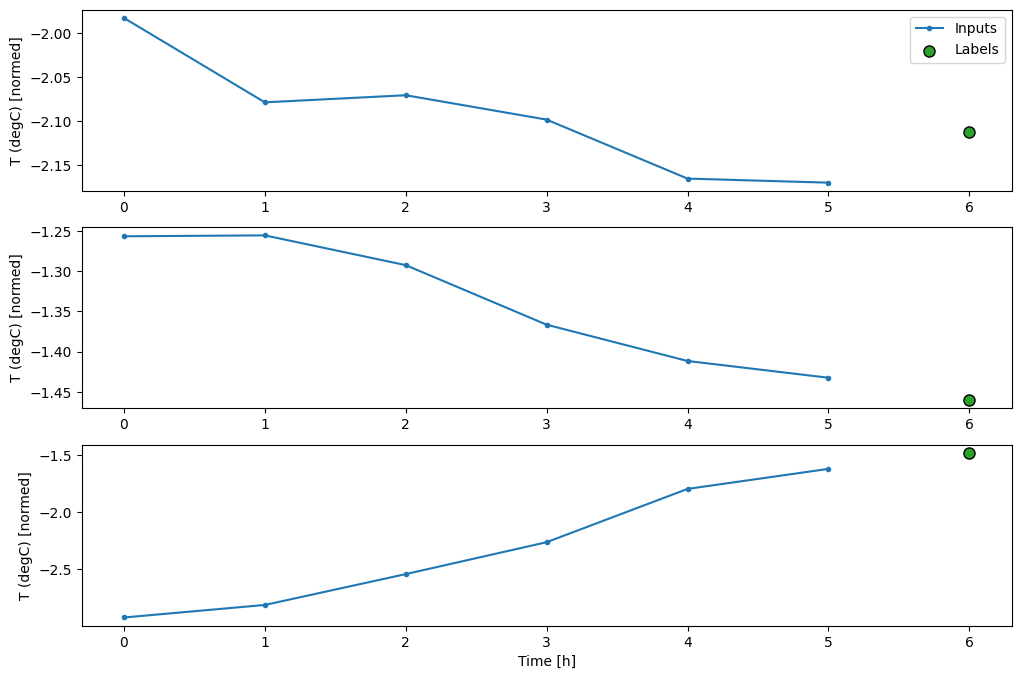

In [26]:
w2.plot()

You can plot the other columns, but the example window `w2` configuration only has labels for the `T (degC)` column.

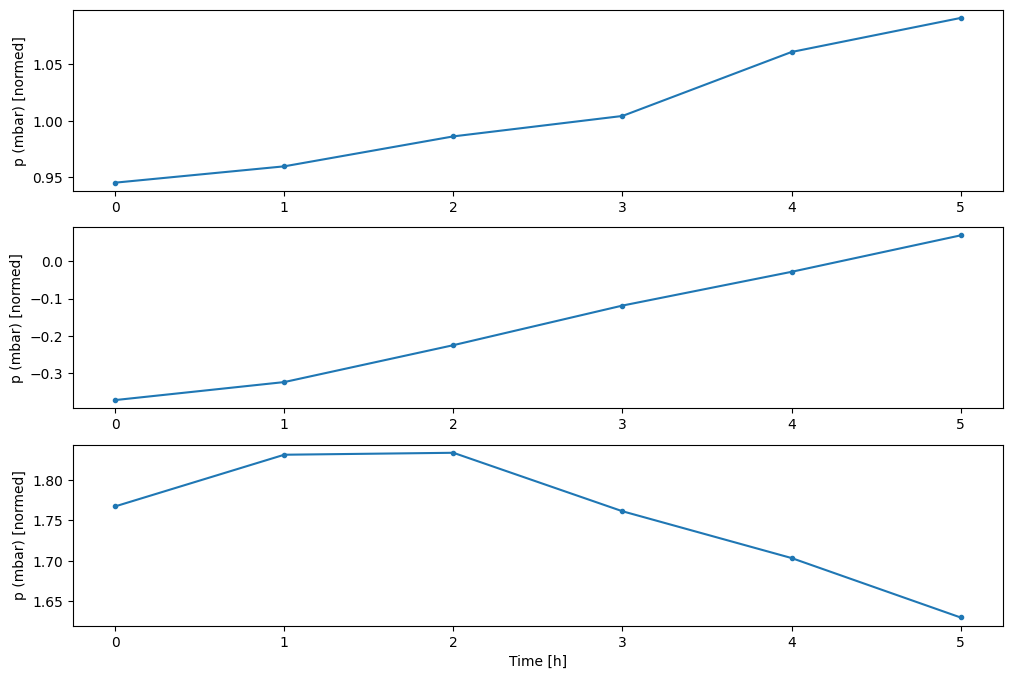

In [27]:
w2.plot(plot_col='p (mbar)')

### 4. Create `tf.data.Dataset`s

Finally, this `make_dataset` method will take a time series DataFrame and convert it to a `tf.data.Dataset` of `(input_window, label_window)` pairs using the `tf.keras.utils.timeseries_dataset_from_array` function:

In [28]:
def make_dataset(self, data):
  data = np.array(data, dtype=np.float32)
  ds = tf.keras.utils.timeseries_dataset_from_array(
      data=data,
      targets=None,
      sequence_length=self.total_window_size,
      sequence_stride=1,
      shuffle=True,
      batch_size=32,)

  ds = ds.map(self.split_window)

  return ds

WindowGenerator.make_dataset = make_dataset

The `WindowGenerator` object holds training, validation, and test data.

Add properties for accessing them as `tf.data.Dataset`s using the `make_dataset` method you defined earlier. Also, add a standard example batch for easy access and plotting:

In [29]:
@property
def train(self):
  return self.make_dataset(self.train_df)

@property
def val(self):
  return self.make_dataset(self.val_df)

@property
def test(self):
  return self.make_dataset(self.test_df)

@property
def example(self):
  """Get and cache an example batch of `inputs, labels` for plotting."""
  result = getattr(self, '_example', None)
  if result is None:
    # No example batch was found, so get one from the `.train` dataset
    result = next(iter(self.train))
    # And cache it for next time
    self._example = result
  return result

WindowGenerator.train = train
WindowGenerator.val = val
WindowGenerator.test = test
WindowGenerator.example = example

Now, the `WindowGenerator` object gives you access to the `tf.data.Dataset` objects, so you can easily iterate over the data.

The `Dataset.element_spec` property tells you the structure, data types, and shapes of the dataset elements.

In [30]:
# Each element is an (inputs, label) pair.
w2.train.element_spec

(TensorSpec(shape=(None, 6, 19), dtype=tf.float32, name=None),
 TensorSpec(shape=(None, 1, 1), dtype=tf.float32, name=None))

Iterating over a `Dataset` yields concrete batches:

In [31]:
for example_inputs, example_labels in w2.train.take(1):
  print(f'Inputs shape (batch, time, features): {example_inputs.shape}')
  print(f'Labels shape (batch, time, features): {example_labels.shape}')

Inputs shape (batch, time, features): (32, 6, 19)
Labels shape (batch, time, features): (32, 1, 1)


## Single step models

The simplest model you can build on this sort of data is one that predicts a single feature's value—1 time step (one hour) into the future based only on the current conditions.

So, start by building models to predict the `T (degC)` value one hour into the future.

![Predict the next time step](images/narrow_window.png)

Configure a `WindowGenerator` object to produce these single-step `(input, label)` pairs:

In [32]:
single_step_window = WindowGenerator(
    input_width=1, label_width=1, shift=1,
    label_columns=['T (degC)'])
single_step_window

Total window size: 2
Input indices: [0]
Label indices: [1]
Label column name(s): ['T (degC)']

The `window` object creates `tf.data.Dataset`s from the training, validation, and test sets, allowing you to easily iterate over batches of data.


In [33]:
for example_inputs, example_labels in single_step_window.train.take(1):
  print(f'Inputs shape (batch, time, features): {example_inputs.shape}')
  print(f'Labels shape (batch, time, features): {example_labels.shape}')

Inputs shape (batch, time, features): (32, 1, 19)
Labels shape (batch, time, features): (32, 1, 1)


### Baseline

Before building a trainable model it would be good to have a performance baseline as a point for comparison with the later more complicated models.

This first task is to predict temperature one hour into the future, given the current value of all features. The current values include the current temperature. 

So, start with a model that just returns the current temperature as the prediction, predicting "No change". This is a reasonable baseline since temperature changes slowly. Of course, this baseline will work less well if you make a prediction further in the future.

![Send the input to the output](images/baseline.png)

In [34]:
class Baseline(tf.keras.Model):
  def __init__(self, label_index=None):
    super().__init__()
    self.label_index = label_index

  def call(self, inputs):
    if self.label_index is None:
      return inputs
    result = inputs[:, :, self.label_index]
    return result[:, :, tf.newaxis]

Instantiate and evaluate this model:

In [35]:
baseline = Baseline(label_index=column_indices['T (degC)'])

baseline.compile(loss=tf.keras.losses.MeanSquaredError(),
                 metrics=[tf.keras.metrics.MeanAbsoluteError()])

val_performance = {}
performance = {}
val_performance['Baseline'] = baseline.evaluate(single_step_window.val)
performance['Baseline'] = baseline.evaluate(single_step_window.test, verbose=0)

  1/439 [..............................] - ETA: 3:55 - loss: 0.0140 - mean_absolute_error: 0.0822

 29/439 [>.............................] - ETA: 0s - loss: 0.0125 - mean_absolute_error: 0.0768  

 59/439 [===>..........................] - ETA: 0s - loss: 0.0124 - mean_absolute_error: 0.0777

 91/439 [=====>........................] - ETA: 0s - loss: 0.0124 - mean_absolute_error: 0.0774

121/439 [=======>......................] - ETA: 0s - loss: 0.0127 - mean_absolute_error: 0.0784

151/439 [=========>....................] - ETA: 0s - loss: 0.0132 - mean_absolute_error: 0.0790

183/439 [===========>..................] - ETA: 0s - loss: 0.0128 - mean_absolute_error: 0.0784

212/439 [=============>................] - ETA: 0s - loss: 0.0127 - mean_absolute_error: 0.0782

241/439 [===============>..............] - ETA: 0s - loss: 0.0128 - mean_absolute_error: 0.0785

270/439 [=================>............] - ETA: 0s - loss: 0.0126 - mean_absolute_error: 0.0780

300/439 [===================>..........] - ETA: 0s - loss: 0.0126 - mean_absolute_error: 0.0779

330/439 [=====================>........] - ETA: 0s - loss: 0.0126 - mean_absolute_error: 0.0782

360/439 [=======================>......] - ETA: 0s - loss: 0.0125 - mean_absolute_error: 0.0778

389/439 [=========================>....] - ETA: 0s - loss: 0.0127 - mean_absolute_error: 0.0783

418/439 [===========================>..] - ETA: 0s - loss: 0.0129 - mean_absolute_error: 0.0785

439/439 [==============================] - 1s 2ms/step - loss: 0.0128 - mean_absolute_error: 0.0785


That printed some performance metrics, but those don't give you a feeling for how well the model is doing.

The `WindowGenerator` has a plot method, but the plots won't be very interesting with only a single sample.

So, create a wider `WindowGenerator` that generates windows 24 hours of consecutive inputs and labels at a time. The new `wide_window` variable doesn't change the way the model operates. The model still makes predictions one hour into the future based on a single input time step. Here, the `time` axis acts like the `batch` axis: each prediction is made independently with no interaction between time steps:

In [36]:
wide_window = WindowGenerator(
    input_width=24, label_width=24, shift=1,
    label_columns=['T (degC)'])

wide_window

Total window size: 25
Input indices: [ 0  1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20 21 22 23]
Label indices: [ 1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20 21 22 23 24]
Label column name(s): ['T (degC)']

This expanded window can be passed directly to the same `baseline` model without any code changes. This is possible because the inputs and labels have the same number of time steps, and the baseline just forwards the input to the output:

![One prediction 1h into the future, ever hour.](images/last_window.png)

In [37]:
print('Input shape:', wide_window.example[0].shape)
print('Output shape:', baseline(wide_window.example[0]).shape)

Input shape: (32, 24, 19)
Output shape: (32, 24, 1)


By plotting the baseline model's predictions, notice that it is simply the labels shifted right by one hour:

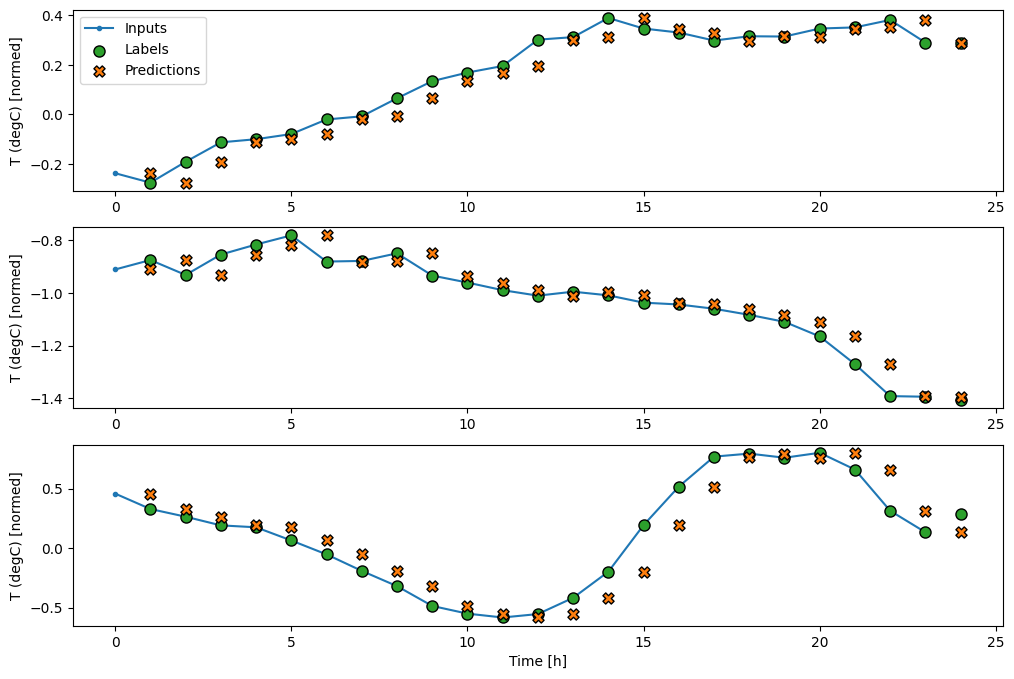

In [38]:
wide_window.plot(baseline)

In the above plots of three examples the single step model is run over the course of 24 hours. This deserves some explanation:

- The blue `Inputs` line shows the input temperature at each time step. The model receives all features, this plot only shows the temperature.
- The green `Labels` dots show the target prediction value. These dots are shown at the prediction time, not the input time. That is why the range of labels is shifted 1 step relative to the inputs.
- The orange `Predictions` crosses are the model's prediction's for each output time step. If the model were predicting perfectly the predictions would land directly on the `Labels`.

### Linear model

The simplest **trainable** model you can apply to this task is to insert linear transformation between the input and output. In this case the output from a time step only depends on that step:

![A single step prediction](images/narrow_window.png)

A `tf.keras.layers.Dense` layer with no `activation` set is a linear model. The layer only transforms the last axis of the data from `(batch, time, inputs)` to `(batch, time, units)`; it is applied independently to every item across the `batch` and `time` axes.

In [39]:
linear = tf.keras.Sequential([
    tf.keras.layers.Dense(units=1)
])

In [40]:
print('Input shape:', single_step_window.example[0].shape)
print('Output shape:', linear(single_step_window.example[0]).shape)

Input shape: (32, 1, 19)
Output shape: (32, 1, 1)


This tutorial trains many models, so package the training procedure into a function:

In [41]:
MAX_EPOCHS = 20

def compile_and_fit(model, window, patience=2):
  early_stopping = tf.keras.callbacks.EarlyStopping(monitor='val_loss',
                                                    patience=patience,
                                                    mode='min')

  model.compile(loss=tf.keras.losses.MeanSquaredError(),
                optimizer=tf.keras.optimizers.Adam(),
                metrics=[tf.keras.metrics.MeanAbsoluteError()])

  history = model.fit(window.train, epochs=MAX_EPOCHS,
                      validation_data=window.val,
                      callbacks=[early_stopping])
  return history

Train the model and evaluate its performance:

In [42]:
history = compile_and_fit(linear, single_step_window)

val_performance['Linear'] = linear.evaluate(single_step_window.val)
performance['Linear'] = linear.evaluate(single_step_window.test, verbose=0)

Epoch 1/20


   1/1534 [..............................] - ETA: 17:22 - loss: 2.0953 - mean_absolute_error: 1.2495

  21/1534 [..............................] - ETA: 3s - loss: 2.6312 - mean_absolute_error: 1.3650   

I0000 00:00:1698384492.579925  449804 device_compiler.h:186] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.


  43/1534 [..............................] - ETA: 3s - loss: 2.2765 - mean_absolute_error: 1.2603

  65/1534 [>.............................] - ETA: 3s - loss: 2.0173 - mean_absolute_error: 1.1862

  86/1534 [>.............................] - ETA: 3s - loss: 1.7805 - mean_absolute_error: 1.1052

 108/1534 [=>............................] - ETA: 3s - loss: 1.5789 - mean_absolute_error: 1.0322

 130/1534 [=>............................] - ETA: 3s - loss: 1.4269 - mean_absolute_error: 0.9738

 152/1534 [=>............................] - ETA: 3s - loss: 1.2860 - mean_absolute_error: 0.9127

 174/1534 [==>...........................] - ETA: 3s - loss: 1.1713 - mean_absolute_error: 0.8610

 196/1534 [==>...........................] - ETA: 3s - loss: 1.0774 - mean_absolute_error: 0.8169

 218/1534 [===>..........................] - ETA: 3s - loss: 0.9953 - mean_absolute_error: 0.7766

 240/1534 [===>..........................] - ETA: 3s - loss: 0.9227 - mean_absolute_error: 0.7388

 262/1534 [====>.........................] - ETA: 3s - loss: 0.8620 - mean_absolute_error: 0.7069

 283/1534 [====>.........................] - ETA: 2s - loss: 0.8110 - mean_absolute_error: 0.6791

 304/1534 [====>.........................] - ETA: 2s - loss: 0.7652 - mean_absolute_error: 0.6532

 326/1534 [=====>........................] - ETA: 2s - loss: 0.7226 - mean_absolute_error: 0.6287

 348/1534 [=====>........................] - ETA: 2s - loss: 0.6854 - mean_absolute_error: 0.6075

 369/1534 [======>.......................] - ETA: 2s - loss: 0.6533 - mean_absolute_error: 0.5884

 391/1534 [======>.......................] - ETA: 2s - loss: 0.6227 - mean_absolute_error: 0.5704

 413/1534 [=======>......................] - ETA: 2s - loss: 0.5960 - mean_absolute_error: 0.5545

 437/1534 [=======>......................] - ETA: 2s - loss: 0.5690 - mean_absolute_error: 0.5376

 459/1534 [=======>......................] - ETA: 2s - loss: 0.5462 - mean_absolute_error: 0.5235

 481/1534 [========>.....................] - ETA: 2s - loss: 0.5259 - mean_absolute_error: 0.5107

 503/1534 [========>.....................] - ETA: 2s - loss: 0.5076 - mean_absolute_error: 0.4990

 525/1534 [=========>....................] - ETA: 2s - loss: 0.4904 - mean_absolute_error: 0.4881

 546/1534 [=========>....................] - ETA: 2s - loss: 0.4748 - mean_absolute_error: 0.4784

 568/1534 [==========>...................] - ETA: 2s - loss: 0.4600 - mean_absolute_error: 0.4687

 590/1534 [==========>...................] - ETA: 2s - loss: 0.4458 - mean_absolute_error: 0.4595

 611/1534 [==========>...................] - ETA: 2s - loss: 0.4333 - mean_absolute_error: 0.4515

 633/1534 [===========>..................] - ETA: 2s - loss: 0.4211 - mean_absolute_error: 0.4436

 656/1534 [===========>..................] - ETA: 2s - loss: 0.4088 - mean_absolute_error: 0.4352

 679/1534 [============>.................] - ETA: 1s - loss: 0.3973 - mean_absolute_error: 0.4275

 701/1534 [============>.................] - ETA: 1s - loss: 0.3872 - mean_absolute_error: 0.4206

 723/1534 [=============>................] - ETA: 1s - loss: 0.3773 - mean_absolute_error: 0.4139

 745/1534 [=============>................] - ETA: 1s - loss: 0.3681 - mean_absolute_error: 0.4076

 767/1534 [==============>...............] - ETA: 1s - loss: 0.3593 - mean_absolute_error: 0.4012

 789/1534 [==============>...............] - ETA: 1s - loss: 0.3510 - mean_absolute_error: 0.3956

 811/1534 [==============>...............] - ETA: 1s - loss: 0.3433 - mean_absolute_error: 0.3903

 833/1534 [===============>..............] - ETA: 1s - loss: 0.3359 - mean_absolute_error: 0.3849

 855/1534 [===============>..............] - ETA: 1s - loss: 0.3289 - mean_absolute_error: 0.3799

 877/1534 [================>.............] - ETA: 1s - loss: 0.3221 - mean_absolute_error: 0.3749

 899/1534 [================>.............] - ETA: 1s - loss: 0.3157 - mean_absolute_error: 0.3704

 921/1534 [=================>............] - ETA: 1s - loss: 0.3094 - mean_absolute_error: 0.3657

 943/1534 [=================>............] - ETA: 1s - loss: 0.3033 - mean_absolute_error: 0.3612

 965/1534 [=================>............] - ETA: 1s - loss: 0.2976 - mean_absolute_error: 0.3570

 987/1534 [==================>...........] - ETA: 1s - loss: 0.2921 - mean_absolute_error: 0.3529

1009/1534 [==================>...........] - ETA: 1s - loss: 0.2869 - mean_absolute_error: 0.3489

1030/1534 [===================>..........] - ETA: 1s - loss: 0.2820 - mean_absolute_error: 0.3453

1051/1534 [===================>..........] - ETA: 1s - loss: 0.2773 - mean_absolute_error: 0.3416

1073/1534 [===================>..........] - ETA: 1s - loss: 0.2726 - mean_absolute_error: 0.3381

1095/1534 [====================>.........] - ETA: 1s - loss: 0.2680 - mean_absolute_error: 0.3345

1117/1534 [====================>.........] - ETA: 0s - loss: 0.2636 - mean_absolute_error: 0.3310

1139/1534 [=====================>........] - ETA: 0s - loss: 0.2594 - mean_absolute_error: 0.3277

1162/1534 [=====================>........] - ETA: 0s - loss: 0.2551 - mean_absolute_error: 0.3242

1184/1534 [======================>.......] - ETA: 0s - loss: 0.2509 - mean_absolute_error: 0.3207

1206/1534 [======================>.......] - ETA: 0s - loss: 0.2471 - mean_absolute_error: 0.3177

1228/1534 [=======================>......] - ETA: 0s - loss: 0.2432 - mean_absolute_error: 0.3145

1250/1534 [=======================>......] - ETA: 0s - loss: 0.2396 - mean_absolute_error: 0.3115

1272/1534 [=======================>......] - ETA: 0s - loss: 0.2360 - mean_absolute_error: 0.3085

1294/1534 [========================>.....] - ETA: 0s - loss: 0.2326 - mean_absolute_error: 0.3057

1316/1534 [========================>.....] - ETA: 0s - loss: 0.2294 - mean_absolute_error: 0.3029

1338/1534 [=========================>....] - ETA: 0s - loss: 0.2261 - mean_absolute_error: 0.3002

1361/1534 [=========================>....] - ETA: 0s - loss: 0.2228 - mean_absolute_error: 0.2975

1383/1534 [==========================>...] - ETA: 0s - loss: 0.2197 - mean_absolute_error: 0.2948

1405/1534 [==========================>...] - ETA: 0s - loss: 0.2168 - mean_absolute_error: 0.2923

1427/1534 [==========================>...] - ETA: 0s - loss: 0.2139 - mean_absolute_error: 0.2898

1449/1534 [===========================>..] - ETA: 0s - loss: 0.2111 - mean_absolute_error: 0.2874

1471/1534 [===========================>..] - ETA: 0s - loss: 0.2083 - mean_absolute_error: 0.2849

1493/1534 [============================>.] - ETA: 0s - loss: 0.2057 - mean_absolute_error: 0.2826

1515/1534 [============================>.] - ETA: 0s - loss: 0.2031 - mean_absolute_error: 0.2803

1534/1534 [==============================] - 5s 3ms/step - loss: 0.2011 - mean_absolute_error: 0.2786 - val_loss: 0.0245 - val_mean_absolute_error: 0.1169


Epoch 2/20


   1/1534 [..............................] - ETA: 58s - loss: 0.0272 - mean_absolute_error: 0.1218

  23/1534 [..............................] - ETA: 3s - loss: 0.0246 - mean_absolute_error: 0.1201 

  46/1534 [..............................] - ETA: 3s - loss: 0.0254 - mean_absolute_error: 0.1189

  69/1534 [>.............................] - ETA: 3s - loss: 0.0245 - mean_absolute_error: 0.1170

  92/1534 [>.............................] - ETA: 3s - loss: 0.0237 - mean_absolute_error: 0.1158

 115/1534 [=>............................] - ETA: 3s - loss: 0.0225 - mean_absolute_error: 0.1134

 138/1534 [=>............................] - ETA: 3s - loss: 0.0224 - mean_absolute_error: 0.1128

 160/1534 [==>...........................] - ETA: 3s - loss: 0.0221 - mean_absolute_error: 0.1121

 183/1534 [==>...........................] - ETA: 3s - loss: 0.0221 - mean_absolute_error: 0.1119

 206/1534 [===>..........................] - ETA: 3s - loss: 0.0217 - mean_absolute_error: 0.1111

 228/1534 [===>..........................] - ETA: 2s - loss: 0.0214 - mean_absolute_error: 0.1106

 250/1534 [===>..........................] - ETA: 2s - loss: 0.0212 - mean_absolute_error: 0.1101

 273/1534 [====>.........................] - ETA: 2s - loss: 0.0208 - mean_absolute_error: 0.1092

 296/1534 [====>.........................] - ETA: 2s - loss: 0.0206 - mean_absolute_error: 0.1087

 318/1534 [=====>........................] - ETA: 2s - loss: 0.0203 - mean_absolute_error: 0.1077

 341/1534 [=====>........................] - ETA: 2s - loss: 0.0200 - mean_absolute_error: 0.1070

 363/1534 [======>.......................] - ETA: 2s - loss: 0.0197 - mean_absolute_error: 0.1062

 385/1534 [======>.......................] - ETA: 2s - loss: 0.0195 - mean_absolute_error: 0.1056

 407/1534 [======>.......................] - ETA: 2s - loss: 0.0193 - mean_absolute_error: 0.1051

 430/1534 [=======>......................] - ETA: 2s - loss: 0.0191 - mean_absolute_error: 0.1046

 452/1534 [=======>......................] - ETA: 2s - loss: 0.0189 - mean_absolute_error: 0.1039

 474/1534 [========>.....................] - ETA: 2s - loss: 0.0187 - mean_absolute_error: 0.1032

 497/1534 [========>.....................] - ETA: 2s - loss: 0.0184 - mean_absolute_error: 0.1025

 519/1534 [=========>....................] - ETA: 2s - loss: 0.0182 - mean_absolute_error: 0.1018

 541/1534 [=========>....................] - ETA: 2s - loss: 0.0180 - mean_absolute_error: 0.1013

 564/1534 [==========>...................] - ETA: 2s - loss: 0.0179 - mean_absolute_error: 0.1008

 587/1534 [==========>...................] - ETA: 2s - loss: 0.0177 - mean_absolute_error: 0.1003

 609/1534 [==========>...................] - ETA: 2s - loss: 0.0176 - mean_absolute_error: 0.0999

 631/1534 [===========>..................] - ETA: 2s - loss: 0.0175 - mean_absolute_error: 0.0995

 653/1534 [===========>..................] - ETA: 2s - loss: 0.0173 - mean_absolute_error: 0.0990

 675/1534 [============>.................] - ETA: 1s - loss: 0.0171 - mean_absolute_error: 0.0985

 698/1534 [============>.................] - ETA: 1s - loss: 0.0170 - mean_absolute_error: 0.0979

 721/1534 [=============>................] - ETA: 1s - loss: 0.0169 - mean_absolute_error: 0.0975

 744/1534 [=============>................] - ETA: 1s - loss: 0.0167 - mean_absolute_error: 0.0970

 766/1534 [=============>................] - ETA: 1s - loss: 0.0166 - mean_absolute_error: 0.0965

 788/1534 [==============>...............] - ETA: 1s - loss: 0.0165 - mean_absolute_error: 0.0962

 810/1534 [==============>...............] - ETA: 1s - loss: 0.0164 - mean_absolute_error: 0.0957

 832/1534 [===============>..............] - ETA: 1s - loss: 0.0163 - mean_absolute_error: 0.0952

 854/1534 [===============>..............] - ETA: 1s - loss: 0.0162 - mean_absolute_error: 0.0949

 876/1534 [================>.............] - ETA: 1s - loss: 0.0161 - mean_absolute_error: 0.0945

 898/1534 [================>.............] - ETA: 1s - loss: 0.0160 - mean_absolute_error: 0.0941

 920/1534 [================>.............] - ETA: 1s - loss: 0.0158 - mean_absolute_error: 0.0937

 943/1534 [=================>............] - ETA: 1s - loss: 0.0158 - mean_absolute_error: 0.0935

 966/1534 [=================>............] - ETA: 1s - loss: 0.0157 - mean_absolute_error: 0.0932

 988/1534 [==================>...........] - ETA: 1s - loss: 0.0156 - mean_absolute_error: 0.0930

1010/1534 [==================>...........] - ETA: 1s - loss: 0.0155 - mean_absolute_error: 0.0926

1031/1534 [===================>..........] - ETA: 1s - loss: 0.0154 - mean_absolute_error: 0.0924

1053/1534 [===================>..........] - ETA: 1s - loss: 0.0154 - mean_absolute_error: 0.0922

1075/1534 [====================>.........] - ETA: 1s - loss: 0.0153 - mean_absolute_error: 0.0919

1097/1534 [====================>.........] - ETA: 1s - loss: 0.0152 - mean_absolute_error: 0.0917

1119/1534 [====================>.........] - ETA: 0s - loss: 0.0151 - mean_absolute_error: 0.0914

1141/1534 [=====================>........] - ETA: 0s - loss: 0.0151 - mean_absolute_error: 0.0913

1163/1534 [=====================>........] - ETA: 0s - loss: 0.0150 - mean_absolute_error: 0.0910

1185/1534 [======================>.......] - ETA: 0s - loss: 0.0149 - mean_absolute_error: 0.0907

1207/1534 [======================>.......] - ETA: 0s - loss: 0.0148 - mean_absolute_error: 0.0904

1229/1534 [=======================>......] - ETA: 0s - loss: 0.0147 - mean_absolute_error: 0.0902

1252/1534 [=======================>......] - ETA: 0s - loss: 0.0146 - mean_absolute_error: 0.0899

1274/1534 [=======================>......] - ETA: 0s - loss: 0.0145 - mean_absolute_error: 0.0896

1296/1534 [========================>.....] - ETA: 0s - loss: 0.0145 - mean_absolute_error: 0.0895

1319/1534 [========================>.....] - ETA: 0s - loss: 0.0144 - mean_absolute_error: 0.0893

1341/1534 [=========================>....] - ETA: 0s - loss: 0.0144 - mean_absolute_error: 0.0891

1363/1534 [=========================>....] - ETA: 0s - loss: 0.0144 - mean_absolute_error: 0.0889

1386/1534 [==========================>...] - ETA: 0s - loss: 0.0143 - mean_absolute_error: 0.0888

1407/1534 [==========================>...] - ETA: 0s - loss: 0.0143 - mean_absolute_error: 0.0887

1428/1534 [==========================>...] - ETA: 0s - loss: 0.0142 - mean_absolute_error: 0.0884

1449/1534 [===========================>..] - ETA: 0s - loss: 0.0141 - mean_absolute_error: 0.0882

1470/1534 [===========================>..] - ETA: 0s - loss: 0.0141 - mean_absolute_error: 0.0880

1492/1534 [============================>.] - ETA: 0s - loss: 0.0140 - mean_absolute_error: 0.0879

1513/1534 [============================>.] - ETA: 0s - loss: 0.0140 - mean_absolute_error: 0.0877

1534/1534 [==============================] - 4s 3ms/step - loss: 0.0140 - mean_absolute_error: 0.0876 - val_loss: 0.0099 - val_mean_absolute_error: 0.0739


Epoch 3/20


   1/1534 [..............................] - ETA: 56s - loss: 0.0055 - mean_absolute_error: 0.0543

  22/1534 [..............................] - ETA: 3s - loss: 0.0134 - mean_absolute_error: 0.0819 

  44/1534 [..............................] - ETA: 3s - loss: 0.0116 - mean_absolute_error: 0.0780

  67/1534 [>.............................] - ETA: 3s - loss: 0.0112 - mean_absolute_error: 0.0775

  89/1534 [>.............................] - ETA: 3s - loss: 0.0106 - mean_absolute_error: 0.0756

 111/1534 [=>............................] - ETA: 3s - loss: 0.0101 - mean_absolute_error: 0.0744

 133/1534 [=>............................] - ETA: 3s - loss: 0.0101 - mean_absolute_error: 0.0748

 155/1534 [==>...........................] - ETA: 3s - loss: 0.0101 - mean_absolute_error: 0.0747

 177/1534 [==>...........................] - ETA: 3s - loss: 0.0102 - mean_absolute_error: 0.0750

 199/1534 [==>...........................] - ETA: 3s - loss: 0.0102 - mean_absolute_error: 0.0753

 222/1534 [===>..........................] - ETA: 3s - loss: 0.0101 - mean_absolute_error: 0.0751

 244/1534 [===>..........................] - ETA: 2s - loss: 0.0102 - mean_absolute_error: 0.0751

 267/1534 [====>.........................] - ETA: 2s - loss: 0.0102 - mean_absolute_error: 0.0753

 290/1534 [====>.........................] - ETA: 2s - loss: 0.0101 - mean_absolute_error: 0.0750

 312/1534 [=====>........................] - ETA: 2s - loss: 0.0101 - mean_absolute_error: 0.0748

 334/1534 [=====>........................] - ETA: 2s - loss: 0.0100 - mean_absolute_error: 0.0748

 357/1534 [=====>........................] - ETA: 2s - loss: 0.0100 - mean_absolute_error: 0.0746

 379/1534 [======>.......................] - ETA: 2s - loss: 0.0099 - mean_absolute_error: 0.0745

 402/1534 [======>.......................] - ETA: 2s - loss: 0.0099 - mean_absolute_error: 0.0745

 424/1534 [=======>......................] - ETA: 2s - loss: 0.0099 - mean_absolute_error: 0.0744

 447/1534 [=======>......................] - ETA: 2s - loss: 0.0100 - mean_absolute_error: 0.0747

 470/1534 [========>.....................] - ETA: 2s - loss: 0.0099 - mean_absolute_error: 0.0744

 492/1534 [========>.....................] - ETA: 2s - loss: 0.0098 - mean_absolute_error: 0.0741

 514/1534 [=========>....................] - ETA: 2s - loss: 0.0098 - mean_absolute_error: 0.0740

 536/1534 [=========>....................] - ETA: 2s - loss: 0.0097 - mean_absolute_error: 0.0738

 558/1534 [=========>....................] - ETA: 2s - loss: 0.0098 - mean_absolute_error: 0.0739

 580/1534 [==========>...................] - ETA: 2s - loss: 0.0098 - mean_absolute_error: 0.0739

 603/1534 [==========>...................] - ETA: 2s - loss: 0.0098 - mean_absolute_error: 0.0737

 625/1534 [===========>..................] - ETA: 2s - loss: 0.0098 - mean_absolute_error: 0.0738

 648/1534 [===========>..................] - ETA: 2s - loss: 0.0097 - mean_absolute_error: 0.0737

 670/1534 [============>.................] - ETA: 1s - loss: 0.0097 - mean_absolute_error: 0.0736

 693/1534 [============>.................] - ETA: 1s - loss: 0.0097 - mean_absolute_error: 0.0734

 716/1534 [=============>................] - ETA: 1s - loss: 0.0097 - mean_absolute_error: 0.0735

 739/1534 [=============>................] - ETA: 1s - loss: 0.0097 - mean_absolute_error: 0.0733

 761/1534 [=============>................] - ETA: 1s - loss: 0.0097 - mean_absolute_error: 0.0733

 783/1534 [==============>...............] - ETA: 1s - loss: 0.0097 - mean_absolute_error: 0.0732

 806/1534 [==============>...............] - ETA: 1s - loss: 0.0097 - mean_absolute_error: 0.0732

 829/1534 [===============>..............] - ETA: 1s - loss: 0.0097 - mean_absolute_error: 0.0730

 851/1534 [===============>..............] - ETA: 1s - loss: 0.0098 - mean_absolute_error: 0.0730

 873/1534 [================>.............] - ETA: 1s - loss: 0.0098 - mean_absolute_error: 0.0730

 895/1534 [================>.............] - ETA: 1s - loss: 0.0097 - mean_absolute_error: 0.0728

 917/1534 [================>.............] - ETA: 1s - loss: 0.0097 - mean_absolute_error: 0.0728

 940/1534 [=================>............] - ETA: 1s - loss: 0.0097 - mean_absolute_error: 0.0728

 962/1534 [=================>............] - ETA: 1s - loss: 0.0097 - mean_absolute_error: 0.0728

 984/1534 [==================>...........] - ETA: 1s - loss: 0.0097 - mean_absolute_error: 0.0728

1006/1534 [==================>...........] - ETA: 1s - loss: 0.0097 - mean_absolute_error: 0.0728

1028/1534 [===================>..........] - ETA: 1s - loss: 0.0097 - mean_absolute_error: 0.0728

1051/1534 [===================>..........] - ETA: 1s - loss: 0.0097 - mean_absolute_error: 0.0728

1074/1534 [====================>.........] - ETA: 1s - loss: 0.0097 - mean_absolute_error: 0.0728

1097/1534 [====================>.........] - ETA: 0s - loss: 0.0097 - mean_absolute_error: 0.0728

1120/1534 [====================>.........] - ETA: 0s - loss: 0.0097 - mean_absolute_error: 0.0728

1142/1534 [=====================>........] - ETA: 0s - loss: 0.0097 - mean_absolute_error: 0.0729

1165/1534 [=====================>........] - ETA: 0s - loss: 0.0097 - mean_absolute_error: 0.0728

1187/1534 [======================>.......] - ETA: 0s - loss: 0.0097 - mean_absolute_error: 0.0728

1210/1534 [======================>.......] - ETA: 0s - loss: 0.0097 - mean_absolute_error: 0.0727

1232/1534 [=======================>......] - ETA: 0s - loss: 0.0096 - mean_absolute_error: 0.0726

1254/1534 [=======================>......] - ETA: 0s - loss: 0.0096 - mean_absolute_error: 0.0726

1276/1534 [=======================>......] - ETA: 0s - loss: 0.0096 - mean_absolute_error: 0.0725

1299/1534 [========================>.....] - ETA: 0s - loss: 0.0096 - mean_absolute_error: 0.0726

1321/1534 [========================>.....] - ETA: 0s - loss: 0.0096 - mean_absolute_error: 0.0726

1343/1534 [=========================>....] - ETA: 0s - loss: 0.0096 - mean_absolute_error: 0.0726

1366/1534 [=========================>....] - ETA: 0s - loss: 0.0096 - mean_absolute_error: 0.0726

1389/1534 [==========================>...] - ETA: 0s - loss: 0.0097 - mean_absolute_error: 0.0727

1412/1534 [==========================>...] - ETA: 0s - loss: 0.0097 - mean_absolute_error: 0.0726

1434/1534 [===========================>..] - ETA: 0s - loss: 0.0096 - mean_absolute_error: 0.0726

1457/1534 [===========================>..] - ETA: 0s - loss: 0.0096 - mean_absolute_error: 0.0726

1480/1534 [===========================>..] - ETA: 0s - loss: 0.0096 - mean_absolute_error: 0.0725

1502/1534 [============================>.] - ETA: 0s - loss: 0.0096 - mean_absolute_error: 0.0725

1525/1534 [============================>.] - ETA: 0s - loss: 0.0096 - mean_absolute_error: 0.0725

1534/1534 [==============================] - 4s 3ms/step - loss: 0.0097 - mean_absolute_error: 0.0726 - val_loss: 0.0091 - val_mean_absolute_error: 0.0713


Epoch 4/20


   1/1534 [..............................] - ETA: 52s - loss: 0.0073 - mean_absolute_error: 0.0635

  23/1534 [..............................] - ETA: 3s - loss: 0.0116 - mean_absolute_error: 0.0767 

  46/1534 [..............................] - ETA: 3s - loss: 0.0104 - mean_absolute_error: 0.0736

  68/1534 [>.............................] - ETA: 3s - loss: 0.0103 - mean_absolute_error: 0.0735

  91/1534 [>.............................] - ETA: 3s - loss: 0.0096 - mean_absolute_error: 0.0716

 114/1534 [=>............................] - ETA: 3s - loss: 0.0093 - mean_absolute_error: 0.0708

 136/1534 [=>............................] - ETA: 3s - loss: 0.0092 - mean_absolute_error: 0.0710

 158/1534 [==>...........................] - ETA: 3s - loss: 0.0094 - mean_absolute_error: 0.0713

 181/1534 [==>...........................] - ETA: 3s - loss: 0.0094 - mean_absolute_error: 0.0716

 203/1534 [==>...........................] - ETA: 3s - loss: 0.0094 - mean_absolute_error: 0.0718

 226/1534 [===>..........................] - ETA: 2s - loss: 0.0094 - mean_absolute_error: 0.0716

 249/1534 [===>..........................] - ETA: 2s - loss: 0.0094 - mean_absolute_error: 0.0718

 272/1534 [====>.........................] - ETA: 2s - loss: 0.0094 - mean_absolute_error: 0.0716

 296/1534 [====>.........................] - ETA: 2s - loss: 0.0093 - mean_absolute_error: 0.0714

 318/1534 [=====>........................] - ETA: 2s - loss: 0.0093 - mean_absolute_error: 0.0714

 341/1534 [=====>........................] - ETA: 2s - loss: 0.0093 - mean_absolute_error: 0.0713

 363/1534 [======>.......................] - ETA: 2s - loss: 0.0093 - mean_absolute_error: 0.0714

 385/1534 [======>.......................] - ETA: 2s - loss: 0.0092 - mean_absolute_error: 0.0713

 407/1534 [======>.......................] - ETA: 2s - loss: 0.0092 - mean_absolute_error: 0.0712

 429/1534 [=======>......................] - ETA: 2s - loss: 0.0092 - mean_absolute_error: 0.0713

 451/1534 [=======>......................] - ETA: 2s - loss: 0.0092 - mean_absolute_error: 0.0714

 473/1534 [========>.....................] - ETA: 2s - loss: 0.0092 - mean_absolute_error: 0.0713

 495/1534 [========>.....................] - ETA: 2s - loss: 0.0092 - mean_absolute_error: 0.0712

 516/1534 [=========>....................] - ETA: 2s - loss: 0.0091 - mean_absolute_error: 0.0711

 538/1534 [=========>....................] - ETA: 2s - loss: 0.0091 - mean_absolute_error: 0.0709

 560/1534 [=========>....................] - ETA: 2s - loss: 0.0091 - mean_absolute_error: 0.0709

 582/1534 [==========>...................] - ETA: 2s - loss: 0.0091 - mean_absolute_error: 0.0710

 604/1534 [==========>...................] - ETA: 2s - loss: 0.0091 - mean_absolute_error: 0.0710

 626/1534 [===========>..................] - ETA: 2s - loss: 0.0092 - mean_absolute_error: 0.0711

 648/1534 [===========>..................] - ETA: 2s - loss: 0.0091 - mean_absolute_error: 0.0709

 669/1534 [============>.................] - ETA: 1s - loss: 0.0091 - mean_absolute_error: 0.0709

 691/1534 [============>.................] - ETA: 1s - loss: 0.0091 - mean_absolute_error: 0.0708

 713/1534 [============>.................] - ETA: 1s - loss: 0.0091 - mean_absolute_error: 0.0708

 735/1534 [=============>................] - ETA: 1s - loss: 0.0091 - mean_absolute_error: 0.0706

 757/1534 [=============>................] - ETA: 1s - loss: 0.0091 - mean_absolute_error: 0.0708

 779/1534 [==============>...............] - ETA: 1s - loss: 0.0092 - mean_absolute_error: 0.0707

 801/1534 [==============>...............] - ETA: 1s - loss: 0.0092 - mean_absolute_error: 0.0706

 823/1534 [===============>..............] - ETA: 1s - loss: 0.0092 - mean_absolute_error: 0.0705

 845/1534 [===============>..............] - ETA: 1s - loss: 0.0092 - mean_absolute_error: 0.0706

 866/1534 [===============>..............] - ETA: 1s - loss: 0.0092 - mean_absolute_error: 0.0705

 887/1534 [================>.............] - ETA: 1s - loss: 0.0092 - mean_absolute_error: 0.0704

 908/1534 [================>.............] - ETA: 1s - loss: 0.0092 - mean_absolute_error: 0.0704

 930/1534 [=================>............] - ETA: 1s - loss: 0.0092 - mean_absolute_error: 0.0703

 953/1534 [=================>............] - ETA: 1s - loss: 0.0092 - mean_absolute_error: 0.0704

 975/1534 [==================>...........] - ETA: 1s - loss: 0.0092 - mean_absolute_error: 0.0705

 997/1534 [==================>...........] - ETA: 1s - loss: 0.0092 - mean_absolute_error: 0.0703

1019/1534 [==================>...........] - ETA: 1s - loss: 0.0092 - mean_absolute_error: 0.0703

1040/1534 [===================>..........] - ETA: 1s - loss: 0.0092 - mean_absolute_error: 0.0704

1062/1534 [===================>..........] - ETA: 1s - loss: 0.0092 - mean_absolute_error: 0.0704

1084/1534 [====================>.........] - ETA: 1s - loss: 0.0092 - mean_absolute_error: 0.0704

1106/1534 [====================>.........] - ETA: 0s - loss: 0.0092 - mean_absolute_error: 0.0705

1127/1534 [=====================>........] - ETA: 0s - loss: 0.0092 - mean_absolute_error: 0.0705

1149/1534 [=====================>........] - ETA: 0s - loss: 0.0092 - mean_absolute_error: 0.0706

1171/1534 [=====================>........] - ETA: 0s - loss: 0.0092 - mean_absolute_error: 0.0706

1193/1534 [======================>.......] - ETA: 0s - loss: 0.0092 - mean_absolute_error: 0.0705

1215/1534 [======================>.......] - ETA: 0s - loss: 0.0092 - mean_absolute_error: 0.0705

1237/1534 [=======================>......] - ETA: 0s - loss: 0.0092 - mean_absolute_error: 0.0705

1259/1534 [=======================>......] - ETA: 0s - loss: 0.0091 - mean_absolute_error: 0.0704

1281/1534 [========================>.....] - ETA: 0s - loss: 0.0091 - mean_absolute_error: 0.0704

1302/1534 [========================>.....] - ETA: 0s - loss: 0.0092 - mean_absolute_error: 0.0705

1323/1534 [========================>.....] - ETA: 0s - loss: 0.0092 - mean_absolute_error: 0.0705

1344/1534 [=========================>....] - ETA: 0s - loss: 0.0092 - mean_absolute_error: 0.0705

1366/1534 [=========================>....] - ETA: 0s - loss: 0.0092 - mean_absolute_error: 0.0706

1388/1534 [==========================>...] - ETA: 0s - loss: 0.0092 - mean_absolute_error: 0.0707

1409/1534 [==========================>...] - ETA: 0s - loss: 0.0092 - mean_absolute_error: 0.0707

1431/1534 [==========================>...] - ETA: 0s - loss: 0.0092 - mean_absolute_error: 0.0706

1453/1534 [===========================>..] - ETA: 0s - loss: 0.0092 - mean_absolute_error: 0.0706

1475/1534 [===========================>..] - ETA: 0s - loss: 0.0092 - mean_absolute_error: 0.0706

1497/1534 [============================>.] - ETA: 0s - loss: 0.0092 - mean_absolute_error: 0.0706

1519/1534 [============================>.] - ETA: 0s - loss: 0.0092 - mean_absolute_error: 0.0706

1534/1534 [==============================] - 4s 3ms/step - loss: 0.0093 - mean_absolute_error: 0.0707 - val_loss: 0.0087 - val_mean_absolute_error: 0.0688


Epoch 5/20


   1/1534 [..............................] - ETA: 55s - loss: 0.0052 - mean_absolute_error: 0.0578

  20/1534 [..............................] - ETA: 4s - loss: 0.0119 - mean_absolute_error: 0.0778 

  42/1534 [..............................] - ETA: 3s - loss: 0.0104 - mean_absolute_error: 0.0736

  63/1534 [>.............................] - ETA: 3s - loss: 0.0100 - mean_absolute_error: 0.0724

  84/1534 [>.............................] - ETA: 3s - loss: 0.0097 - mean_absolute_error: 0.0714

 106/1534 [=>............................] - ETA: 3s - loss: 0.0092 - mean_absolute_error: 0.0703

 128/1534 [=>............................] - ETA: 3s - loss: 0.0091 - mean_absolute_error: 0.0704

 150/1534 [=>............................] - ETA: 3s - loss: 0.0092 - mean_absolute_error: 0.0703

 172/1534 [==>...........................] - ETA: 3s - loss: 0.0092 - mean_absolute_error: 0.0706

 194/1534 [==>...........................] - ETA: 3s - loss: 0.0092 - mean_absolute_error: 0.0709

 215/1534 [===>..........................] - ETA: 3s - loss: 0.0093 - mean_absolute_error: 0.0710

 237/1534 [===>..........................] - ETA: 3s - loss: 0.0093 - mean_absolute_error: 0.0709

 259/1534 [====>.........................] - ETA: 3s - loss: 0.0093 - mean_absolute_error: 0.0710

 283/1534 [====>.........................] - ETA: 2s - loss: 0.0092 - mean_absolute_error: 0.0710

 305/1534 [====>.........................] - ETA: 2s - loss: 0.0092 - mean_absolute_error: 0.0709

 327/1534 [=====>........................] - ETA: 2s - loss: 0.0092 - mean_absolute_error: 0.0708

 349/1534 [=====>........................] - ETA: 2s - loss: 0.0092 - mean_absolute_error: 0.0707

 371/1534 [======>.......................] - ETA: 2s - loss: 0.0091 - mean_absolute_error: 0.0706

 393/1534 [======>.......................] - ETA: 2s - loss: 0.0091 - mean_absolute_error: 0.0706

 415/1534 [=======>......................] - ETA: 2s - loss: 0.0091 - mean_absolute_error: 0.0706

 437/1534 [=======>......................] - ETA: 2s - loss: 0.0091 - mean_absolute_error: 0.0709

 459/1534 [=======>......................] - ETA: 2s - loss: 0.0091 - mean_absolute_error: 0.0707

 481/1534 [========>.....................] - ETA: 2s - loss: 0.0091 - mean_absolute_error: 0.0706

 503/1534 [========>.....................] - ETA: 2s - loss: 0.0090 - mean_absolute_error: 0.0706

 525/1534 [=========>....................] - ETA: 2s - loss: 0.0090 - mean_absolute_error: 0.0704

 547/1534 [=========>....................] - ETA: 2s - loss: 0.0090 - mean_absolute_error: 0.0704

 568/1534 [==========>...................] - ETA: 2s - loss: 0.0090 - mean_absolute_error: 0.0703

 589/1534 [==========>...................] - ETA: 2s - loss: 0.0090 - mean_absolute_error: 0.0703

 611/1534 [==========>...................] - ETA: 2s - loss: 0.0090 - mean_absolute_error: 0.0703

 633/1534 [===========>..................] - ETA: 2s - loss: 0.0091 - mean_absolute_error: 0.0704

 655/1534 [===========>..................] - ETA: 2s - loss: 0.0090 - mean_absolute_error: 0.0704

 677/1534 [============>.................] - ETA: 2s - loss: 0.0090 - mean_absolute_error: 0.0702

 699/1534 [============>.................] - ETA: 1s - loss: 0.0090 - mean_absolute_error: 0.0702

 721/1534 [=============>................] - ETA: 1s - loss: 0.0090 - mean_absolute_error: 0.0702

 743/1534 [=============>................] - ETA: 1s - loss: 0.0090 - mean_absolute_error: 0.0702

 765/1534 [=============>................] - ETA: 1s - loss: 0.0090 - mean_absolute_error: 0.0701

 787/1534 [==============>...............] - ETA: 1s - loss: 0.0091 - mean_absolute_error: 0.0701

 809/1534 [==============>...............] - ETA: 1s - loss: 0.0090 - mean_absolute_error: 0.0700

 831/1534 [===============>..............] - ETA: 1s - loss: 0.0091 - mean_absolute_error: 0.0700

 853/1534 [===============>..............] - ETA: 1s - loss: 0.0091 - mean_absolute_error: 0.0700

 875/1534 [================>.............] - ETA: 1s - loss: 0.0091 - mean_absolute_error: 0.0699

 894/1534 [================>.............] - ETA: 1s - loss: 0.0091 - mean_absolute_error: 0.0698

 915/1534 [================>.............] - ETA: 1s - loss: 0.0091 - mean_absolute_error: 0.0699

 937/1534 [=================>............] - ETA: 1s - loss: 0.0091 - mean_absolute_error: 0.0698

 959/1534 [=================>............] - ETA: 1s - loss: 0.0091 - mean_absolute_error: 0.0699

 980/1534 [==================>...........] - ETA: 1s - loss: 0.0091 - mean_absolute_error: 0.0699

1002/1534 [==================>...........] - ETA: 1s - loss: 0.0091 - mean_absolute_error: 0.0699

1024/1534 [===================>..........] - ETA: 1s - loss: 0.0091 - mean_absolute_error: 0.0699

1046/1534 [===================>..........] - ETA: 1s - loss: 0.0091 - mean_absolute_error: 0.0700

1068/1534 [===================>..........] - ETA: 1s - loss: 0.0091 - mean_absolute_error: 0.0700

1090/1534 [====================>.........] - ETA: 1s - loss: 0.0091 - mean_absolute_error: 0.0700

1112/1534 [====================>.........] - ETA: 0s - loss: 0.0091 - mean_absolute_error: 0.0700

1134/1534 [=====================>........] - ETA: 0s - loss: 0.0091 - mean_absolute_error: 0.0701

1156/1534 [=====================>........] - ETA: 0s - loss: 0.0091 - mean_absolute_error: 0.0701

1178/1534 [======================>.......] - ETA: 0s - loss: 0.0091 - mean_absolute_error: 0.0700

1200/1534 [======================>.......] - ETA: 0s - loss: 0.0091 - mean_absolute_error: 0.0700

1222/1534 [======================>.......] - ETA: 0s - loss: 0.0091 - mean_absolute_error: 0.0700

1244/1534 [=======================>......] - ETA: 0s - loss: 0.0091 - mean_absolute_error: 0.0699

1266/1534 [=======================>......] - ETA: 0s - loss: 0.0091 - mean_absolute_error: 0.0699

1288/1534 [========================>.....] - ETA: 0s - loss: 0.0091 - mean_absolute_error: 0.0700

1310/1534 [========================>.....] - ETA: 0s - loss: 0.0091 - mean_absolute_error: 0.0700

1332/1534 [=========================>....] - ETA: 0s - loss: 0.0091 - mean_absolute_error: 0.0700

1353/1534 [=========================>....] - ETA: 0s - loss: 0.0091 - mean_absolute_error: 0.0700

1375/1534 [=========================>....] - ETA: 0s - loss: 0.0092 - mean_absolute_error: 0.0701

1397/1534 [==========================>...] - ETA: 0s - loss: 0.0092 - mean_absolute_error: 0.0702

1419/1534 [==========================>...] - ETA: 0s - loss: 0.0091 - mean_absolute_error: 0.0701

1441/1534 [===========================>..] - ETA: 0s - loss: 0.0091 - mean_absolute_error: 0.0700

1463/1534 [===========================>..] - ETA: 0s - loss: 0.0091 - mean_absolute_error: 0.0700

1485/1534 [============================>.] - ETA: 0s - loss: 0.0091 - mean_absolute_error: 0.0701

1507/1534 [============================>.] - ETA: 0s - loss: 0.0091 - mean_absolute_error: 0.0701

1529/1534 [============================>.] - ETA: 0s - loss: 0.0092 - mean_absolute_error: 0.0701

1534/1534 [==============================] - 4s 3ms/step - loss: 0.0092 - mean_absolute_error: 0.0702 - val_loss: 0.0090 - val_mean_absolute_error: 0.0706


Epoch 6/20


   1/1534 [..............................] - ETA: 55s - loss: 0.0051 - mean_absolute_error: 0.0605

  21/1534 [..............................] - ETA: 3s - loss: 0.0118 - mean_absolute_error: 0.0781 

  43/1534 [..............................] - ETA: 3s - loss: 0.0104 - mean_absolute_error: 0.0736

  65/1534 [>.............................] - ETA: 3s - loss: 0.0100 - mean_absolute_error: 0.0722

  87/1534 [>.............................] - ETA: 3s - loss: 0.0096 - mean_absolute_error: 0.0712

 108/1534 [=>............................] - ETA: 3s - loss: 0.0091 - mean_absolute_error: 0.0698

 130/1534 [=>............................] - ETA: 3s - loss: 0.0090 - mean_absolute_error: 0.0696

 152/1534 [=>............................] - ETA: 3s - loss: 0.0092 - mean_absolute_error: 0.0703

 174/1534 [==>...........................] - ETA: 3s - loss: 0.0092 - mean_absolute_error: 0.0706

 196/1534 [==>...........................] - ETA: 3s - loss: 0.0092 - mean_absolute_error: 0.0708

 218/1534 [===>..........................] - ETA: 3s - loss: 0.0092 - mean_absolute_error: 0.0707

 240/1534 [===>..........................] - ETA: 3s - loss: 0.0092 - mean_absolute_error: 0.0707

 262/1534 [====>.........................] - ETA: 2s - loss: 0.0092 - mean_absolute_error: 0.0707

 285/1534 [====>.........................] - ETA: 2s - loss: 0.0092 - mean_absolute_error: 0.0708

 307/1534 [=====>........................] - ETA: 2s - loss: 0.0092 - mean_absolute_error: 0.0707

 329/1534 [=====>........................] - ETA: 2s - loss: 0.0091 - mean_absolute_error: 0.0706

 351/1534 [=====>........................] - ETA: 2s - loss: 0.0091 - mean_absolute_error: 0.0705

 373/1534 [======>.......................] - ETA: 2s - loss: 0.0091 - mean_absolute_error: 0.0705

 395/1534 [======>.......................] - ETA: 2s - loss: 0.0090 - mean_absolute_error: 0.0704

 417/1534 [=======>......................] - ETA: 2s - loss: 0.0090 - mean_absolute_error: 0.0704

 439/1534 [=======>......................] - ETA: 2s - loss: 0.0090 - mean_absolute_error: 0.0706

 462/1534 [========>.....................] - ETA: 2s - loss: 0.0090 - mean_absolute_error: 0.0707

 484/1534 [========>.....................] - ETA: 2s - loss: 0.0090 - mean_absolute_error: 0.0705

 506/1534 [========>.....................] - ETA: 2s - loss: 0.0090 - mean_absolute_error: 0.0704

 528/1534 [=========>....................] - ETA: 2s - loss: 0.0090 - mean_absolute_error: 0.0702

 550/1534 [=========>....................] - ETA: 2s - loss: 0.0090 - mean_absolute_error: 0.0703

 572/1534 [==========>...................] - ETA: 2s - loss: 0.0090 - mean_absolute_error: 0.0702

 595/1534 [==========>...................] - ETA: 2s - loss: 0.0089 - mean_absolute_error: 0.0701

 617/1534 [===========>..................] - ETA: 2s - loss: 0.0090 - mean_absolute_error: 0.0703

 639/1534 [===========>..................] - ETA: 2s - loss: 0.0090 - mean_absolute_error: 0.0702

 661/1534 [===========>..................] - ETA: 2s - loss: 0.0090 - mean_absolute_error: 0.0702

 683/1534 [============>.................] - ETA: 1s - loss: 0.0089 - mean_absolute_error: 0.0701

 705/1534 [============>.................] - ETA: 1s - loss: 0.0089 - mean_absolute_error: 0.0701

 727/1534 [=============>................] - ETA: 1s - loss: 0.0089 - mean_absolute_error: 0.0700

 749/1534 [=============>................] - ETA: 1s - loss: 0.0090 - mean_absolute_error: 0.0700

 771/1534 [==============>...............] - ETA: 1s - loss: 0.0090 - mean_absolute_error: 0.0700

 793/1534 [==============>...............] - ETA: 1s - loss: 0.0090 - mean_absolute_error: 0.0699

 815/1534 [==============>...............] - ETA: 1s - loss: 0.0090 - mean_absolute_error: 0.0699

 837/1534 [===============>..............] - ETA: 1s - loss: 0.0090 - mean_absolute_error: 0.0697

 859/1534 [===============>..............] - ETA: 1s - loss: 0.0091 - mean_absolute_error: 0.0698

 881/1534 [================>.............] - ETA: 1s - loss: 0.0091 - mean_absolute_error: 0.0698

 903/1534 [================>.............] - ETA: 1s - loss: 0.0090 - mean_absolute_error: 0.0697

 925/1534 [=================>............] - ETA: 1s - loss: 0.0090 - mean_absolute_error: 0.0696

 946/1534 [=================>............] - ETA: 1s - loss: 0.0090 - mean_absolute_error: 0.0697

 967/1534 [=================>............] - ETA: 1s - loss: 0.0090 - mean_absolute_error: 0.0697

 989/1534 [==================>...........] - ETA: 1s - loss: 0.0090 - mean_absolute_error: 0.0697

1011/1534 [==================>...........] - ETA: 1s - loss: 0.0090 - mean_absolute_error: 0.0697

1033/1534 [===================>..........] - ETA: 1s - loss: 0.0091 - mean_absolute_error: 0.0698

1055/1534 [===================>..........] - ETA: 1s - loss: 0.0090 - mean_absolute_error: 0.0697

1077/1534 [====================>.........] - ETA: 1s - loss: 0.0091 - mean_absolute_error: 0.0697

1099/1534 [====================>.........] - ETA: 1s - loss: 0.0091 - mean_absolute_error: 0.0698

1121/1534 [====================>.........] - ETA: 0s - loss: 0.0091 - mean_absolute_error: 0.0698

1143/1534 [=====================>........] - ETA: 0s - loss: 0.0091 - mean_absolute_error: 0.0698

1165/1534 [=====================>........] - ETA: 0s - loss: 0.0091 - mean_absolute_error: 0.0698

1187/1534 [======================>.......] - ETA: 0s - loss: 0.0090 - mean_absolute_error: 0.0698

1209/1534 [======================>.......] - ETA: 0s - loss: 0.0091 - mean_absolute_error: 0.0698

1231/1534 [=======================>......] - ETA: 0s - loss: 0.0090 - mean_absolute_error: 0.0698

1253/1534 [=======================>......] - ETA: 0s - loss: 0.0090 - mean_absolute_error: 0.0697

1275/1534 [=======================>......] - ETA: 0s - loss: 0.0090 - mean_absolute_error: 0.0697

1296/1534 [========================>.....] - ETA: 0s - loss: 0.0090 - mean_absolute_error: 0.0698

1318/1534 [========================>.....] - ETA: 0s - loss: 0.0090 - mean_absolute_error: 0.0698

1340/1534 [=========================>....] - ETA: 0s - loss: 0.0091 - mean_absolute_error: 0.0698

1362/1534 [=========================>....] - ETA: 0s - loss: 0.0091 - mean_absolute_error: 0.0698

1384/1534 [==========================>...] - ETA: 0s - loss: 0.0091 - mean_absolute_error: 0.0699

1406/1534 [==========================>...] - ETA: 0s - loss: 0.0091 - mean_absolute_error: 0.0699

1428/1534 [==========================>...] - ETA: 0s - loss: 0.0091 - mean_absolute_error: 0.0699

1450/1534 [===========================>..] - ETA: 0s - loss: 0.0091 - mean_absolute_error: 0.0698

1472/1534 [===========================>..] - ETA: 0s - loss: 0.0091 - mean_absolute_error: 0.0698

1493/1534 [============================>.] - ETA: 0s - loss: 0.0091 - mean_absolute_error: 0.0699

1515/1534 [============================>.] - ETA: 0s - loss: 0.0091 - mean_absolute_error: 0.0699

1534/1534 [==============================] - 4s 3ms/step - loss: 0.0091 - mean_absolute_error: 0.0700 - val_loss: 0.0088 - val_mean_absolute_error: 0.0697


  1/439 [..............................] - ETA: 35s - loss: 0.0102 - mean_absolute_error: 0.0768

 26/439 [>.............................] - ETA: 0s - loss: 0.0080 - mean_absolute_error: 0.0680 

 53/439 [==>...........................] - ETA: 0s - loss: 0.0091 - mean_absolute_error: 0.0704

 79/439 [====>.........................] - ETA: 0s - loss: 0.0087 - mean_absolute_error: 0.0695

106/439 [======>.......................] - ETA: 0s - loss: 0.0085 - mean_absolute_error: 0.0689

132/439 [========>.....................] - ETA: 0s - loss: 0.0085 - mean_absolute_error: 0.0694

159/439 [=========>....................] - ETA: 0s - loss: 0.0086 - mean_absolute_error: 0.0697

186/439 [===========>..................] - ETA: 0s - loss: 0.0085 - mean_absolute_error: 0.0693

213/439 [=============>................] - ETA: 0s - loss: 0.0088 - mean_absolute_error: 0.0700

240/439 [===============>..............] - ETA: 0s - loss: 0.0088 - mean_absolute_error: 0.0698

266/439 [=================>............] - ETA: 0s - loss: 0.0087 - mean_absolute_error: 0.0696

292/439 [==================>...........] - ETA: 0s - loss: 0.0089 - mean_absolute_error: 0.0700

319/439 [====================>.........] - ETA: 0s - loss: 0.0088 - mean_absolute_error: 0.0699

346/439 [======================>.......] - ETA: 0s - loss: 0.0088 - mean_absolute_error: 0.0699

373/439 [========================>.....] - ETA: 0s - loss: 0.0088 - mean_absolute_error: 0.0696

399/439 [==========================>...] - ETA: 0s - loss: 0.0088 - mean_absolute_error: 0.0698

424/439 [===========================>..] - ETA: 0s - loss: 0.0088 - mean_absolute_error: 0.0697

439/439 [==============================] - 1s 2ms/step - loss: 0.0088 - mean_absolute_error: 0.0697


Like the `baseline` model, the linear model can be called on batches of wide windows. Used this way the model makes a set of independent predictions on consecutive time steps. The `time` axis acts like another `batch` axis. There are no interactions between the predictions at each time step.

![A single step prediction](images/wide_window.png)

In [43]:
print('Input shape:', wide_window.example[0].shape)
print('Output shape:', linear(wide_window.example[0]).shape)

Input shape: (32, 24, 19)
Output shape: (32, 24, 1)


Here is the plot of its example predictions on the `wide_window`, note how in many cases the prediction is clearly better than just returning the input temperature, but in a few cases it's worse:

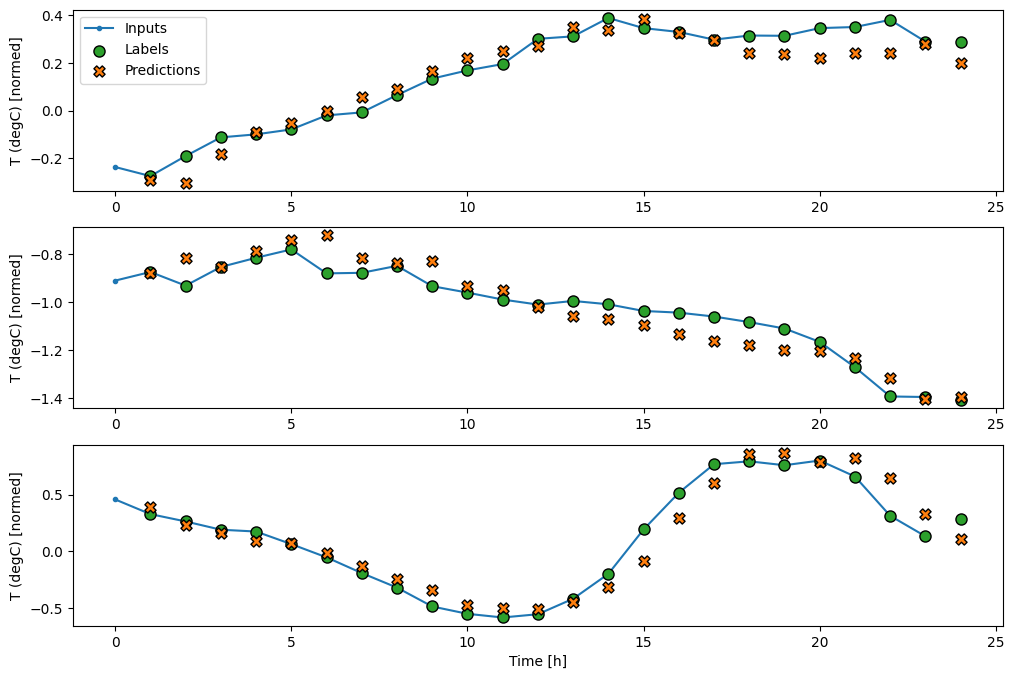

In [44]:
wide_window.plot(linear)

One advantage to linear models is that they're relatively simple to  interpret.
You can pull out the layer's weights and visualize the weight assigned to each input:

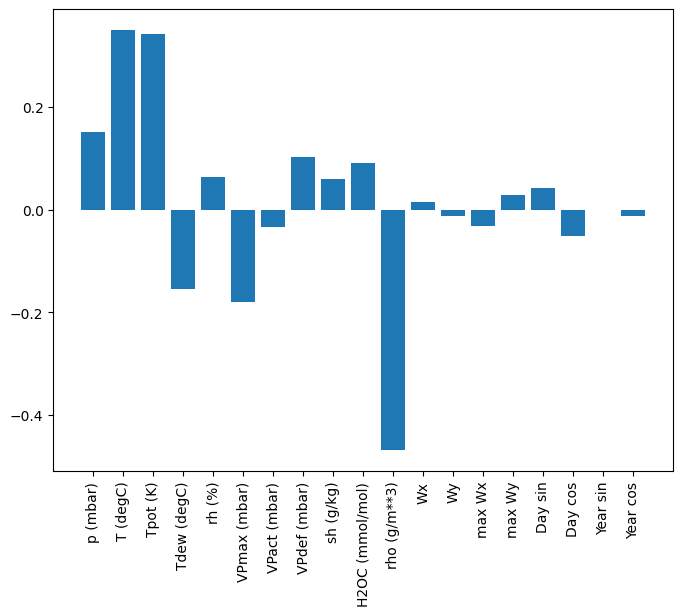

In [45]:
plt.bar(x = range(len(train_df.columns)),
        height=linear.layers[0].kernel[:,0].numpy())
axis = plt.gca()
axis.set_xticks(range(len(train_df.columns)))
_ = axis.set_xticklabels(train_df.columns, rotation=90)

Sometimes the model doesn't even place the most weight on the input `T (degC)`. This is one of the risks of random initialization. 

### Dense

Before applying models that actually operate on multiple time-steps, it's worth checking the performance of deeper, more powerful, single input step models.

Here's a model similar to the `linear` model, except it stacks several a few `Dense` layers between the input and the output: 

In [46]:
dense = tf.keras.Sequential([
    tf.keras.layers.Dense(units=64, activation='relu'),
    tf.keras.layers.Dense(units=64, activation='relu'),
    tf.keras.layers.Dense(units=1)
])

history = compile_and_fit(dense, single_step_window)

val_performance['Dense'] = dense.evaluate(single_step_window.val)
performance['Dense'] = dense.evaluate(single_step_window.test, verbose=0)

Epoch 1/20


   1/1534 [..............................] - ETA: 33:19 - loss: 2.2005 - mean_absolute_error: 1.1882

  16/1534 [..............................] - ETA: 5s - loss: 0.7024 - mean_absolute_error: 0.5700   

  31/1534 [..............................] - ETA: 5s - loss: 0.4030 - mean_absolute_error: 0.4007

  46/1534 [..............................] - ETA: 5s - loss: 0.2875 - mean_absolute_error: 0.3253

  62/1534 [>.............................] - ETA: 5s - loss: 0.2200 - mean_absolute_error: 0.2739

  77/1534 [>.............................] - ETA: 4s - loss: 0.1815 - mean_absolute_error: 0.2430

  93/1534 [>.............................] - ETA: 4s - loss: 0.1538 - mean_absolute_error: 0.2205

 108/1534 [=>............................] - ETA: 4s - loss: 0.1351 - mean_absolute_error: 0.2049

 123/1534 [=>............................] - ETA: 4s - loss: 0.1207 - mean_absolute_error: 0.1922

 138/1534 [=>............................] - ETA: 4s - loss: 0.1093 - mean_absolute_error: 0.1818

 154/1534 [==>...........................] - ETA: 4s - loss: 0.0994 - mean_absolute_error: 0.1722

 170/1534 [==>...........................] - ETA: 4s - loss: 0.0914 - mean_absolute_error: 0.1644

 185/1534 [==>...........................] - ETA: 4s - loss: 0.0851 - mean_absolute_error: 0.1584

 202/1534 [==>...........................] - ETA: 4s - loss: 0.0790 - mean_absolute_error: 0.1525

 218/1534 [===>..........................] - ETA: 4s - loss: 0.0742 - mean_absolute_error: 0.1478

 233/1534 [===>..........................] - ETA: 4s - loss: 0.0704 - mean_absolute_error: 0.1441

 248/1534 [===>..........................] - ETA: 4s - loss: 0.0669 - mean_absolute_error: 0.1405

 263/1534 [====>.........................] - ETA: 4s - loss: 0.0637 - mean_absolute_error: 0.1370

 279/1534 [====>.........................] - ETA: 4s - loss: 0.0608 - mean_absolute_error: 0.1342

 295/1534 [====>.........................] - ETA: 4s - loss: 0.0583 - mean_absolute_error: 0.1318

 310/1534 [=====>........................] - ETA: 4s - loss: 0.0560 - mean_absolute_error: 0.1293

 326/1534 [=====>........................] - ETA: 4s - loss: 0.0539 - mean_absolute_error: 0.1271

 341/1534 [=====>........................] - ETA: 3s - loss: 0.0520 - mean_absolute_error: 0.1250

 356/1534 [=====>........................] - ETA: 3s - loss: 0.0503 - mean_absolute_error: 0.1231

 371/1534 [======>.......................] - ETA: 3s - loss: 0.0489 - mean_absolute_error: 0.1217

 386/1534 [======>.......................] - ETA: 3s - loss: 0.0476 - mean_absolute_error: 0.1207

 401/1534 [======>.......................] - ETA: 3s - loss: 0.0463 - mean_absolute_error: 0.1192

 417/1534 [=======>......................] - ETA: 3s - loss: 0.0449 - mean_absolute_error: 0.1177

 433/1534 [=======>......................] - ETA: 3s - loss: 0.0436 - mean_absolute_error: 0.1161

 448/1534 [=======>......................] - ETA: 3s - loss: 0.0425 - mean_absolute_error: 0.1149

 464/1534 [========>.....................] - ETA: 3s - loss: 0.0414 - mean_absolute_error: 0.1136

 480/1534 [========>.....................] - ETA: 3s - loss: 0.0403 - mean_absolute_error: 0.1121

 496/1534 [========>.....................] - ETA: 3s - loss: 0.0394 - mean_absolute_error: 0.1110

 512/1534 [=========>....................] - ETA: 3s - loss: 0.0385 - mean_absolute_error: 0.1100

 527/1534 [=========>....................] - ETA: 3s - loss: 0.0377 - mean_absolute_error: 0.1089

 543/1534 [=========>....................] - ETA: 3s - loss: 0.0369 - mean_absolute_error: 0.1079

 559/1534 [=========>....................] - ETA: 3s - loss: 0.0362 - mean_absolute_error: 0.1069

 575/1534 [==========>...................] - ETA: 3s - loss: 0.0354 - mean_absolute_error: 0.1058

 591/1534 [==========>...................] - ETA: 3s - loss: 0.0347 - mean_absolute_error: 0.1048

 607/1534 [==========>...................] - ETA: 3s - loss: 0.0340 - mean_absolute_error: 0.1040

 622/1534 [===========>..................] - ETA: 3s - loss: 0.0334 - mean_absolute_error: 0.1032

 638/1534 [===========>..................] - ETA: 2s - loss: 0.0328 - mean_absolute_error: 0.1023

 654/1534 [===========>..................] - ETA: 2s - loss: 0.0322 - mean_absolute_error: 0.1014

 670/1534 [============>.................] - ETA: 2s - loss: 0.0316 - mean_absolute_error: 0.1007

 685/1534 [============>.................] - ETA: 2s - loss: 0.0312 - mean_absolute_error: 0.1001

 700/1534 [============>.................] - ETA: 2s - loss: 0.0307 - mean_absolute_error: 0.0996

 715/1534 [============>.................] - ETA: 2s - loss: 0.0303 - mean_absolute_error: 0.0991

 730/1534 [=============>................] - ETA: 2s - loss: 0.0299 - mean_absolute_error: 0.0987

 745/1534 [=============>................] - ETA: 2s - loss: 0.0295 - mean_absolute_error: 0.0981

 760/1534 [=============>................] - ETA: 2s - loss: 0.0291 - mean_absolute_error: 0.0976

 775/1534 [==============>...............] - ETA: 2s - loss: 0.0287 - mean_absolute_error: 0.0970

 791/1534 [==============>...............] - ETA: 2s - loss: 0.0283 - mean_absolute_error: 0.0964

 807/1534 [==============>...............] - ETA: 2s - loss: 0.0279 - mean_absolute_error: 0.0960

 822/1534 [===============>..............] - ETA: 2s - loss: 0.0276 - mean_absolute_error: 0.0956

 837/1534 [===============>..............] - ETA: 2s - loss: 0.0273 - mean_absolute_error: 0.0952

 852/1534 [===============>..............] - ETA: 2s - loss: 0.0269 - mean_absolute_error: 0.0948

 867/1534 [===============>..............] - ETA: 2s - loss: 0.0267 - mean_absolute_error: 0.0945

 883/1534 [================>.............] - ETA: 2s - loss: 0.0264 - mean_absolute_error: 0.0941

 898/1534 [================>.............] - ETA: 2s - loss: 0.0261 - mean_absolute_error: 0.0937

 914/1534 [================>.............] - ETA: 2s - loss: 0.0258 - mean_absolute_error: 0.0933

 929/1534 [=================>............] - ETA: 2s - loss: 0.0255 - mean_absolute_error: 0.0929

 944/1534 [=================>............] - ETA: 1s - loss: 0.0252 - mean_absolute_error: 0.0925

 959/1534 [=================>............] - ETA: 1s - loss: 0.0250 - mean_absolute_error: 0.0921

 974/1534 [==================>...........] - ETA: 1s - loss: 0.0247 - mean_absolute_error: 0.0917

 990/1534 [==================>...........] - ETA: 1s - loss: 0.0245 - mean_absolute_error: 0.0914

1006/1534 [==================>...........] - ETA: 1s - loss: 0.0242 - mean_absolute_error: 0.0910

1022/1534 [==================>...........] - ETA: 1s - loss: 0.0240 - mean_absolute_error: 0.0907

1038/1534 [===================>..........] - ETA: 1s - loss: 0.0237 - mean_absolute_error: 0.0903

1054/1534 [===================>..........] - ETA: 1s - loss: 0.0235 - mean_absolute_error: 0.0899

1070/1534 [===================>..........] - ETA: 1s - loss: 0.0232 - mean_absolute_error: 0.0895

1086/1534 [====================>.........] - ETA: 1s - loss: 0.0230 - mean_absolute_error: 0.0892

1101/1534 [====================>.........] - ETA: 1s - loss: 0.0228 - mean_absolute_error: 0.0890

1116/1534 [====================>.........] - ETA: 1s - loss: 0.0227 - mean_absolute_error: 0.0888

1132/1534 [=====================>........] - ETA: 1s - loss: 0.0225 - mean_absolute_error: 0.0885

1148/1534 [=====================>........] - ETA: 1s - loss: 0.0223 - mean_absolute_error: 0.0883

1164/1534 [=====================>........] - ETA: 1s - loss: 0.0221 - mean_absolute_error: 0.0880

1180/1534 [======================>.......] - ETA: 1s - loss: 0.0219 - mean_absolute_error: 0.0877

1196/1534 [======================>.......] - ETA: 1s - loss: 0.0217 - mean_absolute_error: 0.0874

1212/1534 [======================>.......] - ETA: 1s - loss: 0.0216 - mean_absolute_error: 0.0872

1228/1534 [=======================>......] - ETA: 1s - loss: 0.0214 - mean_absolute_error: 0.0870

1244/1534 [=======================>......] - ETA: 0s - loss: 0.0213 - mean_absolute_error: 0.0869

1259/1534 [=======================>......] - ETA: 0s - loss: 0.0212 - mean_absolute_error: 0.0867

1275/1534 [=======================>......] - ETA: 0s - loss: 0.0210 - mean_absolute_error: 0.0864

1291/1534 [========================>.....] - ETA: 0s - loss: 0.0208 - mean_absolute_error: 0.0861

1306/1534 [========================>.....] - ETA: 0s - loss: 0.0207 - mean_absolute_error: 0.0859

1321/1534 [========================>.....] - ETA: 0s - loss: 0.0205 - mean_absolute_error: 0.0857

1337/1534 [=========================>....] - ETA: 0s - loss: 0.0204 - mean_absolute_error: 0.0855

1352/1534 [=========================>....] - ETA: 0s - loss: 0.0203 - mean_absolute_error: 0.0853

1367/1534 [=========================>....] - ETA: 0s - loss: 0.0201 - mean_absolute_error: 0.0851

1383/1534 [==========================>...] - ETA: 0s - loss: 0.0200 - mean_absolute_error: 0.0849

1399/1534 [==========================>...] - ETA: 0s - loss: 0.0199 - mean_absolute_error: 0.0847

1415/1534 [==========================>...] - ETA: 0s - loss: 0.0197 - mean_absolute_error: 0.0845

1430/1534 [==========================>...] - ETA: 0s - loss: 0.0196 - mean_absolute_error: 0.0843

1446/1534 [===========================>..] - ETA: 0s - loss: 0.0195 - mean_absolute_error: 0.0841

1461/1534 [===========================>..] - ETA: 0s - loss: 0.0193 - mean_absolute_error: 0.0839

1477/1534 [===========================>..] - ETA: 0s - loss: 0.0192 - mean_absolute_error: 0.0837

1493/1534 [============================>.] - ETA: 0s - loss: 0.0191 - mean_absolute_error: 0.0835

1509/1534 [============================>.] - ETA: 0s - loss: 0.0190 - mean_absolute_error: 0.0833

1525/1534 [============================>.] - ETA: 0s - loss: 0.0189 - mean_absolute_error: 0.0831

1534/1534 [==============================] - 8s 4ms/step - loss: 0.0188 - mean_absolute_error: 0.0830 - val_loss: 0.0081 - val_mean_absolute_error: 0.0662


Epoch 2/20


   1/1534 [..............................] - ETA: 1:01 - loss: 0.0063 - mean_absolute_error: 0.0570

  16/1534 [..............................] - ETA: 5s - loss: 0.0073 - mean_absolute_error: 0.0649  

  31/1534 [..............................] - ETA: 5s - loss: 0.0075 - mean_absolute_error: 0.0651

  47/1534 [..............................] - ETA: 5s - loss: 0.0087 - mean_absolute_error: 0.0665

  62/1534 [>.............................] - ETA: 4s - loss: 0.0084 - mean_absolute_error: 0.0662

  77/1534 [>.............................] - ETA: 4s - loss: 0.0083 - mean_absolute_error: 0.0663

  93/1534 [>.............................] - ETA: 4s - loss: 0.0081 - mean_absolute_error: 0.0659

 109/1534 [=>............................] - ETA: 4s - loss: 0.0081 - mean_absolute_error: 0.0661

 125/1534 [=>............................] - ETA: 4s - loss: 0.0082 - mean_absolute_error: 0.0660

 140/1534 [=>............................] - ETA: 4s - loss: 0.0080 - mean_absolute_error: 0.0654

 156/1534 [==>...........................] - ETA: 4s - loss: 0.0080 - mean_absolute_error: 0.0652

 172/1534 [==>...........................] - ETA: 4s - loss: 0.0079 - mean_absolute_error: 0.0649

 188/1534 [==>...........................] - ETA: 4s - loss: 0.0078 - mean_absolute_error: 0.0646

 205/1534 [===>..........................] - ETA: 4s - loss: 0.0078 - mean_absolute_error: 0.0647

 221/1534 [===>..........................] - ETA: 4s - loss: 0.0078 - mean_absolute_error: 0.0650

 237/1534 [===>..........................] - ETA: 4s - loss: 0.0079 - mean_absolute_error: 0.0653

 253/1534 [===>..........................] - ETA: 4s - loss: 0.0079 - mean_absolute_error: 0.0653

 268/1534 [====>.........................] - ETA: 4s - loss: 0.0079 - mean_absolute_error: 0.0652

 283/1534 [====>.........................] - ETA: 4s - loss: 0.0079 - mean_absolute_error: 0.0651

 298/1534 [====>.........................] - ETA: 4s - loss: 0.0080 - mean_absolute_error: 0.0654

 314/1534 [=====>........................] - ETA: 4s - loss: 0.0080 - mean_absolute_error: 0.0651

 330/1534 [=====>........................] - ETA: 3s - loss: 0.0080 - mean_absolute_error: 0.0653

 346/1534 [=====>........................] - ETA: 3s - loss: 0.0080 - mean_absolute_error: 0.0653

 362/1534 [======>.......................] - ETA: 3s - loss: 0.0080 - mean_absolute_error: 0.0652

 378/1534 [======>.......................] - ETA: 3s - loss: 0.0080 - mean_absolute_error: 0.0652

 393/1534 [======>.......................] - ETA: 3s - loss: 0.0081 - mean_absolute_error: 0.0654

 408/1534 [======>.......................] - ETA: 3s - loss: 0.0080 - mean_absolute_error: 0.0652

 423/1534 [=======>......................] - ETA: 3s - loss: 0.0080 - mean_absolute_error: 0.0652

 438/1534 [=======>......................] - ETA: 3s - loss: 0.0080 - mean_absolute_error: 0.0653

 454/1534 [=======>......................] - ETA: 3s - loss: 0.0080 - mean_absolute_error: 0.0652

 470/1534 [========>.....................] - ETA: 3s - loss: 0.0080 - mean_absolute_error: 0.0653

 486/1534 [========>.....................] - ETA: 3s - loss: 0.0081 - mean_absolute_error: 0.0655

 501/1534 [========>.....................] - ETA: 3s - loss: 0.0081 - mean_absolute_error: 0.0656

 516/1534 [=========>....................] - ETA: 3s - loss: 0.0081 - mean_absolute_error: 0.0656

 532/1534 [=========>....................] - ETA: 3s - loss: 0.0081 - mean_absolute_error: 0.0657

 548/1534 [=========>....................] - ETA: 3s - loss: 0.0081 - mean_absolute_error: 0.0656

 564/1534 [==========>...................] - ETA: 3s - loss: 0.0081 - mean_absolute_error: 0.0655

 580/1534 [==========>...................] - ETA: 3s - loss: 0.0081 - mean_absolute_error: 0.0654

 596/1534 [==========>...................] - ETA: 3s - loss: 0.0081 - mean_absolute_error: 0.0654

 612/1534 [==========>...................] - ETA: 3s - loss: 0.0080 - mean_absolute_error: 0.0652

 628/1534 [===========>..................] - ETA: 2s - loss: 0.0080 - mean_absolute_error: 0.0652

 644/1534 [===========>..................] - ETA: 2s - loss: 0.0080 - mean_absolute_error: 0.0652

 660/1534 [===========>..................] - ETA: 2s - loss: 0.0080 - mean_absolute_error: 0.0651

 676/1534 [============>.................] - ETA: 2s - loss: 0.0080 - mean_absolute_error: 0.0651

 691/1534 [============>.................] - ETA: 2s - loss: 0.0080 - mean_absolute_error: 0.0651

 707/1534 [============>.................] - ETA: 2s - loss: 0.0080 - mean_absolute_error: 0.0651

 722/1534 [=============>................] - ETA: 2s - loss: 0.0080 - mean_absolute_error: 0.0651

 737/1534 [=============>................] - ETA: 2s - loss: 0.0080 - mean_absolute_error: 0.0652

 753/1534 [=============>................] - ETA: 2s - loss: 0.0080 - mean_absolute_error: 0.0652

 768/1534 [==============>...............] - ETA: 2s - loss: 0.0080 - mean_absolute_error: 0.0652

 783/1534 [==============>...............] - ETA: 2s - loss: 0.0080 - mean_absolute_error: 0.0651

 799/1534 [==============>...............] - ETA: 2s - loss: 0.0080 - mean_absolute_error: 0.0651

 814/1534 [==============>...............] - ETA: 2s - loss: 0.0080 - mean_absolute_error: 0.0652

 829/1534 [===============>..............] - ETA: 2s - loss: 0.0080 - mean_absolute_error: 0.0652

 845/1534 [===============>..............] - ETA: 2s - loss: 0.0080 - mean_absolute_error: 0.0652

 860/1534 [===============>..............] - ETA: 2s - loss: 0.0080 - mean_absolute_error: 0.0652

 875/1534 [================>.............] - ETA: 2s - loss: 0.0080 - mean_absolute_error: 0.0653

 890/1534 [================>.............] - ETA: 2s - loss: 0.0081 - mean_absolute_error: 0.0654

 905/1534 [================>.............] - ETA: 2s - loss: 0.0081 - mean_absolute_error: 0.0654

 921/1534 [=================>............] - ETA: 2s - loss: 0.0080 - mean_absolute_error: 0.0653

 937/1534 [=================>............] - ETA: 1s - loss: 0.0080 - mean_absolute_error: 0.0653

 953/1534 [=================>............] - ETA: 1s - loss: 0.0080 - mean_absolute_error: 0.0652

 969/1534 [=================>............] - ETA: 1s - loss: 0.0080 - mean_absolute_error: 0.0652

 985/1534 [==================>...........] - ETA: 1s - loss: 0.0080 - mean_absolute_error: 0.0651

1000/1534 [==================>...........] - ETA: 1s - loss: 0.0080 - mean_absolute_error: 0.0651

1016/1534 [==================>...........] - ETA: 1s - loss: 0.0080 - mean_absolute_error: 0.0651

1031/1534 [===================>..........] - ETA: 1s - loss: 0.0080 - mean_absolute_error: 0.0651

1046/1534 [===================>..........] - ETA: 1s - loss: 0.0080 - mean_absolute_error: 0.0650

1061/1534 [===================>..........] - ETA: 1s - loss: 0.0080 - mean_absolute_error: 0.0650

1076/1534 [====================>.........] - ETA: 1s - loss: 0.0079 - mean_absolute_error: 0.0650

1092/1534 [====================>.........] - ETA: 1s - loss: 0.0079 - mean_absolute_error: 0.0649

1108/1534 [====================>.........] - ETA: 1s - loss: 0.0079 - mean_absolute_error: 0.0649

1124/1534 [====================>.........] - ETA: 1s - loss: 0.0079 - mean_absolute_error: 0.0649

1139/1534 [=====================>........] - ETA: 1s - loss: 0.0079 - mean_absolute_error: 0.0649

1155/1534 [=====================>........] - ETA: 1s - loss: 0.0079 - mean_absolute_error: 0.0649

1171/1534 [=====================>........] - ETA: 1s - loss: 0.0080 - mean_absolute_error: 0.0649

1187/1534 [======================>.......] - ETA: 1s - loss: 0.0079 - mean_absolute_error: 0.0649

1203/1534 [======================>.......] - ETA: 1s - loss: 0.0079 - mean_absolute_error: 0.0649

1219/1534 [======================>.......] - ETA: 1s - loss: 0.0079 - mean_absolute_error: 0.0649

1235/1534 [=======================>......] - ETA: 0s - loss: 0.0080 - mean_absolute_error: 0.0649

1251/1534 [=======================>......] - ETA: 0s - loss: 0.0080 - mean_absolute_error: 0.0650

1267/1534 [=======================>......] - ETA: 0s - loss: 0.0080 - mean_absolute_error: 0.0649

1282/1534 [========================>.....] - ETA: 0s - loss: 0.0080 - mean_absolute_error: 0.0649

1297/1534 [========================>.....] - ETA: 0s - loss: 0.0080 - mean_absolute_error: 0.0649

1313/1534 [========================>.....] - ETA: 0s - loss: 0.0080 - mean_absolute_error: 0.0649

1329/1534 [========================>.....] - ETA: 0s - loss: 0.0080 - mean_absolute_error: 0.0649

1345/1534 [=========================>....] - ETA: 0s - loss: 0.0080 - mean_absolute_error: 0.0649

1361/1534 [=========================>....] - ETA: 0s - loss: 0.0080 - mean_absolute_error: 0.0649

1377/1534 [=========================>....] - ETA: 0s - loss: 0.0080 - mean_absolute_error: 0.0648

1393/1534 [==========================>...] - ETA: 0s - loss: 0.0079 - mean_absolute_error: 0.0648

1409/1534 [==========================>...] - ETA: 0s - loss: 0.0079 - mean_absolute_error: 0.0648

1425/1534 [==========================>...] - ETA: 0s - loss: 0.0079 - mean_absolute_error: 0.0647

1441/1534 [===========================>..] - ETA: 0s - loss: 0.0079 - mean_absolute_error: 0.0647

1457/1534 [===========================>..] - ETA: 0s - loss: 0.0079 - mean_absolute_error: 0.0647

1473/1534 [===========================>..] - ETA: 0s - loss: 0.0079 - mean_absolute_error: 0.0647

1489/1534 [============================>.] - ETA: 0s - loss: 0.0079 - mean_absolute_error: 0.0647

1504/1534 [============================>.] - ETA: 0s - loss: 0.0079 - mean_absolute_error: 0.0647

1519/1534 [============================>.] - ETA: 0s - loss: 0.0079 - mean_absolute_error: 0.0647

1534/1534 [==============================] - 6s 4ms/step - loss: 0.0079 - mean_absolute_error: 0.0647 - val_loss: 0.0073 - val_mean_absolute_error: 0.0623


Epoch 3/20


   1/1534 [..............................] - ETA: 59s - loss: 0.0081 - mean_absolute_error: 0.0647

  15/1534 [..............................] - ETA: 5s - loss: 0.0075 - mean_absolute_error: 0.0642 

  30/1534 [..............................] - ETA: 5s - loss: 0.0079 - mean_absolute_error: 0.0654

  45/1534 [..............................] - ETA: 5s - loss: 0.0084 - mean_absolute_error: 0.0653

  60/1534 [>.............................] - ETA: 5s - loss: 0.0081 - mean_absolute_error: 0.0650

  75/1534 [>.............................] - ETA: 4s - loss: 0.0078 - mean_absolute_error: 0.0644

  90/1534 [>.............................] - ETA: 4s - loss: 0.0077 - mean_absolute_error: 0.0637

 105/1534 [=>............................] - ETA: 4s - loss: 0.0078 - mean_absolute_error: 0.0643

 120/1534 [=>............................] - ETA: 4s - loss: 0.0077 - mean_absolute_error: 0.0643

 135/1534 [=>............................] - ETA: 4s - loss: 0.0078 - mean_absolute_error: 0.0645

 150/1534 [=>............................] - ETA: 4s - loss: 0.0077 - mean_absolute_error: 0.0642

 166/1534 [==>...........................] - ETA: 4s - loss: 0.0078 - mean_absolute_error: 0.0642

 181/1534 [==>...........................] - ETA: 4s - loss: 0.0076 - mean_absolute_error: 0.0637

 196/1534 [==>...........................] - ETA: 4s - loss: 0.0075 - mean_absolute_error: 0.0633

 211/1534 [===>..........................] - ETA: 4s - loss: 0.0075 - mean_absolute_error: 0.0635

 226/1534 [===>..........................] - ETA: 4s - loss: 0.0076 - mean_absolute_error: 0.0638

 241/1534 [===>..........................] - ETA: 4s - loss: 0.0077 - mean_absolute_error: 0.0640

 256/1534 [====>.........................] - ETA: 4s - loss: 0.0076 - mean_absolute_error: 0.0638

 272/1534 [====>.........................] - ETA: 4s - loss: 0.0076 - mean_absolute_error: 0.0637

 288/1534 [====>.........................] - ETA: 4s - loss: 0.0076 - mean_absolute_error: 0.0637

 304/1534 [====>.........................] - ETA: 4s - loss: 0.0076 - mean_absolute_error: 0.0636

 320/1534 [=====>........................] - ETA: 4s - loss: 0.0078 - mean_absolute_error: 0.0637

 335/1534 [=====>........................] - ETA: 4s - loss: 0.0077 - mean_absolute_error: 0.0637

 350/1534 [=====>........................] - ETA: 3s - loss: 0.0077 - mean_absolute_error: 0.0638

 366/1534 [======>.......................] - ETA: 3s - loss: 0.0077 - mean_absolute_error: 0.0638

 382/1534 [======>.......................] - ETA: 3s - loss: 0.0077 - mean_absolute_error: 0.0638

 399/1534 [======>.......................] - ETA: 3s - loss: 0.0077 - mean_absolute_error: 0.0636

 414/1534 [=======>......................] - ETA: 3s - loss: 0.0077 - mean_absolute_error: 0.0635

 429/1534 [=======>......................] - ETA: 3s - loss: 0.0076 - mean_absolute_error: 0.0634

 445/1534 [=======>......................] - ETA: 3s - loss: 0.0076 - mean_absolute_error: 0.0634

 460/1534 [=======>......................] - ETA: 3s - loss: 0.0076 - mean_absolute_error: 0.0634

 476/1534 [========>.....................] - ETA: 3s - loss: 0.0076 - mean_absolute_error: 0.0634

 492/1534 [========>.....................] - ETA: 3s - loss: 0.0077 - mean_absolute_error: 0.0635

 508/1534 [========>.....................] - ETA: 3s - loss: 0.0077 - mean_absolute_error: 0.0635

 524/1534 [=========>....................] - ETA: 3s - loss: 0.0076 - mean_absolute_error: 0.0634

 540/1534 [=========>....................] - ETA: 3s - loss: 0.0077 - mean_absolute_error: 0.0635

 556/1534 [=========>....................] - ETA: 3s - loss: 0.0077 - mean_absolute_error: 0.0634

 572/1534 [==========>...................] - ETA: 3s - loss: 0.0076 - mean_absolute_error: 0.0633

 588/1534 [==========>...................] - ETA: 3s - loss: 0.0076 - mean_absolute_error: 0.0632

 604/1534 [==========>...................] - ETA: 3s - loss: 0.0076 - mean_absolute_error: 0.0631

 620/1534 [===========>..................] - ETA: 3s - loss: 0.0076 - mean_absolute_error: 0.0632

 636/1534 [===========>..................] - ETA: 2s - loss: 0.0076 - mean_absolute_error: 0.0630

 652/1534 [===========>..................] - ETA: 2s - loss: 0.0075 - mean_absolute_error: 0.0629

 667/1534 [============>.................] - ETA: 2s - loss: 0.0075 - mean_absolute_error: 0.0629

 682/1534 [============>.................] - ETA: 2s - loss: 0.0075 - mean_absolute_error: 0.0629

 697/1534 [============>.................] - ETA: 2s - loss: 0.0076 - mean_absolute_error: 0.0630

 712/1534 [============>.................] - ETA: 2s - loss: 0.0076 - mean_absolute_error: 0.0631

 727/1534 [=============>................] - ETA: 2s - loss: 0.0076 - mean_absolute_error: 0.0633

 743/1534 [=============>................] - ETA: 2s - loss: 0.0076 - mean_absolute_error: 0.0633

 759/1534 [=============>................] - ETA: 2s - loss: 0.0076 - mean_absolute_error: 0.0632

 774/1534 [==============>...............] - ETA: 2s - loss: 0.0076 - mean_absolute_error: 0.0631

 789/1534 [==============>...............] - ETA: 2s - loss: 0.0075 - mean_absolute_error: 0.0630

 805/1534 [==============>...............] - ETA: 2s - loss: 0.0076 - mean_absolute_error: 0.0630

 820/1534 [===============>..............] - ETA: 2s - loss: 0.0076 - mean_absolute_error: 0.0630

 835/1534 [===============>..............] - ETA: 2s - loss: 0.0076 - mean_absolute_error: 0.0631

 850/1534 [===============>..............] - ETA: 2s - loss: 0.0076 - mean_absolute_error: 0.0631

 865/1534 [===============>..............] - ETA: 2s - loss: 0.0076 - mean_absolute_error: 0.0633

 880/1534 [================>.............] - ETA: 2s - loss: 0.0076 - mean_absolute_error: 0.0633

 895/1534 [================>.............] - ETA: 2s - loss: 0.0076 - mean_absolute_error: 0.0633

 910/1534 [================>.............] - ETA: 2s - loss: 0.0076 - mean_absolute_error: 0.0633

 925/1534 [=================>............] - ETA: 2s - loss: 0.0076 - mean_absolute_error: 0.0633

 940/1534 [=================>............] - ETA: 1s - loss: 0.0076 - mean_absolute_error: 0.0632

 955/1534 [=================>............] - ETA: 1s - loss: 0.0076 - mean_absolute_error: 0.0632

 970/1534 [=================>............] - ETA: 1s - loss: 0.0076 - mean_absolute_error: 0.0632

 985/1534 [==================>...........] - ETA: 1s - loss: 0.0076 - mean_absolute_error: 0.0632

1001/1534 [==================>...........] - ETA: 1s - loss: 0.0076 - mean_absolute_error: 0.0632

1017/1534 [==================>...........] - ETA: 1s - loss: 0.0076 - mean_absolute_error: 0.0631

1032/1534 [===================>..........] - ETA: 1s - loss: 0.0075 - mean_absolute_error: 0.0630

1048/1534 [===================>..........] - ETA: 1s - loss: 0.0075 - mean_absolute_error: 0.0629

1063/1534 [===================>..........] - ETA: 1s - loss: 0.0075 - mean_absolute_error: 0.0630

1079/1534 [====================>.........] - ETA: 1s - loss: 0.0075 - mean_absolute_error: 0.0629

1095/1534 [====================>.........] - ETA: 1s - loss: 0.0075 - mean_absolute_error: 0.0629

1111/1534 [====================>.........] - ETA: 1s - loss: 0.0075 - mean_absolute_error: 0.0629

1127/1534 [=====================>........] - ETA: 1s - loss: 0.0075 - mean_absolute_error: 0.0629

1143/1534 [=====================>........] - ETA: 1s - loss: 0.0075 - mean_absolute_error: 0.0630

1158/1534 [=====================>........] - ETA: 1s - loss: 0.0076 - mean_absolute_error: 0.0630

1174/1534 [=====================>........] - ETA: 1s - loss: 0.0076 - mean_absolute_error: 0.0629

1190/1534 [======================>.......] - ETA: 1s - loss: 0.0075 - mean_absolute_error: 0.0628

1206/1534 [======================>.......] - ETA: 1s - loss: 0.0075 - mean_absolute_error: 0.0628

1222/1534 [======================>.......] - ETA: 1s - loss: 0.0075 - mean_absolute_error: 0.0628

1238/1534 [=======================>......] - ETA: 0s - loss: 0.0076 - mean_absolute_error: 0.0629

1254/1534 [=======================>......] - ETA: 0s - loss: 0.0076 - mean_absolute_error: 0.0629

1269/1534 [=======================>......] - ETA: 0s - loss: 0.0076 - mean_absolute_error: 0.0629

1285/1534 [========================>.....] - ETA: 0s - loss: 0.0075 - mean_absolute_error: 0.0628

1300/1534 [========================>.....] - ETA: 0s - loss: 0.0075 - mean_absolute_error: 0.0629

1316/1534 [========================>.....] - ETA: 0s - loss: 0.0075 - mean_absolute_error: 0.0629

1331/1534 [=========================>....] - ETA: 0s - loss: 0.0076 - mean_absolute_error: 0.0629

1347/1534 [=========================>....] - ETA: 0s - loss: 0.0076 - mean_absolute_error: 0.0629

1363/1534 [=========================>....] - ETA: 0s - loss: 0.0076 - mean_absolute_error: 0.0628

1378/1534 [=========================>....] - ETA: 0s - loss: 0.0075 - mean_absolute_error: 0.0628

1394/1534 [==========================>...] - ETA: 0s - loss: 0.0076 - mean_absolute_error: 0.0628

1410/1534 [==========================>...] - ETA: 0s - loss: 0.0076 - mean_absolute_error: 0.0628

1426/1534 [==========================>...] - ETA: 0s - loss: 0.0076 - mean_absolute_error: 0.0629

1442/1534 [===========================>..] - ETA: 0s - loss: 0.0076 - mean_absolute_error: 0.0628

1458/1534 [===========================>..] - ETA: 0s - loss: 0.0075 - mean_absolute_error: 0.0628

1474/1534 [===========================>..] - ETA: 0s - loss: 0.0075 - mean_absolute_error: 0.0628

1490/1534 [============================>.] - ETA: 0s - loss: 0.0075 - mean_absolute_error: 0.0627

1505/1534 [============================>.] - ETA: 0s - loss: 0.0075 - mean_absolute_error: 0.0627

1521/1534 [============================>.] - ETA: 0s - loss: 0.0075 - mean_absolute_error: 0.0627

1534/1534 [==============================] - 6s 4ms/step - loss: 0.0075 - mean_absolute_error: 0.0627 - val_loss: 0.0073 - val_mean_absolute_error: 0.0616


Epoch 4/20


   1/1534 [..............................] - ETA: 58s - loss: 0.0103 - mean_absolute_error: 0.0713

  16/1534 [..............................] - ETA: 5s - loss: 0.0068 - mean_absolute_error: 0.0612 

  31/1534 [..............................] - ETA: 5s - loss: 0.0085 - mean_absolute_error: 0.0635

  46/1534 [..............................] - ETA: 5s - loss: 0.0078 - mean_absolute_error: 0.0624

  61/1534 [>.............................] - ETA: 4s - loss: 0.0078 - mean_absolute_error: 0.0626

  77/1534 [>.............................] - ETA: 4s - loss: 0.0077 - mean_absolute_error: 0.0627

  93/1534 [>.............................] - ETA: 4s - loss: 0.0074 - mean_absolute_error: 0.0621

 109/1534 [=>............................] - ETA: 4s - loss: 0.0073 - mean_absolute_error: 0.0618

 124/1534 [=>............................] - ETA: 4s - loss: 0.0074 - mean_absolute_error: 0.0625

 139/1534 [=>............................] - ETA: 4s - loss: 0.0074 - mean_absolute_error: 0.0624

 154/1534 [==>...........................] - ETA: 4s - loss: 0.0074 - mean_absolute_error: 0.0620

 169/1534 [==>...........................] - ETA: 4s - loss: 0.0073 - mean_absolute_error: 0.0616

 184/1534 [==>...........................] - ETA: 4s - loss: 0.0072 - mean_absolute_error: 0.0613

 199/1534 [==>...........................] - ETA: 4s - loss: 0.0072 - mean_absolute_error: 0.0614

 215/1534 [===>..........................] - ETA: 4s - loss: 0.0071 - mean_absolute_error: 0.0613

 231/1534 [===>..........................] - ETA: 4s - loss: 0.0072 - mean_absolute_error: 0.0614

 246/1534 [===>..........................] - ETA: 4s - loss: 0.0072 - mean_absolute_error: 0.0613

 261/1534 [====>.........................] - ETA: 4s - loss: 0.0072 - mean_absolute_error: 0.0613

 276/1534 [====>.........................] - ETA: 4s - loss: 0.0071 - mean_absolute_error: 0.0610

 292/1534 [====>.........................] - ETA: 4s - loss: 0.0072 - mean_absolute_error: 0.0613

 307/1534 [=====>........................] - ETA: 4s - loss: 0.0073 - mean_absolute_error: 0.0614

 322/1534 [=====>........................] - ETA: 4s - loss: 0.0074 - mean_absolute_error: 0.0616

 337/1534 [=====>........................] - ETA: 4s - loss: 0.0074 - mean_absolute_error: 0.0615

 353/1534 [=====>........................] - ETA: 3s - loss: 0.0073 - mean_absolute_error: 0.0614

 368/1534 [======>.......................] - ETA: 3s - loss: 0.0074 - mean_absolute_error: 0.0615

 384/1534 [======>.......................] - ETA: 3s - loss: 0.0074 - mean_absolute_error: 0.0616

 401/1534 [======>.......................] - ETA: 3s - loss: 0.0074 - mean_absolute_error: 0.0615

 417/1534 [=======>......................] - ETA: 3s - loss: 0.0073 - mean_absolute_error: 0.0613

 432/1534 [=======>......................] - ETA: 3s - loss: 0.0073 - mean_absolute_error: 0.0614

 447/1534 [=======>......................] - ETA: 3s - loss: 0.0073 - mean_absolute_error: 0.0612

 462/1534 [========>.....................] - ETA: 3s - loss: 0.0073 - mean_absolute_error: 0.0612

 477/1534 [========>.....................] - ETA: 3s - loss: 0.0073 - mean_absolute_error: 0.0613

 493/1534 [========>.....................] - ETA: 3s - loss: 0.0073 - mean_absolute_error: 0.0613

 508/1534 [========>.....................] - ETA: 3s - loss: 0.0073 - mean_absolute_error: 0.0613

 524/1534 [=========>....................] - ETA: 3s - loss: 0.0073 - mean_absolute_error: 0.0613

 540/1534 [=========>....................] - ETA: 3s - loss: 0.0073 - mean_absolute_error: 0.0612

 556/1534 [=========>....................] - ETA: 3s - loss: 0.0074 - mean_absolute_error: 0.0613

 571/1534 [==========>...................] - ETA: 3s - loss: 0.0074 - mean_absolute_error: 0.0614

 586/1534 [==========>...................] - ETA: 3s - loss: 0.0074 - mean_absolute_error: 0.0614

 602/1534 [==========>...................] - ETA: 3s - loss: 0.0073 - mean_absolute_error: 0.0613

 618/1534 [===========>..................] - ETA: 3s - loss: 0.0073 - mean_absolute_error: 0.0612

 634/1534 [===========>..................] - ETA: 2s - loss: 0.0073 - mean_absolute_error: 0.0612

 650/1534 [===========>..................] - ETA: 2s - loss: 0.0073 - mean_absolute_error: 0.0610

 666/1534 [============>.................] - ETA: 2s - loss: 0.0073 - mean_absolute_error: 0.0611

 682/1534 [============>.................] - ETA: 2s - loss: 0.0073 - mean_absolute_error: 0.0612

 698/1534 [============>.................] - ETA: 2s - loss: 0.0073 - mean_absolute_error: 0.0613

 714/1534 [============>.................] - ETA: 2s - loss: 0.0073 - mean_absolute_error: 0.0612

 730/1534 [=============>................] - ETA: 2s - loss: 0.0073 - mean_absolute_error: 0.0613

 746/1534 [=============>................] - ETA: 2s - loss: 0.0073 - mean_absolute_error: 0.0613

 762/1534 [=============>................] - ETA: 2s - loss: 0.0073 - mean_absolute_error: 0.0612

 777/1534 [==============>...............] - ETA: 2s - loss: 0.0073 - mean_absolute_error: 0.0611

 792/1534 [==============>...............] - ETA: 2s - loss: 0.0073 - mean_absolute_error: 0.0612

 807/1534 [==============>...............] - ETA: 2s - loss: 0.0073 - mean_absolute_error: 0.0612

 823/1534 [===============>..............] - ETA: 2s - loss: 0.0073 - mean_absolute_error: 0.0612

 838/1534 [===============>..............] - ETA: 2s - loss: 0.0073 - mean_absolute_error: 0.0612

 854/1534 [===============>..............] - ETA: 2s - loss: 0.0073 - mean_absolute_error: 0.0611

 870/1534 [================>.............] - ETA: 2s - loss: 0.0073 - mean_absolute_error: 0.0611

 886/1534 [================>.............] - ETA: 2s - loss: 0.0073 - mean_absolute_error: 0.0612

 902/1534 [================>.............] - ETA: 2s - loss: 0.0073 - mean_absolute_error: 0.0613

 918/1534 [================>.............] - ETA: 2s - loss: 0.0073 - mean_absolute_error: 0.0612

 934/1534 [=================>............] - ETA: 1s - loss: 0.0073 - mean_absolute_error: 0.0612

 949/1534 [=================>............] - ETA: 1s - loss: 0.0073 - mean_absolute_error: 0.0611

 964/1534 [=================>............] - ETA: 1s - loss: 0.0073 - mean_absolute_error: 0.0613

 980/1534 [==================>...........] - ETA: 1s - loss: 0.0073 - mean_absolute_error: 0.0613

 995/1534 [==================>...........] - ETA: 1s - loss: 0.0073 - mean_absolute_error: 0.0613

1011/1534 [==================>...........] - ETA: 1s - loss: 0.0073 - mean_absolute_error: 0.0612

1027/1534 [===================>..........] - ETA: 1s - loss: 0.0073 - mean_absolute_error: 0.0613

1043/1534 [===================>..........] - ETA: 1s - loss: 0.0073 - mean_absolute_error: 0.0612

1059/1534 [===================>..........] - ETA: 1s - loss: 0.0072 - mean_absolute_error: 0.0612

1075/1534 [====================>.........] - ETA: 1s - loss: 0.0073 - mean_absolute_error: 0.0612

1091/1534 [====================>.........] - ETA: 1s - loss: 0.0072 - mean_absolute_error: 0.0611

1107/1534 [====================>.........] - ETA: 1s - loss: 0.0072 - mean_absolute_error: 0.0611

1123/1534 [====================>.........] - ETA: 1s - loss: 0.0072 - mean_absolute_error: 0.0612

1139/1534 [=====================>........] - ETA: 1s - loss: 0.0072 - mean_absolute_error: 0.0611

1154/1534 [=====================>........] - ETA: 1s - loss: 0.0073 - mean_absolute_error: 0.0612

1170/1534 [=====================>........] - ETA: 1s - loss: 0.0073 - mean_absolute_error: 0.0613

1186/1534 [======================>.......] - ETA: 1s - loss: 0.0073 - mean_absolute_error: 0.0612

1202/1534 [======================>.......] - ETA: 1s - loss: 0.0073 - mean_absolute_error: 0.0612

1218/1534 [======================>.......] - ETA: 1s - loss: 0.0073 - mean_absolute_error: 0.0612

1233/1534 [=======================>......] - ETA: 0s - loss: 0.0073 - mean_absolute_error: 0.0613

1249/1534 [=======================>......] - ETA: 0s - loss: 0.0074 - mean_absolute_error: 0.0614

1264/1534 [=======================>......] - ETA: 0s - loss: 0.0073 - mean_absolute_error: 0.0613

1279/1534 [========================>.....] - ETA: 0s - loss: 0.0073 - mean_absolute_error: 0.0613

1294/1534 [========================>.....] - ETA: 0s - loss: 0.0073 - mean_absolute_error: 0.0612

1309/1534 [========================>.....] - ETA: 0s - loss: 0.0073 - mean_absolute_error: 0.0613

1325/1534 [========================>.....] - ETA: 0s - loss: 0.0073 - mean_absolute_error: 0.0613

1341/1534 [=========================>....] - ETA: 0s - loss: 0.0073 - mean_absolute_error: 0.0613

1357/1534 [=========================>....] - ETA: 0s - loss: 0.0073 - mean_absolute_error: 0.0613

1372/1534 [=========================>....] - ETA: 0s - loss: 0.0073 - mean_absolute_error: 0.0612

1388/1534 [==========================>...] - ETA: 0s - loss: 0.0073 - mean_absolute_error: 0.0613

1404/1534 [==========================>...] - ETA: 0s - loss: 0.0073 - mean_absolute_error: 0.0613

1420/1534 [==========================>...] - ETA: 0s - loss: 0.0073 - mean_absolute_error: 0.0612

1436/1534 [===========================>..] - ETA: 0s - loss: 0.0073 - mean_absolute_error: 0.0612

1451/1534 [===========================>..] - ETA: 0s - loss: 0.0073 - mean_absolute_error: 0.0612

1466/1534 [===========================>..] - ETA: 0s - loss: 0.0073 - mean_absolute_error: 0.0611

1482/1534 [===========================>..] - ETA: 0s - loss: 0.0073 - mean_absolute_error: 0.0612

1498/1534 [============================>.] - ETA: 0s - loss: 0.0073 - mean_absolute_error: 0.0611

1513/1534 [============================>.] - ETA: 0s - loss: 0.0073 - mean_absolute_error: 0.0611

1529/1534 [============================>.] - ETA: 0s - loss: 0.0073 - mean_absolute_error: 0.0611

1534/1534 [==============================] - 6s 4ms/step - loss: 0.0073 - mean_absolute_error: 0.0611 - val_loss: 0.0071 - val_mean_absolute_error: 0.0618


Epoch 5/20


   1/1534 [..............................] - ETA: 58s - loss: 0.0039 - mean_absolute_error: 0.0472

  16/1534 [..............................] - ETA: 5s - loss: 0.0059 - mean_absolute_error: 0.0587 

  31/1534 [..............................] - ETA: 5s - loss: 0.0080 - mean_absolute_error: 0.0621

  46/1534 [..............................] - ETA: 5s - loss: 0.0076 - mean_absolute_error: 0.0615

  62/1534 [>.............................] - ETA: 5s - loss: 0.0076 - mean_absolute_error: 0.0625

  78/1534 [>.............................] - ETA: 4s - loss: 0.0074 - mean_absolute_error: 0.0619

  93/1534 [>.............................] - ETA: 4s - loss: 0.0072 - mean_absolute_error: 0.0614

 108/1534 [=>............................] - ETA: 4s - loss: 0.0072 - mean_absolute_error: 0.0614

 123/1534 [=>............................] - ETA: 4s - loss: 0.0072 - mean_absolute_error: 0.0614

 138/1534 [=>............................] - ETA: 4s - loss: 0.0072 - mean_absolute_error: 0.0613

 154/1534 [==>...........................] - ETA: 4s - loss: 0.0071 - mean_absolute_error: 0.0608

 170/1534 [==>...........................] - ETA: 4s - loss: 0.0071 - mean_absolute_error: 0.0607

 186/1534 [==>...........................] - ETA: 4s - loss: 0.0070 - mean_absolute_error: 0.0605

 202/1534 [==>...........................] - ETA: 4s - loss: 0.0070 - mean_absolute_error: 0.0606

 218/1534 [===>..........................] - ETA: 4s - loss: 0.0070 - mean_absolute_error: 0.0603

 233/1534 [===>..........................] - ETA: 4s - loss: 0.0070 - mean_absolute_error: 0.0604

 248/1534 [===>..........................] - ETA: 4s - loss: 0.0070 - mean_absolute_error: 0.0604

 264/1534 [====>.........................] - ETA: 4s - loss: 0.0070 - mean_absolute_error: 0.0604

 280/1534 [====>.........................] - ETA: 4s - loss: 0.0071 - mean_absolute_error: 0.0606

 296/1534 [====>.........................] - ETA: 4s - loss: 0.0071 - mean_absolute_error: 0.0608

 312/1534 [=====>........................] - ETA: 4s - loss: 0.0072 - mean_absolute_error: 0.0610

 328/1534 [=====>........................] - ETA: 4s - loss: 0.0073 - mean_absolute_error: 0.0612

 343/1534 [=====>........................] - ETA: 3s - loss: 0.0072 - mean_absolute_error: 0.0610

 358/1534 [======>.......................] - ETA: 3s - loss: 0.0072 - mean_absolute_error: 0.0608

 374/1534 [======>.......................] - ETA: 3s - loss: 0.0072 - mean_absolute_error: 0.0609

 389/1534 [======>.......................] - ETA: 3s - loss: 0.0073 - mean_absolute_error: 0.0611

 404/1534 [======>.......................] - ETA: 3s - loss: 0.0073 - mean_absolute_error: 0.0611

 420/1534 [=======>......................] - ETA: 3s - loss: 0.0072 - mean_absolute_error: 0.0610

 436/1534 [=======>......................] - ETA: 3s - loss: 0.0072 - mean_absolute_error: 0.0610

 452/1534 [=======>......................] - ETA: 3s - loss: 0.0072 - mean_absolute_error: 0.0609

 468/1534 [========>.....................] - ETA: 3s - loss: 0.0071 - mean_absolute_error: 0.0608

 483/1534 [========>.....................] - ETA: 3s - loss: 0.0072 - mean_absolute_error: 0.0608

 499/1534 [========>.....................] - ETA: 3s - loss: 0.0072 - mean_absolute_error: 0.0609

 514/1534 [=========>....................] - ETA: 3s - loss: 0.0072 - mean_absolute_error: 0.0608

 530/1534 [=========>....................] - ETA: 3s - loss: 0.0072 - mean_absolute_error: 0.0607

 545/1534 [=========>....................] - ETA: 3s - loss: 0.0072 - mean_absolute_error: 0.0607

 560/1534 [=========>....................] - ETA: 3s - loss: 0.0072 - mean_absolute_error: 0.0607

 576/1534 [==========>...................] - ETA: 3s - loss: 0.0072 - mean_absolute_error: 0.0606

 592/1534 [==========>...................] - ETA: 3s - loss: 0.0072 - mean_absolute_error: 0.0606

 608/1534 [==========>...................] - ETA: 3s - loss: 0.0071 - mean_absolute_error: 0.0605

 623/1534 [===========>..................] - ETA: 3s - loss: 0.0071 - mean_absolute_error: 0.0605

 639/1534 [===========>..................] - ETA: 2s - loss: 0.0071 - mean_absolute_error: 0.0604

 655/1534 [===========>..................] - ETA: 2s - loss: 0.0071 - mean_absolute_error: 0.0603

 671/1534 [============>.................] - ETA: 2s - loss: 0.0071 - mean_absolute_error: 0.0602

 687/1534 [============>.................] - ETA: 2s - loss: 0.0071 - mean_absolute_error: 0.0603

 702/1534 [============>.................] - ETA: 2s - loss: 0.0071 - mean_absolute_error: 0.0603

 718/1534 [=============>................] - ETA: 2s - loss: 0.0071 - mean_absolute_error: 0.0603

 734/1534 [=============>................] - ETA: 2s - loss: 0.0071 - mean_absolute_error: 0.0604

 749/1534 [=============>................] - ETA: 2s - loss: 0.0071 - mean_absolute_error: 0.0603

 764/1534 [=============>................] - ETA: 2s - loss: 0.0071 - mean_absolute_error: 0.0603

 780/1534 [==============>...............] - ETA: 2s - loss: 0.0071 - mean_absolute_error: 0.0603

 796/1534 [==============>...............] - ETA: 2s - loss: 0.0071 - mean_absolute_error: 0.0604

 812/1534 [==============>...............] - ETA: 2s - loss: 0.0071 - mean_absolute_error: 0.0604

 827/1534 [===============>..............] - ETA: 2s - loss: 0.0071 - mean_absolute_error: 0.0604

 843/1534 [===============>..............] - ETA: 2s - loss: 0.0071 - mean_absolute_error: 0.0604

 858/1534 [===============>..............] - ETA: 2s - loss: 0.0071 - mean_absolute_error: 0.0604

 873/1534 [================>.............] - ETA: 2s - loss: 0.0071 - mean_absolute_error: 0.0604

 889/1534 [================>.............] - ETA: 2s - loss: 0.0071 - mean_absolute_error: 0.0605

 905/1534 [================>.............] - ETA: 2s - loss: 0.0071 - mean_absolute_error: 0.0605

 921/1534 [=================>............] - ETA: 2s - loss: 0.0071 - mean_absolute_error: 0.0604

 936/1534 [=================>............] - ETA: 1s - loss: 0.0071 - mean_absolute_error: 0.0604

 952/1534 [=================>............] - ETA: 1s - loss: 0.0071 - mean_absolute_error: 0.0604

 968/1534 [=================>............] - ETA: 1s - loss: 0.0071 - mean_absolute_error: 0.0604

 984/1534 [==================>...........] - ETA: 1s - loss: 0.0071 - mean_absolute_error: 0.0604

 999/1534 [==================>...........] - ETA: 1s - loss: 0.0071 - mean_absolute_error: 0.0604

1015/1534 [==================>...........] - ETA: 1s - loss: 0.0071 - mean_absolute_error: 0.0604

1031/1534 [===================>..........] - ETA: 1s - loss: 0.0071 - mean_absolute_error: 0.0604

1047/1534 [===================>..........] - ETA: 1s - loss: 0.0071 - mean_absolute_error: 0.0603

1063/1534 [===================>..........] - ETA: 1s - loss: 0.0071 - mean_absolute_error: 0.0603

1079/1534 [====================>.........] - ETA: 1s - loss: 0.0071 - mean_absolute_error: 0.0603

1094/1534 [====================>.........] - ETA: 1s - loss: 0.0070 - mean_absolute_error: 0.0602

1109/1534 [====================>.........] - ETA: 1s - loss: 0.0070 - mean_absolute_error: 0.0602

1125/1534 [=====================>........] - ETA: 1s - loss: 0.0070 - mean_absolute_error: 0.0602

1141/1534 [=====================>........] - ETA: 1s - loss: 0.0071 - mean_absolute_error: 0.0602

1157/1534 [=====================>........] - ETA: 1s - loss: 0.0071 - mean_absolute_error: 0.0604

1173/1534 [=====================>........] - ETA: 1s - loss: 0.0071 - mean_absolute_error: 0.0605

1189/1534 [======================>.......] - ETA: 1s - loss: 0.0071 - mean_absolute_error: 0.0604

1205/1534 [======================>.......] - ETA: 1s - loss: 0.0071 - mean_absolute_error: 0.0604

1221/1534 [======================>.......] - ETA: 1s - loss: 0.0071 - mean_absolute_error: 0.0604

1237/1534 [=======================>......] - ETA: 0s - loss: 0.0071 - mean_absolute_error: 0.0604

1253/1534 [=======================>......] - ETA: 0s - loss: 0.0071 - mean_absolute_error: 0.0605

1269/1534 [=======================>......] - ETA: 0s - loss: 0.0071 - mean_absolute_error: 0.0605

1285/1534 [========================>.....] - ETA: 0s - loss: 0.0071 - mean_absolute_error: 0.0604

1301/1534 [========================>.....] - ETA: 0s - loss: 0.0071 - mean_absolute_error: 0.0604

1317/1534 [========================>.....] - ETA: 0s - loss: 0.0071 - mean_absolute_error: 0.0605

1332/1534 [=========================>....] - ETA: 0s - loss: 0.0071 - mean_absolute_error: 0.0604

1347/1534 [=========================>....] - ETA: 0s - loss: 0.0071 - mean_absolute_error: 0.0604

1363/1534 [=========================>....] - ETA: 0s - loss: 0.0071 - mean_absolute_error: 0.0604

1379/1534 [=========================>....] - ETA: 0s - loss: 0.0071 - mean_absolute_error: 0.0604

1395/1534 [==========================>...] - ETA: 0s - loss: 0.0071 - mean_absolute_error: 0.0604

1411/1534 [==========================>...] - ETA: 0s - loss: 0.0071 - mean_absolute_error: 0.0604

1426/1534 [==========================>...] - ETA: 0s - loss: 0.0071 - mean_absolute_error: 0.0604

1442/1534 [===========================>..] - ETA: 0s - loss: 0.0071 - mean_absolute_error: 0.0604

1458/1534 [===========================>..] - ETA: 0s - loss: 0.0071 - mean_absolute_error: 0.0604

1474/1534 [===========================>..] - ETA: 0s - loss: 0.0071 - mean_absolute_error: 0.0604

1489/1534 [============================>.] - ETA: 0s - loss: 0.0071 - mean_absolute_error: 0.0603

1504/1534 [============================>.] - ETA: 0s - loss: 0.0071 - mean_absolute_error: 0.0603

1519/1534 [============================>.] - ETA: 0s - loss: 0.0071 - mean_absolute_error: 0.0603

1534/1534 [==============================] - 6s 4ms/step - loss: 0.0071 - mean_absolute_error: 0.0603 - val_loss: 0.0072 - val_mean_absolute_error: 0.0613


Epoch 6/20


   1/1534 [..............................] - ETA: 59s - loss: 0.0075 - mean_absolute_error: 0.0616

  16/1534 [..............................] - ETA: 5s - loss: 0.0057 - mean_absolute_error: 0.0568 

  32/1534 [..............................] - ETA: 5s - loss: 0.0081 - mean_absolute_error: 0.0609

  48/1534 [..............................] - ETA: 4s - loss: 0.0074 - mean_absolute_error: 0.0600

  64/1534 [>.............................] - ETA: 4s - loss: 0.0071 - mean_absolute_error: 0.0598

  80/1534 [>.............................] - ETA: 4s - loss: 0.0070 - mean_absolute_error: 0.0600

  96/1534 [>.............................] - ETA: 4s - loss: 0.0072 - mean_absolute_error: 0.0603

 112/1534 [=>............................] - ETA: 4s - loss: 0.0071 - mean_absolute_error: 0.0602

 128/1534 [=>............................] - ETA: 4s - loss: 0.0070 - mean_absolute_error: 0.0601

 144/1534 [=>............................] - ETA: 4s - loss: 0.0070 - mean_absolute_error: 0.0597

 159/1534 [==>...........................] - ETA: 4s - loss: 0.0069 - mean_absolute_error: 0.0596

 174/1534 [==>...........................] - ETA: 4s - loss: 0.0069 - mean_absolute_error: 0.0594

 190/1534 [==>...........................] - ETA: 4s - loss: 0.0068 - mean_absolute_error: 0.0592

 206/1534 [===>..........................] - ETA: 4s - loss: 0.0068 - mean_absolute_error: 0.0594

 222/1534 [===>..........................] - ETA: 4s - loss: 0.0068 - mean_absolute_error: 0.0594

 238/1534 [===>..........................] - ETA: 4s - loss: 0.0069 - mean_absolute_error: 0.0594

 254/1534 [===>..........................] - ETA: 4s - loss: 0.0069 - mean_absolute_error: 0.0594

 270/1534 [====>.........................] - ETA: 4s - loss: 0.0068 - mean_absolute_error: 0.0594

 286/1534 [====>.........................] - ETA: 4s - loss: 0.0069 - mean_absolute_error: 0.0593

 302/1534 [====>.........................] - ETA: 4s - loss: 0.0069 - mean_absolute_error: 0.0594

 318/1534 [=====>........................] - ETA: 3s - loss: 0.0069 - mean_absolute_error: 0.0594

 334/1534 [=====>........................] - ETA: 3s - loss: 0.0069 - mean_absolute_error: 0.0593

 350/1534 [=====>........................] - ETA: 3s - loss: 0.0069 - mean_absolute_error: 0.0593

 366/1534 [======>.......................] - ETA: 3s - loss: 0.0069 - mean_absolute_error: 0.0593

 382/1534 [======>.......................] - ETA: 3s - loss: 0.0070 - mean_absolute_error: 0.0594

 398/1534 [======>.......................] - ETA: 3s - loss: 0.0069 - mean_absolute_error: 0.0594

 414/1534 [=======>......................] - ETA: 3s - loss: 0.0069 - mean_absolute_error: 0.0594

 429/1534 [=======>......................] - ETA: 3s - loss: 0.0069 - mean_absolute_error: 0.0593

 444/1534 [=======>......................] - ETA: 3s - loss: 0.0069 - mean_absolute_error: 0.0592

 459/1534 [=======>......................] - ETA: 3s - loss: 0.0069 - mean_absolute_error: 0.0593

 474/1534 [========>.....................] - ETA: 3s - loss: 0.0070 - mean_absolute_error: 0.0595

 490/1534 [========>.....................] - ETA: 3s - loss: 0.0070 - mean_absolute_error: 0.0595

 506/1534 [========>.....................] - ETA: 3s - loss: 0.0070 - mean_absolute_error: 0.0596

 522/1534 [=========>....................] - ETA: 3s - loss: 0.0070 - mean_absolute_error: 0.0597

 538/1534 [=========>....................] - ETA: 3s - loss: 0.0070 - mean_absolute_error: 0.0596

 554/1534 [=========>....................] - ETA: 3s - loss: 0.0070 - mean_absolute_error: 0.0597

 570/1534 [==========>...................] - ETA: 3s - loss: 0.0070 - mean_absolute_error: 0.0596

 586/1534 [==========>...................] - ETA: 3s - loss: 0.0070 - mean_absolute_error: 0.0594

 602/1534 [==========>...................] - ETA: 3s - loss: 0.0069 - mean_absolute_error: 0.0593

 617/1534 [===========>..................] - ETA: 3s - loss: 0.0069 - mean_absolute_error: 0.0593

 633/1534 [===========>..................] - ETA: 2s - loss: 0.0069 - mean_absolute_error: 0.0593

 649/1534 [===========>..................] - ETA: 2s - loss: 0.0069 - mean_absolute_error: 0.0592

 665/1534 [============>.................] - ETA: 2s - loss: 0.0069 - mean_absolute_error: 0.0592

 681/1534 [============>.................] - ETA: 2s - loss: 0.0069 - mean_absolute_error: 0.0593

 697/1534 [============>.................] - ETA: 2s - loss: 0.0069 - mean_absolute_error: 0.0593

 712/1534 [============>.................] - ETA: 2s - loss: 0.0069 - mean_absolute_error: 0.0593

 727/1534 [=============>................] - ETA: 2s - loss: 0.0069 - mean_absolute_error: 0.0593

 743/1534 [=============>................] - ETA: 2s - loss: 0.0069 - mean_absolute_error: 0.0593

 758/1534 [=============>................] - ETA: 2s - loss: 0.0069 - mean_absolute_error: 0.0592

 774/1534 [==============>...............] - ETA: 2s - loss: 0.0069 - mean_absolute_error: 0.0590

 789/1534 [==============>...............] - ETA: 2s - loss: 0.0069 - mean_absolute_error: 0.0591

 804/1534 [==============>...............] - ETA: 2s - loss: 0.0069 - mean_absolute_error: 0.0592

 820/1534 [===============>..............] - ETA: 2s - loss: 0.0069 - mean_absolute_error: 0.0592

 836/1534 [===============>..............] - ETA: 2s - loss: 0.0069 - mean_absolute_error: 0.0592

 852/1534 [===============>..............] - ETA: 2s - loss: 0.0069 - mean_absolute_error: 0.0592

 868/1534 [===============>..............] - ETA: 2s - loss: 0.0069 - mean_absolute_error: 0.0592

 884/1534 [================>.............] - ETA: 2s - loss: 0.0069 - mean_absolute_error: 0.0593

 900/1534 [================>.............] - ETA: 2s - loss: 0.0069 - mean_absolute_error: 0.0593

 916/1534 [================>.............] - ETA: 2s - loss: 0.0069 - mean_absolute_error: 0.0593

 932/1534 [=================>............] - ETA: 1s - loss: 0.0069 - mean_absolute_error: 0.0593

 948/1534 [=================>............] - ETA: 1s - loss: 0.0069 - mean_absolute_error: 0.0593

 964/1534 [=================>............] - ETA: 1s - loss: 0.0069 - mean_absolute_error: 0.0593

 980/1534 [==================>...........] - ETA: 1s - loss: 0.0069 - mean_absolute_error: 0.0594

 996/1534 [==================>...........] - ETA: 1s - loss: 0.0069 - mean_absolute_error: 0.0593

1012/1534 [==================>...........] - ETA: 1s - loss: 0.0069 - mean_absolute_error: 0.0593

1028/1534 [===================>..........] - ETA: 1s - loss: 0.0069 - mean_absolute_error: 0.0593

1044/1534 [===================>..........] - ETA: 1s - loss: 0.0069 - mean_absolute_error: 0.0593

1060/1534 [===================>..........] - ETA: 1s - loss: 0.0069 - mean_absolute_error: 0.0592

1076/1534 [====================>.........] - ETA: 1s - loss: 0.0069 - mean_absolute_error: 0.0593

1091/1534 [====================>.........] - ETA: 1s - loss: 0.0069 - mean_absolute_error: 0.0593

1107/1534 [====================>.........] - ETA: 1s - loss: 0.0069 - mean_absolute_error: 0.0593

1123/1534 [====================>.........] - ETA: 1s - loss: 0.0069 - mean_absolute_error: 0.0592

1139/1534 [=====================>........] - ETA: 1s - loss: 0.0069 - mean_absolute_error: 0.0593

1155/1534 [=====================>........] - ETA: 1s - loss: 0.0069 - mean_absolute_error: 0.0594

1171/1534 [=====================>........] - ETA: 1s - loss: 0.0069 - mean_absolute_error: 0.0594

1187/1534 [======================>.......] - ETA: 1s - loss: 0.0069 - mean_absolute_error: 0.0594

1203/1534 [======================>.......] - ETA: 1s - loss: 0.0069 - mean_absolute_error: 0.0593

1219/1534 [======================>.......] - ETA: 1s - loss: 0.0069 - mean_absolute_error: 0.0593

1235/1534 [=======================>......] - ETA: 0s - loss: 0.0069 - mean_absolute_error: 0.0594

1251/1534 [=======================>......] - ETA: 0s - loss: 0.0070 - mean_absolute_error: 0.0595

1267/1534 [=======================>......] - ETA: 0s - loss: 0.0070 - mean_absolute_error: 0.0594

1282/1534 [========================>.....] - ETA: 0s - loss: 0.0069 - mean_absolute_error: 0.0594

1298/1534 [========================>.....] - ETA: 0s - loss: 0.0069 - mean_absolute_error: 0.0594

1313/1534 [========================>.....] - ETA: 0s - loss: 0.0069 - mean_absolute_error: 0.0594

1329/1534 [========================>.....] - ETA: 0s - loss: 0.0069 - mean_absolute_error: 0.0595

1345/1534 [=========================>....] - ETA: 0s - loss: 0.0070 - mean_absolute_error: 0.0595

1361/1534 [=========================>....] - ETA: 0s - loss: 0.0069 - mean_absolute_error: 0.0594

1377/1534 [=========================>....] - ETA: 0s - loss: 0.0069 - mean_absolute_error: 0.0594

1393/1534 [==========================>...] - ETA: 0s - loss: 0.0069 - mean_absolute_error: 0.0594

1409/1534 [==========================>...] - ETA: 0s - loss: 0.0070 - mean_absolute_error: 0.0595

1425/1534 [==========================>...] - ETA: 0s - loss: 0.0070 - mean_absolute_error: 0.0595

1440/1534 [===========================>..] - ETA: 0s - loss: 0.0069 - mean_absolute_error: 0.0594

1456/1534 [===========================>..] - ETA: 0s - loss: 0.0069 - mean_absolute_error: 0.0594

1472/1534 [===========================>..] - ETA: 0s - loss: 0.0069 - mean_absolute_error: 0.0594

1488/1534 [============================>.] - ETA: 0s - loss: 0.0069 - mean_absolute_error: 0.0593

1503/1534 [============================>.] - ETA: 0s - loss: 0.0069 - mean_absolute_error: 0.0593

1518/1534 [============================>.] - ETA: 0s - loss: 0.0069 - mean_absolute_error: 0.0593

1534/1534 [==============================] - ETA: 0s - loss: 0.0069 - mean_absolute_error: 0.0593

1534/1534 [==============================] - 6s 4ms/step - loss: 0.0069 - mean_absolute_error: 0.0593 - val_loss: 0.0066 - val_mean_absolute_error: 0.0571


Epoch 7/20


   1/1534 [..............................] - ETA: 58s - loss: 0.0056 - mean_absolute_error: 0.0615

  15/1534 [..............................] - ETA: 5s - loss: 0.0053 - mean_absolute_error: 0.0551 

  31/1534 [..............................] - ETA: 5s - loss: 0.0075 - mean_absolute_error: 0.0590

  46/1534 [..............................] - ETA: 5s - loss: 0.0072 - mean_absolute_error: 0.0593

  61/1534 [>.............................] - ETA: 5s - loss: 0.0073 - mean_absolute_error: 0.0603

  77/1534 [>.............................] - ETA: 4s - loss: 0.0070 - mean_absolute_error: 0.0596

  93/1534 [>.............................] - ETA: 4s - loss: 0.0069 - mean_absolute_error: 0.0596

 109/1534 [=>............................] - ETA: 4s - loss: 0.0070 - mean_absolute_error: 0.0598

 125/1534 [=>............................] - ETA: 4s - loss: 0.0071 - mean_absolute_error: 0.0607

 140/1534 [=>............................] - ETA: 4s - loss: 0.0070 - mean_absolute_error: 0.0601

 156/1534 [==>...........................] - ETA: 4s - loss: 0.0071 - mean_absolute_error: 0.0604

 172/1534 [==>...........................] - ETA: 4s - loss: 0.0070 - mean_absolute_error: 0.0602

 188/1534 [==>...........................] - ETA: 4s - loss: 0.0069 - mean_absolute_error: 0.0599

 205/1534 [===>..........................] - ETA: 4s - loss: 0.0069 - mean_absolute_error: 0.0601

 221/1534 [===>..........................] - ETA: 4s - loss: 0.0070 - mean_absolute_error: 0.0602

 236/1534 [===>..........................] - ETA: 4s - loss: 0.0070 - mean_absolute_error: 0.0602

 251/1534 [===>..........................] - ETA: 4s - loss: 0.0069 - mean_absolute_error: 0.0600

 267/1534 [====>.........................] - ETA: 4s - loss: 0.0069 - mean_absolute_error: 0.0599

 283/1534 [====>.........................] - ETA: 4s - loss: 0.0069 - mean_absolute_error: 0.0597

 299/1534 [====>.........................] - ETA: 4s - loss: 0.0070 - mean_absolute_error: 0.0599

 315/1534 [=====>........................] - ETA: 4s - loss: 0.0070 - mean_absolute_error: 0.0598

 331/1534 [=====>........................] - ETA: 3s - loss: 0.0070 - mean_absolute_error: 0.0598

 346/1534 [=====>........................] - ETA: 3s - loss: 0.0070 - mean_absolute_error: 0.0596

 361/1534 [======>.......................] - ETA: 3s - loss: 0.0069 - mean_absolute_error: 0.0595

 377/1534 [======>.......................] - ETA: 3s - loss: 0.0070 - mean_absolute_error: 0.0595

 392/1534 [======>.......................] - ETA: 3s - loss: 0.0070 - mean_absolute_error: 0.0595

 407/1534 [======>.......................] - ETA: 3s - loss: 0.0070 - mean_absolute_error: 0.0597

 422/1534 [=======>......................] - ETA: 3s - loss: 0.0070 - mean_absolute_error: 0.0597

 438/1534 [=======>......................] - ETA: 3s - loss: 0.0069 - mean_absolute_error: 0.0597

 454/1534 [=======>......................] - ETA: 3s - loss: 0.0069 - mean_absolute_error: 0.0594

 470/1534 [========>.....................] - ETA: 3s - loss: 0.0069 - mean_absolute_error: 0.0594

 485/1534 [========>.....................] - ETA: 3s - loss: 0.0069 - mean_absolute_error: 0.0596

 501/1534 [========>.....................] - ETA: 3s - loss: 0.0069 - mean_absolute_error: 0.0596

 517/1534 [=========>....................] - ETA: 3s - loss: 0.0069 - mean_absolute_error: 0.0597

 533/1534 [=========>....................] - ETA: 3s - loss: 0.0069 - mean_absolute_error: 0.0597

 549/1534 [=========>....................] - ETA: 3s - loss: 0.0070 - mean_absolute_error: 0.0597

 565/1534 [==========>...................] - ETA: 3s - loss: 0.0070 - mean_absolute_error: 0.0598

 581/1534 [==========>...................] - ETA: 3s - loss: 0.0070 - mean_absolute_error: 0.0597

 597/1534 [==========>...................] - ETA: 3s - loss: 0.0070 - mean_absolute_error: 0.0597

 612/1534 [==========>...................] - ETA: 3s - loss: 0.0069 - mean_absolute_error: 0.0596

 628/1534 [===========>..................] - ETA: 2s - loss: 0.0069 - mean_absolute_error: 0.0596

 643/1534 [===========>..................] - ETA: 2s - loss: 0.0069 - mean_absolute_error: 0.0595

 658/1534 [===========>..................] - ETA: 2s - loss: 0.0069 - mean_absolute_error: 0.0594

 674/1534 [============>.................] - ETA: 2s - loss: 0.0069 - mean_absolute_error: 0.0594

 689/1534 [============>.................] - ETA: 2s - loss: 0.0069 - mean_absolute_error: 0.0594

 704/1534 [============>.................] - ETA: 2s - loss: 0.0069 - mean_absolute_error: 0.0594

 719/1534 [=============>................] - ETA: 2s - loss: 0.0069 - mean_absolute_error: 0.0595

 735/1534 [=============>................] - ETA: 2s - loss: 0.0069 - mean_absolute_error: 0.0594

 750/1534 [=============>................] - ETA: 2s - loss: 0.0069 - mean_absolute_error: 0.0593

 765/1534 [=============>................] - ETA: 2s - loss: 0.0069 - mean_absolute_error: 0.0593

 780/1534 [==============>...............] - ETA: 2s - loss: 0.0068 - mean_absolute_error: 0.0592

 795/1534 [==============>...............] - ETA: 2s - loss: 0.0069 - mean_absolute_error: 0.0592

 810/1534 [==============>...............] - ETA: 2s - loss: 0.0069 - mean_absolute_error: 0.0593

 826/1534 [===============>..............] - ETA: 2s - loss: 0.0069 - mean_absolute_error: 0.0592

 841/1534 [===============>..............] - ETA: 2s - loss: 0.0069 - mean_absolute_error: 0.0593

 856/1534 [===============>..............] - ETA: 2s - loss: 0.0069 - mean_absolute_error: 0.0592

 871/1534 [================>.............] - ETA: 2s - loss: 0.0069 - mean_absolute_error: 0.0592

 886/1534 [================>.............] - ETA: 2s - loss: 0.0069 - mean_absolute_error: 0.0593

 902/1534 [================>.............] - ETA: 2s - loss: 0.0069 - mean_absolute_error: 0.0593

 917/1534 [================>.............] - ETA: 2s - loss: 0.0069 - mean_absolute_error: 0.0593

 933/1534 [=================>............] - ETA: 1s - loss: 0.0069 - mean_absolute_error: 0.0592

 948/1534 [=================>............] - ETA: 1s - loss: 0.0069 - mean_absolute_error: 0.0593

 964/1534 [=================>............] - ETA: 1s - loss: 0.0069 - mean_absolute_error: 0.0593

 979/1534 [==================>...........] - ETA: 1s - loss: 0.0069 - mean_absolute_error: 0.0593

 995/1534 [==================>...........] - ETA: 1s - loss: 0.0069 - mean_absolute_error: 0.0592

1010/1534 [==================>...........] - ETA: 1s - loss: 0.0068 - mean_absolute_error: 0.0592

1025/1534 [===================>..........] - ETA: 1s - loss: 0.0069 - mean_absolute_error: 0.0592

1040/1534 [===================>..........] - ETA: 1s - loss: 0.0068 - mean_absolute_error: 0.0592

1055/1534 [===================>..........] - ETA: 1s - loss: 0.0068 - mean_absolute_error: 0.0591

1071/1534 [===================>..........] - ETA: 1s - loss: 0.0068 - mean_absolute_error: 0.0591

1087/1534 [====================>.........] - ETA: 1s - loss: 0.0068 - mean_absolute_error: 0.0590

1102/1534 [====================>.........] - ETA: 1s - loss: 0.0068 - mean_absolute_error: 0.0590

1117/1534 [====================>.........] - ETA: 1s - loss: 0.0068 - mean_absolute_error: 0.0590

1133/1534 [=====================>........] - ETA: 1s - loss: 0.0068 - mean_absolute_error: 0.0591

1149/1534 [=====================>........] - ETA: 1s - loss: 0.0068 - mean_absolute_error: 0.0591

1164/1534 [=====================>........] - ETA: 1s - loss: 0.0069 - mean_absolute_error: 0.0591

1180/1534 [======================>.......] - ETA: 1s - loss: 0.0068 - mean_absolute_error: 0.0591

1195/1534 [======================>.......] - ETA: 1s - loss: 0.0068 - mean_absolute_error: 0.0590

1210/1534 [======================>.......] - ETA: 1s - loss: 0.0068 - mean_absolute_error: 0.0590

1225/1534 [======================>.......] - ETA: 1s - loss: 0.0069 - mean_absolute_error: 0.0591

1240/1534 [=======================>......] - ETA: 0s - loss: 0.0069 - mean_absolute_error: 0.0592

1256/1534 [=======================>......] - ETA: 0s - loss: 0.0069 - mean_absolute_error: 0.0592

1272/1534 [=======================>......] - ETA: 0s - loss: 0.0069 - mean_absolute_error: 0.0591

1288/1534 [========================>.....] - ETA: 0s - loss: 0.0069 - mean_absolute_error: 0.0591

1303/1534 [========================>.....] - ETA: 0s - loss: 0.0069 - mean_absolute_error: 0.0590

1319/1534 [========================>.....] - ETA: 0s - loss: 0.0069 - mean_absolute_error: 0.0591

1335/1534 [=========================>....] - ETA: 0s - loss: 0.0069 - mean_absolute_error: 0.0591

1351/1534 [=========================>....] - ETA: 0s - loss: 0.0069 - mean_absolute_error: 0.0591

1366/1534 [=========================>....] - ETA: 0s - loss: 0.0069 - mean_absolute_error: 0.0591

1381/1534 [==========================>...] - ETA: 0s - loss: 0.0069 - mean_absolute_error: 0.0590

1396/1534 [==========================>...] - ETA: 0s - loss: 0.0069 - mean_absolute_error: 0.0590

1411/1534 [==========================>...] - ETA: 0s - loss: 0.0069 - mean_absolute_error: 0.0590

1426/1534 [==========================>...] - ETA: 0s - loss: 0.0069 - mean_absolute_error: 0.0590

1441/1534 [===========================>..] - ETA: 0s - loss: 0.0068 - mean_absolute_error: 0.0590

1457/1534 [===========================>..] - ETA: 0s - loss: 0.0068 - mean_absolute_error: 0.0589

1473/1534 [===========================>..] - ETA: 0s - loss: 0.0068 - mean_absolute_error: 0.0589

1489/1534 [============================>.] - ETA: 0s - loss: 0.0068 - mean_absolute_error: 0.0589

1505/1534 [============================>.] - ETA: 0s - loss: 0.0068 - mean_absolute_error: 0.0589

1521/1534 [============================>.] - ETA: 0s - loss: 0.0068 - mean_absolute_error: 0.0589

1534/1534 [==============================] - 6s 4ms/step - loss: 0.0068 - mean_absolute_error: 0.0589 - val_loss: 0.0066 - val_mean_absolute_error: 0.0585


Epoch 8/20


   1/1534 [..............................] - ETA: 59s - loss: 0.0028 - mean_absolute_error: 0.0413

  16/1534 [..............................] - ETA: 5s - loss: 0.0053 - mean_absolute_error: 0.0541 

  32/1534 [..............................] - ETA: 5s - loss: 0.0074 - mean_absolute_error: 0.0587

  48/1534 [..............................] - ETA: 4s - loss: 0.0068 - mean_absolute_error: 0.0578

  64/1534 [>.............................] - ETA: 4s - loss: 0.0069 - mean_absolute_error: 0.0590

  80/1534 [>.............................] - ETA: 4s - loss: 0.0069 - mean_absolute_error: 0.0596

  95/1534 [>.............................] - ETA: 4s - loss: 0.0069 - mean_absolute_error: 0.0595

 111/1534 [=>............................] - ETA: 4s - loss: 0.0068 - mean_absolute_error: 0.0596

 127/1534 [=>............................] - ETA: 4s - loss: 0.0070 - mean_absolute_error: 0.0601

 143/1534 [=>............................] - ETA: 4s - loss: 0.0069 - mean_absolute_error: 0.0597

 158/1534 [==>...........................] - ETA: 4s - loss: 0.0068 - mean_absolute_error: 0.0594

 174/1534 [==>...........................] - ETA: 4s - loss: 0.0068 - mean_absolute_error: 0.0591

 190/1534 [==>...........................] - ETA: 4s - loss: 0.0067 - mean_absolute_error: 0.0590

 206/1534 [===>..........................] - ETA: 4s - loss: 0.0066 - mean_absolute_error: 0.0589

 222/1534 [===>..........................] - ETA: 4s - loss: 0.0067 - mean_absolute_error: 0.0588

 238/1534 [===>..........................] - ETA: 4s - loss: 0.0067 - mean_absolute_error: 0.0588

 253/1534 [===>..........................] - ETA: 4s - loss: 0.0067 - mean_absolute_error: 0.0587

 269/1534 [====>.........................] - ETA: 4s - loss: 0.0066 - mean_absolute_error: 0.0586

 284/1534 [====>.........................] - ETA: 4s - loss: 0.0067 - mean_absolute_error: 0.0587

 299/1534 [====>.........................] - ETA: 4s - loss: 0.0067 - mean_absolute_error: 0.0587

 315/1534 [=====>........................] - ETA: 4s - loss: 0.0068 - mean_absolute_error: 0.0586

 331/1534 [=====>........................] - ETA: 3s - loss: 0.0068 - mean_absolute_error: 0.0586

 347/1534 [=====>........................] - ETA: 3s - loss: 0.0068 - mean_absolute_error: 0.0586

 362/1534 [======>.......................] - ETA: 3s - loss: 0.0067 - mean_absolute_error: 0.0584

 378/1534 [======>.......................] - ETA: 3s - loss: 0.0068 - mean_absolute_error: 0.0585

 394/1534 [======>.......................] - ETA: 3s - loss: 0.0068 - mean_absolute_error: 0.0587

 410/1534 [=======>......................] - ETA: 3s - loss: 0.0068 - mean_absolute_error: 0.0587

 426/1534 [=======>......................] - ETA: 3s - loss: 0.0068 - mean_absolute_error: 0.0586

 441/1534 [=======>......................] - ETA: 3s - loss: 0.0068 - mean_absolute_error: 0.0587

 456/1534 [=======>......................] - ETA: 3s - loss: 0.0067 - mean_absolute_error: 0.0585

 471/1534 [========>.....................] - ETA: 3s - loss: 0.0068 - mean_absolute_error: 0.0586

 487/1534 [========>.....................] - ETA: 3s - loss: 0.0068 - mean_absolute_error: 0.0585

 503/1534 [========>.....................] - ETA: 3s - loss: 0.0068 - mean_absolute_error: 0.0585

 519/1534 [=========>....................] - ETA: 3s - loss: 0.0068 - mean_absolute_error: 0.0585

 535/1534 [=========>....................] - ETA: 3s - loss: 0.0068 - mean_absolute_error: 0.0586

 551/1534 [=========>....................] - ETA: 3s - loss: 0.0068 - mean_absolute_error: 0.0588

 567/1534 [==========>...................] - ETA: 3s - loss: 0.0069 - mean_absolute_error: 0.0589

 583/1534 [==========>...................] - ETA: 3s - loss: 0.0068 - mean_absolute_error: 0.0588

 599/1534 [==========>...................] - ETA: 3s - loss: 0.0068 - mean_absolute_error: 0.0587

 615/1534 [===========>..................] - ETA: 3s - loss: 0.0068 - mean_absolute_error: 0.0587

 631/1534 [===========>..................] - ETA: 2s - loss: 0.0068 - mean_absolute_error: 0.0587

 646/1534 [===========>..................] - ETA: 2s - loss: 0.0067 - mean_absolute_error: 0.0585

 661/1534 [===========>..................] - ETA: 2s - loss: 0.0067 - mean_absolute_error: 0.0584

 676/1534 [============>.................] - ETA: 2s - loss: 0.0067 - mean_absolute_error: 0.0584

 692/1534 [============>.................] - ETA: 2s - loss: 0.0067 - mean_absolute_error: 0.0584

 707/1534 [============>.................] - ETA: 2s - loss: 0.0068 - mean_absolute_error: 0.0584

 723/1534 [=============>................] - ETA: 2s - loss: 0.0068 - mean_absolute_error: 0.0586

 739/1534 [=============>................] - ETA: 2s - loss: 0.0068 - mean_absolute_error: 0.0586

 755/1534 [=============>................] - ETA: 2s - loss: 0.0068 - mean_absolute_error: 0.0586

 771/1534 [==============>...............] - ETA: 2s - loss: 0.0067 - mean_absolute_error: 0.0584

 786/1534 [==============>...............] - ETA: 2s - loss: 0.0067 - mean_absolute_error: 0.0583

 802/1534 [==============>...............] - ETA: 2s - loss: 0.0067 - mean_absolute_error: 0.0584

 817/1534 [==============>...............] - ETA: 2s - loss: 0.0068 - mean_absolute_error: 0.0585

 833/1534 [===============>..............] - ETA: 2s - loss: 0.0068 - mean_absolute_error: 0.0585

 849/1534 [===============>..............] - ETA: 2s - loss: 0.0067 - mean_absolute_error: 0.0584

 865/1534 [===============>..............] - ETA: 2s - loss: 0.0068 - mean_absolute_error: 0.0585

 881/1534 [================>.............] - ETA: 2s - loss: 0.0068 - mean_absolute_error: 0.0585

 897/1534 [================>.............] - ETA: 2s - loss: 0.0068 - mean_absolute_error: 0.0586

 913/1534 [================>.............] - ETA: 2s - loss: 0.0068 - mean_absolute_error: 0.0586

 929/1534 [=================>............] - ETA: 1s - loss: 0.0068 - mean_absolute_error: 0.0585

 945/1534 [=================>............] - ETA: 1s - loss: 0.0068 - mean_absolute_error: 0.0585

 961/1534 [=================>............] - ETA: 1s - loss: 0.0068 - mean_absolute_error: 0.0586

 977/1534 [==================>...........] - ETA: 1s - loss: 0.0068 - mean_absolute_error: 0.0586

 993/1534 [==================>...........] - ETA: 1s - loss: 0.0068 - mean_absolute_error: 0.0586

1009/1534 [==================>...........] - ETA: 1s - loss: 0.0068 - mean_absolute_error: 0.0586

1024/1534 [===================>..........] - ETA: 1s - loss: 0.0068 - mean_absolute_error: 0.0585

1039/1534 [===================>..........] - ETA: 1s - loss: 0.0067 - mean_absolute_error: 0.0584

1055/1534 [===================>..........] - ETA: 1s - loss: 0.0067 - mean_absolute_error: 0.0584

1071/1534 [===================>..........] - ETA: 1s - loss: 0.0067 - mean_absolute_error: 0.0585

1087/1534 [====================>.........] - ETA: 1s - loss: 0.0067 - mean_absolute_error: 0.0584

1103/1534 [====================>.........] - ETA: 1s - loss: 0.0067 - mean_absolute_error: 0.0584

1119/1534 [====================>.........] - ETA: 1s - loss: 0.0067 - mean_absolute_error: 0.0584

1135/1534 [=====================>........] - ETA: 1s - loss: 0.0067 - mean_absolute_error: 0.0584

1151/1534 [=====================>........] - ETA: 1s - loss: 0.0067 - mean_absolute_error: 0.0585

1166/1534 [=====================>........] - ETA: 1s - loss: 0.0068 - mean_absolute_error: 0.0585

1182/1534 [======================>.......] - ETA: 1s - loss: 0.0068 - mean_absolute_error: 0.0584

1197/1534 [======================>.......] - ETA: 1s - loss: 0.0068 - mean_absolute_error: 0.0584

1212/1534 [======================>.......] - ETA: 1s - loss: 0.0068 - mean_absolute_error: 0.0584

1228/1534 [=======================>......] - ETA: 1s - loss: 0.0067 - mean_absolute_error: 0.0584

1243/1534 [=======================>......] - ETA: 0s - loss: 0.0068 - mean_absolute_error: 0.0585

1258/1534 [=======================>......] - ETA: 0s - loss: 0.0068 - mean_absolute_error: 0.0585

1273/1534 [=======================>......] - ETA: 0s - loss: 0.0068 - mean_absolute_error: 0.0584

1288/1534 [========================>.....] - ETA: 0s - loss: 0.0068 - mean_absolute_error: 0.0585

1303/1534 [========================>.....] - ETA: 0s - loss: 0.0068 - mean_absolute_error: 0.0585

1318/1534 [========================>.....] - ETA: 0s - loss: 0.0068 - mean_absolute_error: 0.0585

1333/1534 [=========================>....] - ETA: 0s - loss: 0.0068 - mean_absolute_error: 0.0585

1349/1534 [=========================>....] - ETA: 0s - loss: 0.0068 - mean_absolute_error: 0.0585

1364/1534 [=========================>....] - ETA: 0s - loss: 0.0068 - mean_absolute_error: 0.0585

1380/1534 [=========================>....] - ETA: 0s - loss: 0.0068 - mean_absolute_error: 0.0585

1395/1534 [==========================>...] - ETA: 0s - loss: 0.0068 - mean_absolute_error: 0.0585

1410/1534 [==========================>...] - ETA: 0s - loss: 0.0068 - mean_absolute_error: 0.0585

1425/1534 [==========================>...] - ETA: 0s - loss: 0.0068 - mean_absolute_error: 0.0585

1440/1534 [===========================>..] - ETA: 0s - loss: 0.0068 - mean_absolute_error: 0.0585

1455/1534 [===========================>..] - ETA: 0s - loss: 0.0068 - mean_absolute_error: 0.0584

1470/1534 [===========================>..] - ETA: 0s - loss: 0.0068 - mean_absolute_error: 0.0584

1485/1534 [============================>.] - ETA: 0s - loss: 0.0068 - mean_absolute_error: 0.0584

1500/1534 [============================>.] - ETA: 0s - loss: 0.0068 - mean_absolute_error: 0.0584

1515/1534 [============================>.] - ETA: 0s - loss: 0.0068 - mean_absolute_error: 0.0584

1531/1534 [============================>.] - ETA: 0s - loss: 0.0068 - mean_absolute_error: 0.0584

1534/1534 [==============================] - 6s 4ms/step - loss: 0.0068 - mean_absolute_error: 0.0584 - val_loss: 0.0068 - val_mean_absolute_error: 0.0575


  1/439 [..............................] - ETA: 35s - loss: 0.0112 - mean_absolute_error: 0.0658

 20/439 [>.............................] - ETA: 1s - loss: 0.0059 - mean_absolute_error: 0.0550 

 41/439 [=>............................] - ETA: 1s - loss: 0.0065 - mean_absolute_error: 0.0573

 61/439 [===>..........................] - ETA: 0s - loss: 0.0067 - mean_absolute_error: 0.0578

 82/439 [====>.........................] - ETA: 0s - loss: 0.0065 - mean_absolute_error: 0.0572

103/439 [======>.......................] - ETA: 0s - loss: 0.0066 - mean_absolute_error: 0.0574

124/439 [=======>......................] - ETA: 0s - loss: 0.0068 - mean_absolute_error: 0.0581

145/439 [========>.....................] - ETA: 0s - loss: 0.0068 - mean_absolute_error: 0.0580

166/439 [==========>...................] - ETA: 0s - loss: 0.0070 - mean_absolute_error: 0.0584

186/439 [===========>..................] - ETA: 0s - loss: 0.0070 - mean_absolute_error: 0.0584

208/439 [=============>................] - ETA: 0s - loss: 0.0069 - mean_absolute_error: 0.0581

229/439 [==============>...............] - ETA: 0s - loss: 0.0068 - mean_absolute_error: 0.0579

250/439 [================>.............] - ETA: 0s - loss: 0.0069 - mean_absolute_error: 0.0580

272/439 [=================>............] - ETA: 0s - loss: 0.0068 - mean_absolute_error: 0.0577

293/439 [===================>..........] - ETA: 0s - loss: 0.0068 - mean_absolute_error: 0.0576

314/439 [====================>.........] - ETA: 0s - loss: 0.0068 - mean_absolute_error: 0.0577

336/439 [=====================>........] - ETA: 0s - loss: 0.0068 - mean_absolute_error: 0.0577

357/439 [=======================>......] - ETA: 0s - loss: 0.0067 - mean_absolute_error: 0.0574

378/439 [========================>.....] - ETA: 0s - loss: 0.0068 - mean_absolute_error: 0.0573

399/439 [==========================>...] - ETA: 0s - loss: 0.0068 - mean_absolute_error: 0.0574

420/439 [===========================>..] - ETA: 0s - loss: 0.0068 - mean_absolute_error: 0.0575

439/439 [==============================] - 1s 2ms/step - loss: 0.0068 - mean_absolute_error: 0.0575


### Multi-step dense

A single-time-step model has no context for the current values of its inputs. It can't see how the input features are changing over time. To address this issue the model needs access to multiple time steps when making predictions:

![Three time steps are used for each prediction.](images/conv_window.png)


The `baseline`, `linear` and `dense` models handled each time step independently. Here the model will take multiple time steps as input to produce a single output.

Create a `WindowGenerator` that will produce batches of three-hour inputs and one-hour labels:

Note that the `Window`'s `shift` parameter is relative to the end of the two windows.


In [47]:
CONV_WIDTH = 3
conv_window = WindowGenerator(
    input_width=CONV_WIDTH,
    label_width=1,
    shift=1,
    label_columns=['T (degC)'])

conv_window

Total window size: 4
Input indices: [0 1 2]
Label indices: [3]
Label column name(s): ['T (degC)']

Text(0.5, 1.0, 'Given 3 hours of inputs, predict 1 hour into the future.')

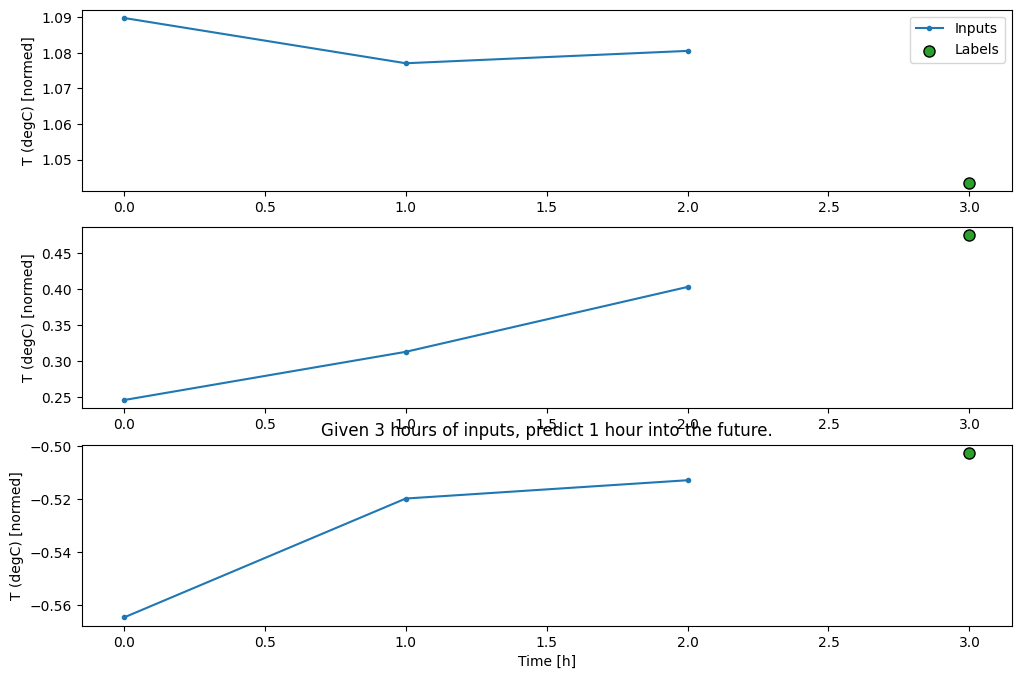

In [48]:
conv_window.plot()
plt.title("Given 3 hours of inputs, predict 1 hour into the future.")

You could train a `dense` model on a multiple-input-step window by adding a `tf.keras.layers.Flatten` as the first layer of the model:

In [49]:
multi_step_dense = tf.keras.Sequential([
    # Shape: (time, features) => (time*features)
    tf.keras.layers.Flatten(),
    tf.keras.layers.Dense(units=32, activation='relu'),
    tf.keras.layers.Dense(units=32, activation='relu'),
    tf.keras.layers.Dense(units=1),
    # Add back the time dimension.
    # Shape: (outputs) => (1, outputs)
    tf.keras.layers.Reshape([1, -1]),
])

In [50]:
print('Input shape:', conv_window.example[0].shape)
print('Output shape:', multi_step_dense(conv_window.example[0]).shape)

Input shape: (32, 3, 19)
Output shape: (32, 1, 1)


In [51]:
history = compile_and_fit(multi_step_dense, conv_window)

IPython.display.clear_output()
val_performance['Multi step dense'] = multi_step_dense.evaluate(conv_window.val)
performance['Multi step dense'] = multi_step_dense.evaluate(conv_window.test, verbose=0)

  1/438 [..............................] - ETA: 35s - loss: 0.0052 - mean_absolute_error: 0.0573

 26/438 [>.............................] - ETA: 0s - loss: 0.0066 - mean_absolute_error: 0.0539 

 53/438 [==>...........................] - ETA: 0s - loss: 0.0064 - mean_absolute_error: 0.0548

 81/438 [====>.........................] - ETA: 0s - loss: 0.0064 - mean_absolute_error: 0.0550

109/438 [======>.......................] - ETA: 0s - loss: 0.0063 - mean_absolute_error: 0.0547

136/438 [========>.....................] - ETA: 0s - loss: 0.0063 - mean_absolute_error: 0.0552

163/438 [==========>...................] - ETA: 0s - loss: 0.0064 - mean_absolute_error: 0.0556

190/438 [============>.................] - ETA: 0s - loss: 0.0065 - mean_absolute_error: 0.0560

217/438 [=============>................] - ETA: 0s - loss: 0.0064 - mean_absolute_error: 0.0560

244/438 [===============>..............] - ETA: 0s - loss: 0.0064 - mean_absolute_error: 0.0561

271/438 [=================>............] - ETA: 0s - loss: 0.0064 - mean_absolute_error: 0.0563

299/438 [===================>..........] - ETA: 0s - loss: 0.0064 - mean_absolute_error: 0.0560

328/438 [=====================>........] - ETA: 0s - loss: 0.0065 - mean_absolute_error: 0.0564

357/438 [=======================>......] - ETA: 0s - loss: 0.0065 - mean_absolute_error: 0.0564

384/438 [=========================>....] - ETA: 0s - loss: 0.0066 - mean_absolute_error: 0.0565

411/438 [===========================>..] - ETA: 0s - loss: 0.0066 - mean_absolute_error: 0.0565

438/438 [==============================] - 1s 2ms/step - loss: 0.0066 - mean_absolute_error: 0.0568


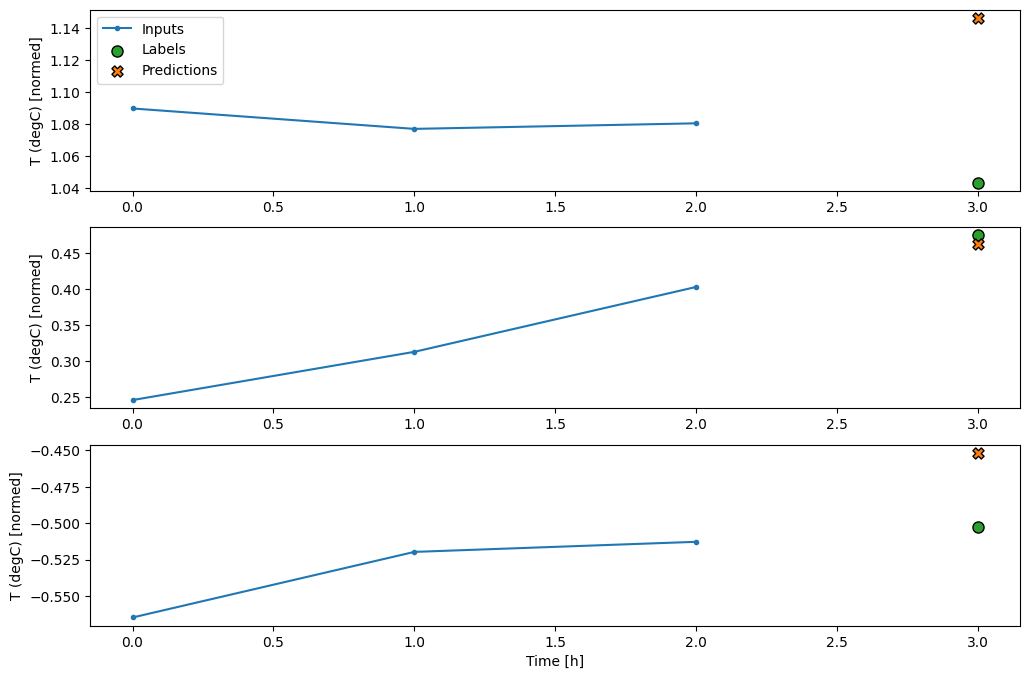

In [52]:
conv_window.plot(multi_step_dense)

The main down-side of this approach is that the resulting model can only be executed on input windows of exactly this shape. 

In [53]:
print('Input shape:', wide_window.example[0].shape)
try:
  print('Output shape:', multi_step_dense(wide_window.example[0]).shape)
except Exception as e:
  print(f'\n{type(e).__name__}:{e}')

Input shape: (32, 24, 19)

ValueError:Exception encountered when calling layer 'sequential_2' (type Sequential).

Input 0 of layer "dense_4" is incompatible with the layer: expected axis -1 of input shape to have value 57, but received input with shape (32, 456)

Call arguments received by layer 'sequential_2' (type Sequential):
  • inputs=tf.Tensor(shape=(32, 24, 19), dtype=float32)
  • training=None
  • mask=None


The convolutional models in the next section fix this problem.

### Convolution neural network
 
A convolution layer (`tf.keras.layers.Conv1D`) also takes multiple time steps as input to each prediction.

Below is the **same** model as `multi_step_dense`, re-written with a convolution. 

Note the changes:
* The `tf.keras.layers.Flatten` and the first `tf.keras.layers.Dense` are replaced by a `tf.keras.layers.Conv1D`.
* The `tf.keras.layers.Reshape` is no longer necessary since the convolution keeps the time axis in its output.

In [54]:
conv_model = tf.keras.Sequential([
    tf.keras.layers.Conv1D(filters=32,
                           kernel_size=(CONV_WIDTH,),
                           activation='relu'),
    tf.keras.layers.Dense(units=32, activation='relu'),
    tf.keras.layers.Dense(units=1),
])

Run it on an example batch to check that the model produces outputs with the expected shape:

In [55]:
print("Conv model on `conv_window`")
print('Input shape:', conv_window.example[0].shape)
print('Output shape:', conv_model(conv_window.example[0]).shape)

Conv model on `conv_window`
Input shape: (32, 3, 19)
Output shape: (32, 1, 1)


Train and evaluate it on the ` conv_window` and it should give performance similar to the `multi_step_dense` model.

In [56]:
history = compile_and_fit(conv_model, conv_window)

IPython.display.clear_output()
val_performance['Conv'] = conv_model.evaluate(conv_window.val)
performance['Conv'] = conv_model.evaluate(conv_window.test, verbose=0)

  1/438 [..............................] - ETA: 37s - loss: 0.0063 - mean_absolute_error: 0.0620

 21/438 [>.............................] - ETA: 1s - loss: 0.0074 - mean_absolute_error: 0.0632 

 42/438 [=>............................] - ETA: 0s - loss: 0.0078 - mean_absolute_error: 0.0636

 63/438 [===>..........................] - ETA: 0s - loss: 0.0078 - mean_absolute_error: 0.0637

 84/438 [====>.........................] - ETA: 0s - loss: 0.0077 - mean_absolute_error: 0.0634

104/438 [======>.......................] - ETA: 0s - loss: 0.0079 - mean_absolute_error: 0.0640

126/438 [=======>......................] - ETA: 0s - loss: 0.0079 - mean_absolute_error: 0.0641

147/438 [=========>....................] - ETA: 0s - loss: 0.0079 - mean_absolute_error: 0.0642

169/438 [==========>...................] - ETA: 0s - loss: 0.0080 - mean_absolute_error: 0.0643

190/438 [============>.................] - ETA: 0s - loss: 0.0079 - mean_absolute_error: 0.0643

211/438 [=============>................] - ETA: 0s - loss: 0.0078 - mean_absolute_error: 0.0642

232/438 [==============>...............] - ETA: 0s - loss: 0.0079 - mean_absolute_error: 0.0645

254/438 [================>.............] - ETA: 0s - loss: 0.0079 - mean_absolute_error: 0.0645

276/438 [=================>............] - ETA: 0s - loss: 0.0079 - mean_absolute_error: 0.0644

297/438 [===================>..........] - ETA: 0s - loss: 0.0078 - mean_absolute_error: 0.0643

318/438 [====================>.........] - ETA: 0s - loss: 0.0078 - mean_absolute_error: 0.0642

339/438 [======================>.......] - ETA: 0s - loss: 0.0078 - mean_absolute_error: 0.0640

361/438 [=======================>......] - ETA: 0s - loss: 0.0077 - mean_absolute_error: 0.0639

383/438 [=========================>....] - ETA: 0s - loss: 0.0077 - mean_absolute_error: 0.0638

405/438 [==========================>...] - ETA: 0s - loss: 0.0077 - mean_absolute_error: 0.0637

427/438 [============================>.] - ETA: 0s - loss: 0.0077 - mean_absolute_error: 0.0637

438/438 [==============================] - 1s 2ms/step - loss: 0.0077 - mean_absolute_error: 0.0638


The difference between this `conv_model` and the `multi_step_dense` model is that the `conv_model` can be run on inputs of any length. The convolutional layer is applied to a sliding window of inputs:

![Executing a convolutional model on a sequence](images/wide_conv_window.png)

If you run it on wider input, it produces wider output:

In [57]:
print("Wide window")
print('Input shape:', wide_window.example[0].shape)
print('Labels shape:', wide_window.example[1].shape)
print('Output shape:', conv_model(wide_window.example[0]).shape)

Wide window
Input shape: (32, 24, 19)
Labels shape: (32, 24, 1)
Output shape: (32, 22, 1)


Note that the output is shorter than the input. To make training or plotting work, you need the labels, and prediction to have the same length. So build a `WindowGenerator` to produce wide windows with a few extra input time steps so the label and prediction lengths match: 

In [58]:
LABEL_WIDTH = 24
INPUT_WIDTH = LABEL_WIDTH + (CONV_WIDTH - 1)
wide_conv_window = WindowGenerator(
    input_width=INPUT_WIDTH,
    label_width=LABEL_WIDTH,
    shift=1,
    label_columns=['T (degC)'])

wide_conv_window

Total window size: 27
Input indices: [ 0  1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20 21 22 23
 24 25]
Label indices: [ 3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20 21 22 23 24 25 26]
Label column name(s): ['T (degC)']

In [59]:
print("Wide conv window")
print('Input shape:', wide_conv_window.example[0].shape)
print('Labels shape:', wide_conv_window.example[1].shape)
print('Output shape:', conv_model(wide_conv_window.example[0]).shape)

Wide conv window


Input shape: (32, 26, 19)
Labels shape: (32, 24, 1)
Output shape: (32, 24, 1)


Now, you can plot the model's predictions on a wider window. Note the 3 input time steps before the first prediction. Every prediction here is based on the 3 preceding time steps:

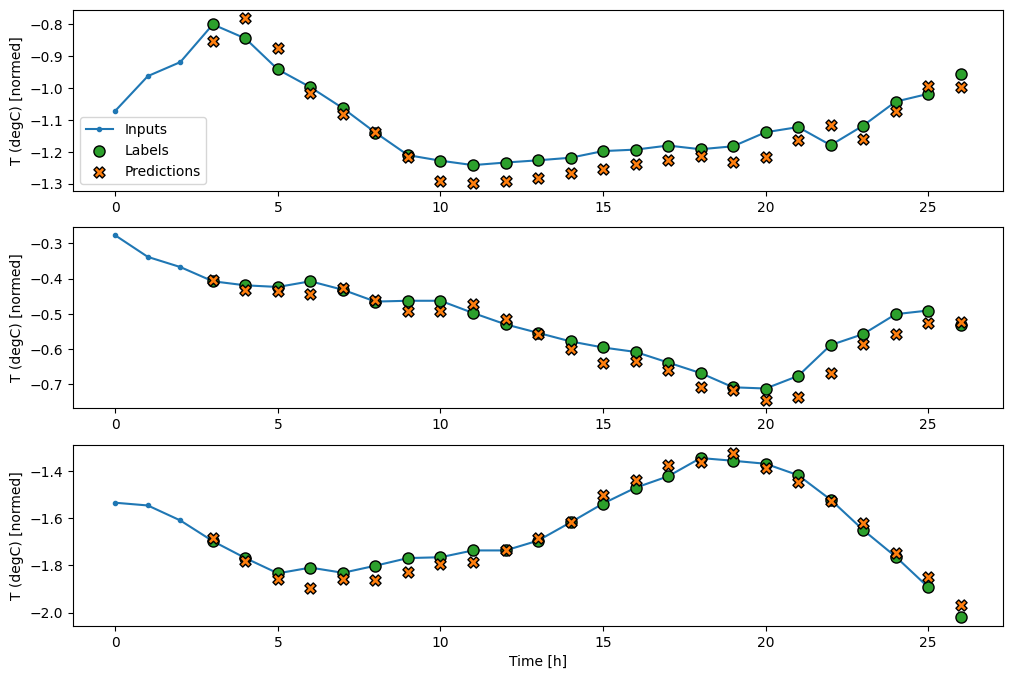

In [60]:
wide_conv_window.plot(conv_model)

### Recurrent neural network

A Recurrent Neural Network (RNN) is a type of neural network well-suited to time series data. RNNs process a time series step-by-step, maintaining an internal state from time-step to time-step.

You can learn more in the [Text generation with an RNN](https://www.tensorflow.org/text/tutorials/text_generation) tutorial and the [Recurrent Neural Networks (RNN) with Keras](https://www.tensorflow.org/guide/keras/rnn) guide.

In this tutorial, you will use an RNN layer called Long Short-Term Memory (`tf.keras.layers.LSTM`).

An important constructor argument for all Keras RNN layers, such as `tf.keras.layers.LSTM`, is the `return_sequences` argument. This setting can configure the layer in one of two ways:

1. If `False`, the default, the layer only returns the output of the final time step, giving the model time to warm up its internal state before making a single prediction: 

![An LSTM warming up and making a single prediction](images/lstm_1_window.png)

2. If `True`, the layer returns an output for each input. This is useful for:
  * Stacking RNN layers. 
  * Training a model on multiple time steps simultaneously.

![An LSTM making a prediction after every time step](images/lstm_many_window.png)

In [61]:
lstm_model = tf.keras.models.Sequential([
    # Shape [batch, time, features] => [batch, time, lstm_units]
    tf.keras.layers.LSTM(32, return_sequences=True),
    # Shape => [batch, time, features]
    tf.keras.layers.Dense(units=1)
])

With `return_sequences=True`, the model can be trained on 24 hours of data at a time.

Note: This will give a pessimistic view of the model's performance. On the first time step, the model has no access to previous steps and, therefore, can't do any better than the simple `linear` and `dense` models shown earlier.

In [62]:
print('Input shape:', wide_window.example[0].shape)
print('Output shape:', lstm_model(wide_window.example[0]).shape)

Input shape: (32, 24, 19)


Output shape: (32, 24, 1)


In [63]:
history = compile_and_fit(lstm_model, wide_window)

IPython.display.clear_output()
val_performance['LSTM'] = lstm_model.evaluate(wide_window.val)
performance['LSTM'] = lstm_model.evaluate(wide_window.test, verbose=0)

  1/438 [..............................] - ETA: 37s - loss: 0.0045 - mean_absolute_error: 0.0469

 18/438 [>.............................] - ETA: 1s - loss: 0.0055 - mean_absolute_error: 0.0512 

 36/438 [=>............................] - ETA: 1s - loss: 0.0055 - mean_absolute_error: 0.0512

 53/438 [==>...........................] - ETA: 1s - loss: 0.0056 - mean_absolute_error: 0.0515

 71/438 [===>..........................] - ETA: 1s - loss: 0.0056 - mean_absolute_error: 0.0512

 90/438 [=====>........................] - ETA: 0s - loss: 0.0056 - mean_absolute_error: 0.0513

109/438 [======>.......................] - ETA: 0s - loss: 0.0056 - mean_absolute_error: 0.0514

127/438 [=======>......................] - ETA: 0s - loss: 0.0056 - mean_absolute_error: 0.0517

145/438 [========>.....................] - ETA: 0s - loss: 0.0056 - mean_absolute_error: 0.0517

164/438 [==========>...................] - ETA: 0s - loss: 0.0056 - mean_absolute_error: 0.0517

183/438 [===========>..................] - ETA: 0s - loss: 0.0056 - mean_absolute_error: 0.0516

201/438 [============>.................] - ETA: 0s - loss: 0.0056 - mean_absolute_error: 0.0515

219/438 [==============>...............] - ETA: 0s - loss: 0.0056 - mean_absolute_error: 0.0515

238/438 [===============>..............] - ETA: 0s - loss: 0.0056 - mean_absolute_error: 0.0515

256/438 [================>.............] - ETA: 0s - loss: 0.0056 - mean_absolute_error: 0.0515

274/438 [=================>............] - ETA: 0s - loss: 0.0056 - mean_absolute_error: 0.0516

292/438 [===================>..........] - ETA: 0s - loss: 0.0056 - mean_absolute_error: 0.0516

310/438 [====================>.........] - ETA: 0s - loss: 0.0056 - mean_absolute_error: 0.0516

328/438 [=====================>........] - ETA: 0s - loss: 0.0056 - mean_absolute_error: 0.0517

346/438 [======================>.......] - ETA: 0s - loss: 0.0056 - mean_absolute_error: 0.0516

364/438 [=======================>......] - ETA: 0s - loss: 0.0056 - mean_absolute_error: 0.0517

382/438 [=========================>....] - ETA: 0s - loss: 0.0056 - mean_absolute_error: 0.0517

400/438 [==========================>...] - ETA: 0s - loss: 0.0056 - mean_absolute_error: 0.0517

418/438 [===========================>..] - ETA: 0s - loss: 0.0056 - mean_absolute_error: 0.0517

437/438 [============================>.] - ETA: 0s - loss: 0.0056 - mean_absolute_error: 0.0517

438/438 [==============================] - 1s 3ms/step - loss: 0.0056 - mean_absolute_error: 0.0517


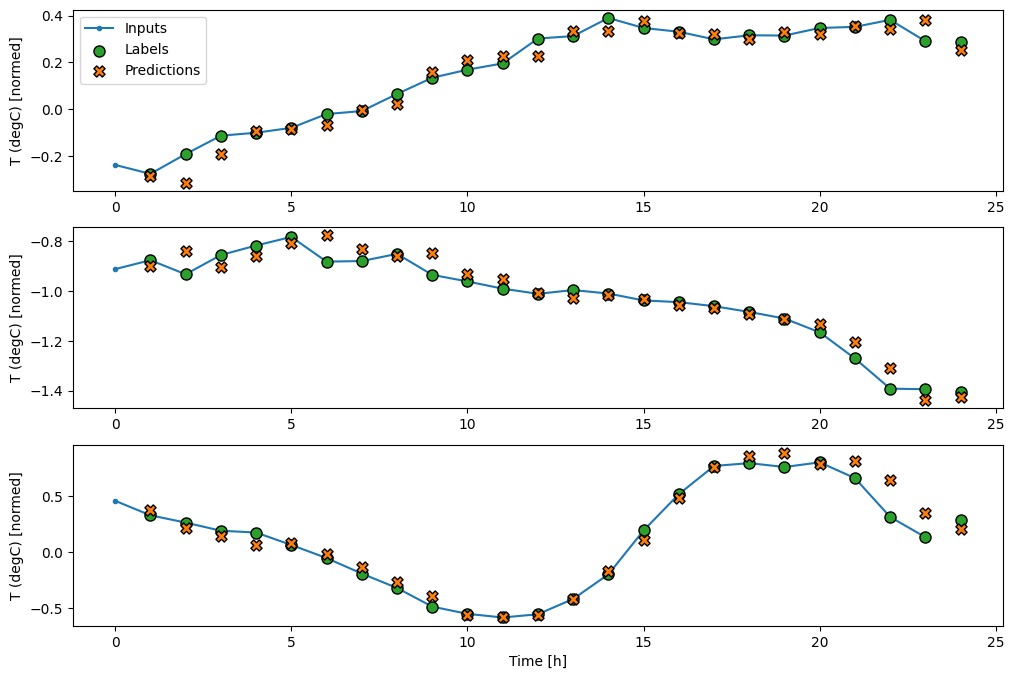

In [64]:
wide_window.plot(lstm_model)

### Performance

With this dataset typically each of the models does slightly better than the one before it:

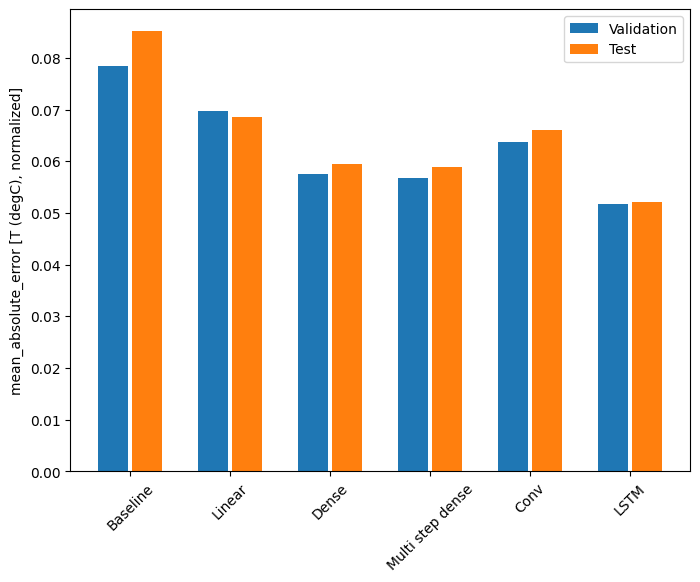

In [65]:
x = np.arange(len(performance))
width = 0.3
metric_name = 'mean_absolute_error'
metric_index = lstm_model.metrics_names.index('mean_absolute_error')
val_mae = [v[metric_index] for v in val_performance.values()]
test_mae = [v[metric_index] for v in performance.values()]

plt.ylabel('mean_absolute_error [T (degC), normalized]')
plt.bar(x - 0.17, val_mae, width, label='Validation')
plt.bar(x + 0.17, test_mae, width, label='Test')
plt.xticks(ticks=x, labels=performance.keys(),
           rotation=45)
_ = plt.legend()

In [66]:
for name, value in performance.items():
  print(f'{name:12s}: {value[1]:0.4f}')

Baseline    : 0.0852
Linear      : 0.0686
Dense       : 0.0595
Multi step dense: 0.0589
Conv        : 0.0661
LSTM        : 0.0521


### Multi-output models

The models so far all predicted a single output feature, `T (degC)`, for a single time step.

All of these models can be converted to predict multiple features just by changing the number of units in the output layer and adjusting the training windows to include all features in the `labels` (`example_labels`):

In [67]:
single_step_window = WindowGenerator(
    # `WindowGenerator` returns all features as labels if you 
    # don't set the `label_columns` argument.
    input_width=1, label_width=1, shift=1)

wide_window = WindowGenerator(
    input_width=24, label_width=24, shift=1)

for example_inputs, example_labels in wide_window.train.take(1):
  print(f'Inputs shape (batch, time, features): {example_inputs.shape}')
  print(f'Labels shape (batch, time, features): {example_labels.shape}')

Inputs shape (batch, time, features): (32, 24, 19)
Labels shape (batch, time, features): (32, 24, 19)


Note above that the `features` axis of the labels now has the same depth as the inputs, instead of `1`.

#### Baseline

The same baseline model (`Baseline`) can be used here, but this time repeating all features instead of selecting a specific `label_index`:

In [68]:
baseline = Baseline()
baseline.compile(loss=tf.keras.losses.MeanSquaredError(),
                 metrics=[tf.keras.metrics.MeanAbsoluteError()])

In [69]:
val_performance = {}
performance = {}
val_performance['Baseline'] = baseline.evaluate(wide_window.val)
performance['Baseline'] = baseline.evaluate(wide_window.test, verbose=0)

  1/438 [..............................] - ETA: 1:01 - loss: 0.0892 - mean_absolute_error: 0.1621

 30/438 [=>............................] - ETA: 0s - loss: 0.0889 - mean_absolute_error: 0.1597  

 59/438 [===>..........................] - ETA: 0s - loss: 0.0901 - mean_absolute_error: 0.1603

 88/438 [=====>........................] - ETA: 0s - loss: 0.0880 - mean_absolute_error: 0.1589

117/438 [=======>......................] - ETA: 0s - loss: 0.0887 - mean_absolute_error: 0.1591

147/438 [=========>....................] - ETA: 0s - loss: 0.0888 - mean_absolute_error: 0.1594

176/438 [===========>..................] - ETA: 0s - loss: 0.0883 - mean_absolute_error: 0.1588

205/438 [=============>................] - ETA: 0s - loss: 0.0882 - mean_absolute_error: 0.1587

233/438 [==============>...............] - ETA: 0s - loss: 0.0883 - mean_absolute_error: 0.1588

263/438 [=================>............] - ETA: 0s - loss: 0.0883 - mean_absolute_error: 0.1588

293/438 [===================>..........] - ETA: 0s - loss: 0.0885 - mean_absolute_error: 0.1589

323/438 [=====================>........] - ETA: 0s - loss: 0.0887 - mean_absolute_error: 0.1591

354/438 [=======================>......] - ETA: 0s - loss: 0.0888 - mean_absolute_error: 0.1592

384/438 [=========================>....] - ETA: 0s - loss: 0.0887 - mean_absolute_error: 0.1592

413/438 [===========================>..] - ETA: 0s - loss: 0.0886 - mean_absolute_error: 0.1589

438/438 [==============================] - 1s 2ms/step - loss: 0.0886 - mean_absolute_error: 0.1589


#### Dense

In [70]:
dense = tf.keras.Sequential([
    tf.keras.layers.Dense(units=64, activation='relu'),
    tf.keras.layers.Dense(units=64, activation='relu'),
    tf.keras.layers.Dense(units=num_features)
])

In [71]:
history = compile_and_fit(dense, single_step_window)

IPython.display.clear_output()
val_performance['Dense'] = dense.evaluate(single_step_window.val)
performance['Dense'] = dense.evaluate(single_step_window.test, verbose=0)

  1/439 [..............................] - ETA: 34s - loss: 0.0603 - mean_absolute_error: 0.1278

 20/439 [>.............................] - ETA: 1s - loss: 0.0683 - mean_absolute_error: 0.1319 

 41/439 [=>............................] - ETA: 1s - loss: 0.0656 - mean_absolute_error: 0.1298

 62/439 [===>..........................] - ETA: 0s - loss: 0.0657 - mean_absolute_error: 0.1302

 83/439 [====>.........................] - ETA: 0s - loss: 0.0644 - mean_absolute_error: 0.1292

103/439 [======>.......................] - ETA: 0s - loss: 0.0641 - mean_absolute_error: 0.1291

123/439 [=======>......................] - ETA: 0s - loss: 0.0645 - mean_absolute_error: 0.1295

144/439 [========>.....................] - ETA: 0s - loss: 0.0655 - mean_absolute_error: 0.1300

164/439 [==========>...................] - ETA: 0s - loss: 0.0665 - mean_absolute_error: 0.1306

185/439 [===========>..................] - ETA: 0s - loss: 0.0669 - mean_absolute_error: 0.1308

205/439 [=============>................] - ETA: 0s - loss: 0.0672 - mean_absolute_error: 0.1310

225/439 [==============>...............] - ETA: 0s - loss: 0.0677 - mean_absolute_error: 0.1313

246/439 [===============>..............] - ETA: 0s - loss: 0.0678 - mean_absolute_error: 0.1313

267/439 [=================>............] - ETA: 0s - loss: 0.0681 - mean_absolute_error: 0.1316

287/439 [==================>...........] - ETA: 0s - loss: 0.0685 - mean_absolute_error: 0.1317

307/439 [===================>..........] - ETA: 0s - loss: 0.0686 - mean_absolute_error: 0.1317

327/439 [=====================>........] - ETA: 0s - loss: 0.0687 - mean_absolute_error: 0.1318

347/439 [======================>.......] - ETA: 0s - loss: 0.0685 - mean_absolute_error: 0.1317

368/439 [========================>.....] - ETA: 0s - loss: 0.0688 - mean_absolute_error: 0.1319

389/439 [=========================>....] - ETA: 0s - loss: 0.0691 - mean_absolute_error: 0.1321

409/439 [==========================>...] - ETA: 0s - loss: 0.0691 - mean_absolute_error: 0.1320

429/439 [============================>.] - ETA: 0s - loss: 0.0692 - mean_absolute_error: 0.1321

439/439 [==============================] - 1s 3ms/step - loss: 0.0693 - mean_absolute_error: 0.1321


#### RNN


In [72]:
%%time
wide_window = WindowGenerator(
    input_width=24, label_width=24, shift=1)

lstm_model = tf.keras.models.Sequential([
    # Shape [batch, time, features] => [batch, time, lstm_units]
    tf.keras.layers.LSTM(32, return_sequences=True),
    # Shape => [batch, time, features]
    tf.keras.layers.Dense(units=num_features)
])

history = compile_and_fit(lstm_model, wide_window)

IPython.display.clear_output()
val_performance['LSTM'] = lstm_model.evaluate( wide_window.val)
performance['LSTM'] = lstm_model.evaluate( wide_window.test, verbose=0)

print()

  1/438 [..............................] - ETA: 36s - loss: 0.0625 - mean_absolute_error: 0.1214

 18/438 [>.............................] - ETA: 1s - loss: 0.0609 - mean_absolute_error: 0.1189 

 36/438 [=>............................] - ETA: 1s - loss: 0.0604 - mean_absolute_error: 0.1182

 54/438 [==>...........................] - ETA: 1s - loss: 0.0609 - mean_absolute_error: 0.1189

 72/438 [===>..........................] - ETA: 1s - loss: 0.0616 - mean_absolute_error: 0.1195

 90/438 [=====>........................] - ETA: 1s - loss: 0.0617 - mean_absolute_error: 0.1197

108/438 [======>.......................] - ETA: 0s - loss: 0.0621 - mean_absolute_error: 0.1199

126/438 [=======>......................] - ETA: 0s - loss: 0.0619 - mean_absolute_error: 0.1198

144/438 [========>.....................] - ETA: 0s - loss: 0.0617 - mean_absolute_error: 0.1196

162/438 [==========>...................] - ETA: 0s - loss: 0.0615 - mean_absolute_error: 0.1194

180/438 [===========>..................] - ETA: 0s - loss: 0.0617 - mean_absolute_error: 0.1195

198/438 [============>.................] - ETA: 0s - loss: 0.0617 - mean_absolute_error: 0.1195

216/438 [=============>................] - ETA: 0s - loss: 0.0614 - mean_absolute_error: 0.1193

234/438 [===============>..............] - ETA: 0s - loss: 0.0614 - mean_absolute_error: 0.1193

252/438 [================>.............] - ETA: 0s - loss: 0.0614 - mean_absolute_error: 0.1193

270/438 [=================>............] - ETA: 0s - loss: 0.0615 - mean_absolute_error: 0.1194

288/438 [==================>...........] - ETA: 0s - loss: 0.0616 - mean_absolute_error: 0.1194

306/438 [===================>..........] - ETA: 0s - loss: 0.0616 - mean_absolute_error: 0.1194

324/438 [=====================>........] - ETA: 0s - loss: 0.0616 - mean_absolute_error: 0.1194

342/438 [======================>.......] - ETA: 0s - loss: 0.0616 - mean_absolute_error: 0.1194

360/438 [=======================>......] - ETA: 0s - loss: 0.0616 - mean_absolute_error: 0.1194

378/438 [========================>.....] - ETA: 0s - loss: 0.0614 - mean_absolute_error: 0.1193

396/438 [==========================>...] - ETA: 0s - loss: 0.0613 - mean_absolute_error: 0.1192

414/438 [===========================>..] - ETA: 0s - loss: 0.0614 - mean_absolute_error: 0.1193

433/438 [============================>.] - ETA: 0s - loss: 0.0614 - mean_absolute_error: 0.1193

438/438 [==============================] - 1s 3ms/step - loss: 0.0614 - mean_absolute_error: 0.1193



CPU times: user 5min 54s, sys: 1min 13s, total: 7min 7s
Wall time: 2min 38s


<a id="residual"></a>

#### Advanced: Residual connections

The `Baseline` model from earlier took advantage of the fact that the sequence doesn't change drastically from time step to time step. Every model trained in this tutorial so far was randomly initialized, and then had to learn that the output is a a small change from the previous time step.

While you can get around this issue with careful initialization, it's  simpler to build this into the model structure.

It's common in time series analysis to build models that instead of predicting the next value, predict how the value will change in the next time step. Similarly, <a href="https://arxiv.org/abs/1512.03385" class="external">residual networks</a>—or ResNets—in deep learning refer to architectures where each layer adds to the model's accumulating result.

That is how you take advantage of the knowledge that the change should be small.

![A model with a residual connection](images/residual.png)

Essentially, this initializes the model to match the `Baseline`. For this task it helps models converge faster, with slightly better performance.

This approach can be used in conjunction with any model discussed in this tutorial. 

Here, it is being applied to the LSTM model, note the use of the `tf.initializers.zeros` to ensure that the initial predicted changes are small, and don't overpower the residual connection. There are no symmetry-breaking concerns for the gradients here, since the `zeros` are only used on the last layer.

In [73]:
class ResidualWrapper(tf.keras.Model):
  def __init__(self, model):
    super().__init__()
    self.model = model

  def call(self, inputs, *args, **kwargs):
    delta = self.model(inputs, *args, **kwargs)

    # The prediction for each time step is the input
    # from the previous time step plus the delta
    # calculated by the model.
    return inputs + delta

In [74]:
%%time
residual_lstm = ResidualWrapper(
    tf.keras.Sequential([
    tf.keras.layers.LSTM(32, return_sequences=True),
    tf.keras.layers.Dense(
        num_features,
        # The predicted deltas should start small.
        # Therefore, initialize the output layer with zeros.
        kernel_initializer=tf.initializers.zeros())
]))

history = compile_and_fit(residual_lstm, wide_window)

IPython.display.clear_output()
val_performance['Residual LSTM'] = residual_lstm.evaluate(wide_window.val)
performance['Residual LSTM'] = residual_lstm.evaluate(wide_window.test, verbose=0)
print()

  1/438 [..............................] - ETA: 35s - loss: 0.0517 - mean_absolute_error: 0.1111

 17/438 [>.............................] - ETA: 1s - loss: 0.0598 - mean_absolute_error: 0.1159 

 35/438 [=>............................] - ETA: 1s - loss: 0.0607 - mean_absolute_error: 0.1169

 53/438 [==>...........................] - ETA: 1s - loss: 0.0618 - mean_absolute_error: 0.1176

 71/438 [===>..........................] - ETA: 1s - loss: 0.0619 - mean_absolute_error: 0.1176

 89/438 [=====>........................] - ETA: 1s - loss: 0.0619 - mean_absolute_error: 0.1177

107/438 [======>.......................] - ETA: 0s - loss: 0.0620 - mean_absolute_error: 0.1179

125/438 [=======>......................] - ETA: 0s - loss: 0.0619 - mean_absolute_error: 0.1178

143/438 [========>.....................] - ETA: 0s - loss: 0.0619 - mean_absolute_error: 0.1178

161/438 [==========>...................] - ETA: 0s - loss: 0.0615 - mean_absolute_error: 0.1175

179/438 [===========>..................] - ETA: 0s - loss: 0.0615 - mean_absolute_error: 0.1175

197/438 [============>.................] - ETA: 0s - loss: 0.0618 - mean_absolute_error: 0.1177

215/438 [=============>................] - ETA: 0s - loss: 0.0617 - mean_absolute_error: 0.1176

233/438 [==============>...............] - ETA: 0s - loss: 0.0616 - mean_absolute_error: 0.1176

251/438 [================>.............] - ETA: 0s - loss: 0.0616 - mean_absolute_error: 0.1175

269/438 [=================>............] - ETA: 0s - loss: 0.0617 - mean_absolute_error: 0.1176

287/438 [==================>...........] - ETA: 0s - loss: 0.0616 - mean_absolute_error: 0.1176

305/438 [===================>..........] - ETA: 0s - loss: 0.0615 - mean_absolute_error: 0.1175

324/438 [=====================>........] - ETA: 0s - loss: 0.0616 - mean_absolute_error: 0.1176

342/438 [======================>.......] - ETA: 0s - loss: 0.0617 - mean_absolute_error: 0.1176

360/438 [=======================>......] - ETA: 0s - loss: 0.0616 - mean_absolute_error: 0.1176

378/438 [========================>.....] - ETA: 0s - loss: 0.0617 - mean_absolute_error: 0.1177

396/438 [==========================>...] - ETA: 0s - loss: 0.0617 - mean_absolute_error: 0.1177

414/438 [===========================>..] - ETA: 0s - loss: 0.0617 - mean_absolute_error: 0.1177

432/438 [============================>.] - ETA: 0s - loss: 0.0617 - mean_absolute_error: 0.1178

438/438 [==============================] - 1s 3ms/step - loss: 0.0617 - mean_absolute_error: 0.1178



CPU times: user 2min 8s, sys: 26.9 s, total: 2min 35s
Wall time: 58.8 s


#### Performance

Here is the overall performance for these multi-output models.

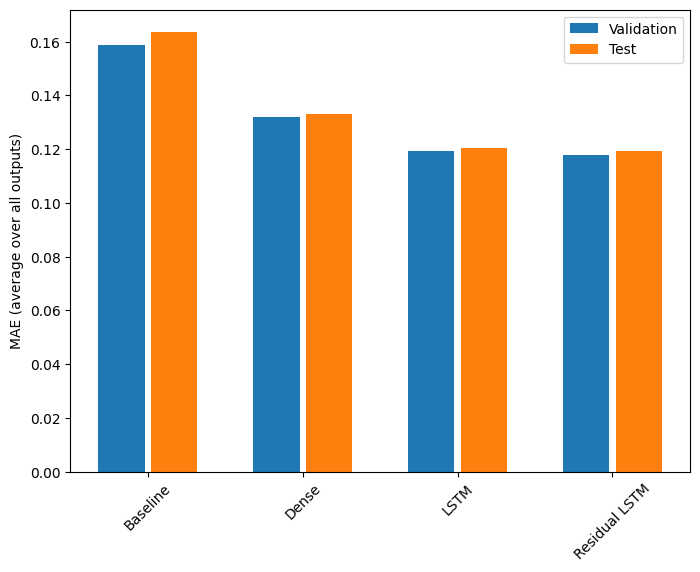

In [75]:
x = np.arange(len(performance))
width = 0.3

metric_name = 'mean_absolute_error'
metric_index = lstm_model.metrics_names.index('mean_absolute_error')
val_mae = [v[metric_index] for v in val_performance.values()]
test_mae = [v[metric_index] for v in performance.values()]

plt.bar(x - 0.17, val_mae, width, label='Validation')
plt.bar(x + 0.17, test_mae, width, label='Test')
plt.xticks(ticks=x, labels=performance.keys(),
           rotation=45)
plt.ylabel('MAE (average over all outputs)')
_ = plt.legend()

In [76]:
for name, value in performance.items():
  print(f'{name:15s}: {value[1]:0.4f}')

Baseline       : 0.1638
Dense          : 0.1333
LSTM           : 0.1206
Residual LSTM  : 0.1193


The above performances are averaged across all model outputs.

## Multi-step models

Both the single-output and multiple-output models in the previous sections made **single time step predictions**, one hour into the future.

This section looks at how to expand these models to make **multiple time step predictions**.

In a multi-step prediction, the model needs to learn to predict a range of future values. Thus, unlike a single step model, where only a single future point is predicted, a multi-step model predicts a sequence of the future values.

There are two rough approaches to this:

1. Single shot predictions where the entire time series is predicted at once.
2. Autoregressive predictions where the model only makes single step predictions and its output is fed back as its input.

In this section all the models will predict **all the features across all output time steps**.


For the multi-step model, the training data again consists of hourly samples. However, here, the models will learn to predict 24 hours into the future, given 24 hours of the past.

Here is a `Window` object that generates these slices from the dataset:

Total window size: 48
Input indices: [ 0  1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20 21 22 23]
Label indices: [24 25 26 27 28 29 30 31 32 33 34 35 36 37 38 39 40 41 42 43 44 45 46 47]
Label column name(s): None

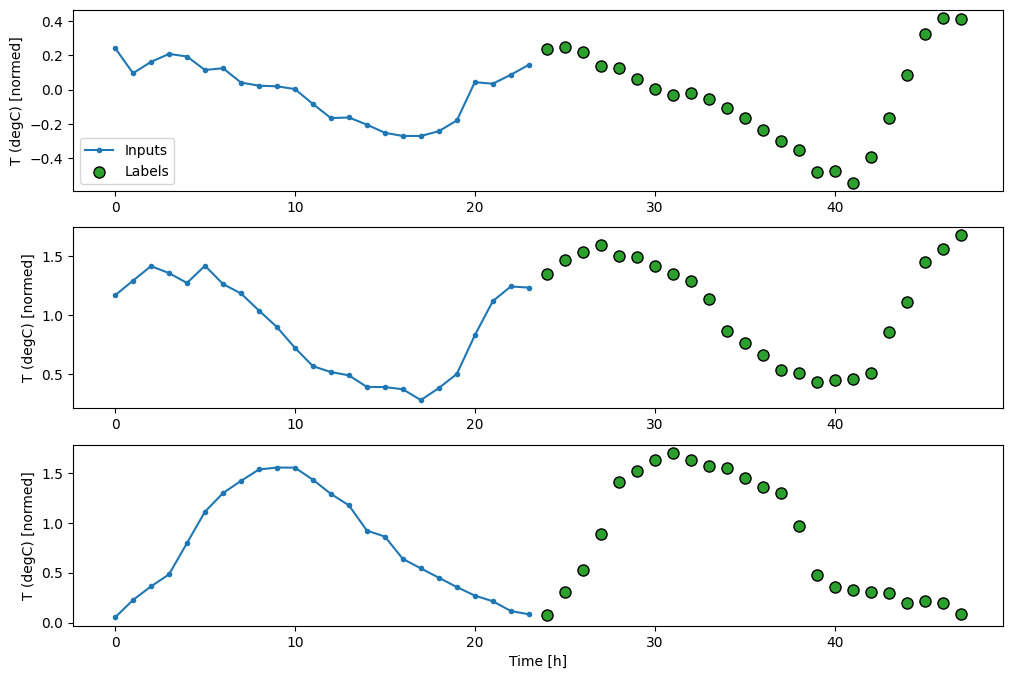

In [77]:
OUT_STEPS = 24
multi_window = WindowGenerator(input_width=24,
                               label_width=OUT_STEPS,
                               shift=OUT_STEPS)

multi_window.plot()
multi_window

### Baselines

A simple baseline for this task is to repeat the last input time step for the required number of output time steps:

![Repeat the last input, for each output step](images/multistep_last.png)

  1/437 [..............................] - ETA: 1:13 - loss: 0.6018 - mean_absolute_error: 0.5035

 29/437 [>.............................] - ETA: 0s - loss: 0.6245 - mean_absolute_error: 0.4990  

 57/437 [==>...........................] - ETA: 0s - loss: 0.6219 - mean_absolute_error: 0.4985

 85/437 [====>.........................] - ETA: 0s - loss: 0.6225 - mean_absolute_error: 0.4995

112/437 [======>.......................] - ETA: 0s - loss: 0.6267 - mean_absolute_error: 0.5003

140/437 [========>.....................] - ETA: 0s - loss: 0.6289 - mean_absolute_error: 0.5011

167/437 [==========>...................] - ETA: 0s - loss: 0.6278 - mean_absolute_error: 0.5008

194/437 [============>.................] - ETA: 0s - loss: 0.6294 - mean_absolute_error: 0.5019

222/437 [==============>...............] - ETA: 0s - loss: 0.6312 - mean_absolute_error: 0.5025

250/437 [================>.............] - ETA: 0s - loss: 0.6276 - mean_absolute_error: 0.5007

279/437 [==================>...........] - ETA: 0s - loss: 0.6284 - mean_absolute_error: 0.5006

308/437 [====================>.........] - ETA: 0s - loss: 0.6274 - mean_absolute_error: 0.5002

336/437 [======================>.......] - ETA: 0s - loss: 0.6293 - mean_absolute_error: 0.5011

367/437 [========================>.....] - ETA: 0s - loss: 0.6281 - mean_absolute_error: 0.5009

395/437 [==========================>...] - ETA: 0s - loss: 0.6282 - mean_absolute_error: 0.5008

423/437 [============================>.] - ETA: 0s - loss: 0.6284 - mean_absolute_error: 0.5007

437/437 [==============================] - 1s 2ms/step - loss: 0.6285 - mean_absolute_error: 0.5007


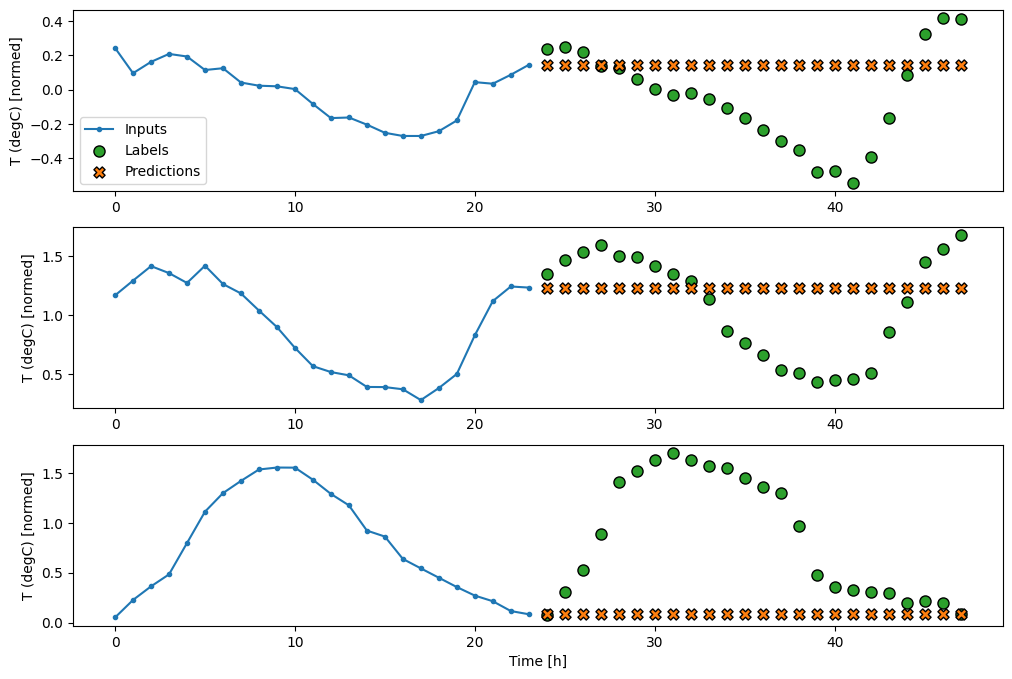

In [78]:
class MultiStepLastBaseline(tf.keras.Model):
  def call(self, inputs):
    return tf.tile(inputs[:, -1:, :], [1, OUT_STEPS, 1])

last_baseline = MultiStepLastBaseline()
last_baseline.compile(loss=tf.keras.losses.MeanSquaredError(),
                      metrics=[tf.keras.metrics.MeanAbsoluteError()])

multi_val_performance = {}
multi_performance = {}

multi_val_performance['Last'] = last_baseline.evaluate(multi_window.val)
multi_performance['Last'] = last_baseline.evaluate(multi_window.test, verbose=0)
multi_window.plot(last_baseline)

Since this task is to predict 24 hours into the future, given 24 hours of the past, another simple approach is to repeat the previous day, assuming tomorrow will be similar:

![Repeat the previous day](images/multistep_repeat.png)

  1/437 [..............................] - ETA: 1:08 - loss: 0.4046 - mean_absolute_error: 0.3896

 28/437 [>.............................] - ETA: 0s - loss: 0.4342 - mean_absolute_error: 0.3962  

 58/437 [==>...........................] - ETA: 0s - loss: 0.4357 - mean_absolute_error: 0.3980

 87/437 [====>.........................] - ETA: 0s - loss: 0.4361 - mean_absolute_error: 0.3987

117/437 [=======>......................] - ETA: 0s - loss: 0.4331 - mean_absolute_error: 0.3975

147/437 [=========>....................] - ETA: 0s - loss: 0.4293 - mean_absolute_error: 0.3961

177/437 [===========>..................] - ETA: 0s - loss: 0.4299 - mean_absolute_error: 0.3960

207/437 [=============>................] - ETA: 0s - loss: 0.4282 - mean_absolute_error: 0.3953

237/437 [===============>..............] - ETA: 0s - loss: 0.4266 - mean_absolute_error: 0.3945

266/437 [=================>............] - ETA: 0s - loss: 0.4259 - mean_absolute_error: 0.3944

295/437 [===================>..........] - ETA: 0s - loss: 0.4267 - mean_absolute_error: 0.3948

325/437 [=====================>........] - ETA: 0s - loss: 0.4278 - mean_absolute_error: 0.3954

355/437 [=======================>......] - ETA: 0s - loss: 0.4276 - mean_absolute_error: 0.3956

386/437 [=========================>....] - ETA: 0s - loss: 0.4268 - mean_absolute_error: 0.3956

415/437 [===========================>..] - ETA: 0s - loss: 0.4263 - mean_absolute_error: 0.3955

437/437 [==============================] - 1s 2ms/step - loss: 0.4270 - mean_absolute_error: 0.3959


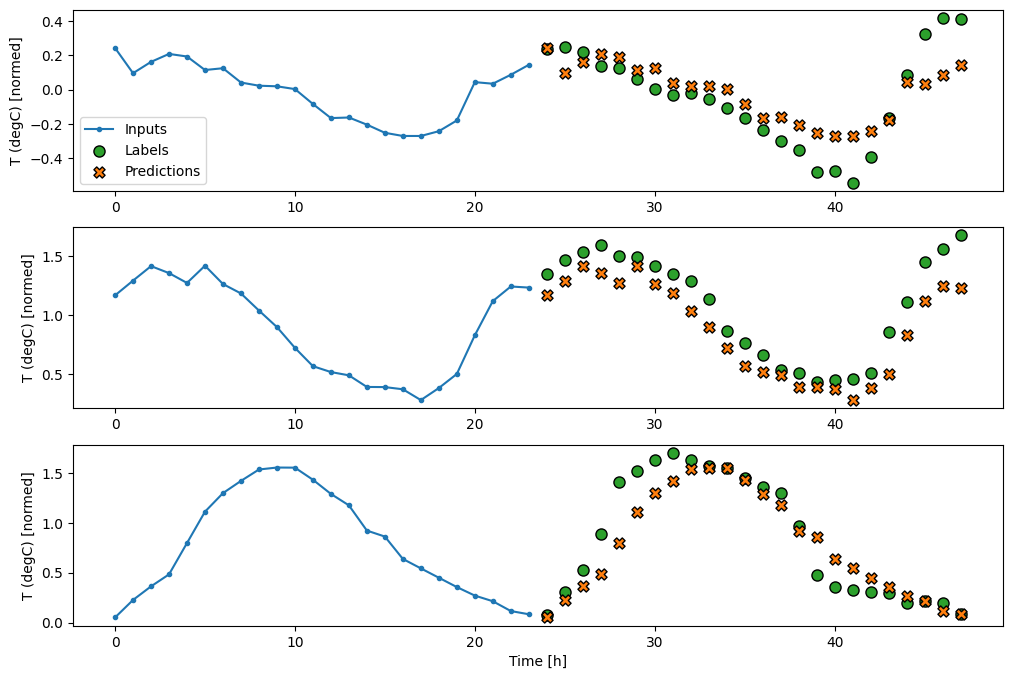

In [79]:
class RepeatBaseline(tf.keras.Model):
  def call(self, inputs):
    return inputs

repeat_baseline = RepeatBaseline()
repeat_baseline.compile(loss=tf.keras.losses.MeanSquaredError(),
                        metrics=[tf.keras.metrics.MeanAbsoluteError()])

multi_val_performance['Repeat'] = repeat_baseline.evaluate(multi_window.val)
multi_performance['Repeat'] = repeat_baseline.evaluate(multi_window.test, verbose=0)
multi_window.plot(repeat_baseline)

### Single-shot models

One high-level approach to this problem is to use a "single-shot" model, where the model makes the entire sequence prediction in a single step.

This can be implemented efficiently as a `tf.keras.layers.Dense` with `OUT_STEPS*features` output units. The model just needs to reshape that output to the required `(OUTPUT_STEPS, features)`.

#### Linear

A simple linear model based on the last input time step does better than either baseline, but is underpowered. The model needs to predict `OUTPUT_STEPS` time steps, from a single input time step with a linear projection. It can only capture a low-dimensional slice of the behavior, likely based mainly on the time of day and time of year.

![Predict all timesteps from the last time-step](images/multistep_dense.png)

  1/437 [..............................] - ETA: 34s - loss: 0.3062 - mean_absolute_error: 0.3227

 24/437 [>.............................] - ETA: 0s - loss: 0.2503 - mean_absolute_error: 0.3027 

 49/437 [==>...........................] - ETA: 0s - loss: 0.2503 - mean_absolute_error: 0.3026

 74/437 [====>.........................] - ETA: 0s - loss: 0.2541 - mean_absolute_error: 0.3037

 99/437 [=====>........................] - ETA: 0s - loss: 0.2546 - mean_absolute_error: 0.3041

123/437 [=======>......................] - ETA: 0s - loss: 0.2547 - mean_absolute_error: 0.3044

147/437 [=========>....................] - ETA: 0s - loss: 0.2566 - mean_absolute_error: 0.3055

172/437 [==========>...................] - ETA: 0s - loss: 0.2585 - mean_absolute_error: 0.3062

197/437 [============>.................] - ETA: 0s - loss: 0.2572 - mean_absolute_error: 0.3055

222/437 [==============>...............] - ETA: 0s - loss: 0.2560 - mean_absolute_error: 0.3048

247/437 [===============>..............] - ETA: 0s - loss: 0.2554 - mean_absolute_error: 0.3043

272/437 [=================>............] - ETA: 0s - loss: 0.2570 - mean_absolute_error: 0.3050

296/437 [===================>..........] - ETA: 0s - loss: 0.2568 - mean_absolute_error: 0.3050

321/437 [=====================>........] - ETA: 0s - loss: 0.2562 - mean_absolute_error: 0.3047

346/437 [======================>.......] - ETA: 0s - loss: 0.2559 - mean_absolute_error: 0.3046

371/437 [========================>.....] - ETA: 0s - loss: 0.2558 - mean_absolute_error: 0.3046

397/437 [==========================>...] - ETA: 0s - loss: 0.2563 - mean_absolute_error: 0.3049

422/437 [===========================>..] - ETA: 0s - loss: 0.2562 - mean_absolute_error: 0.3050

437/437 [==============================] - 1s 2ms/step - loss: 0.2559 - mean_absolute_error: 0.3049


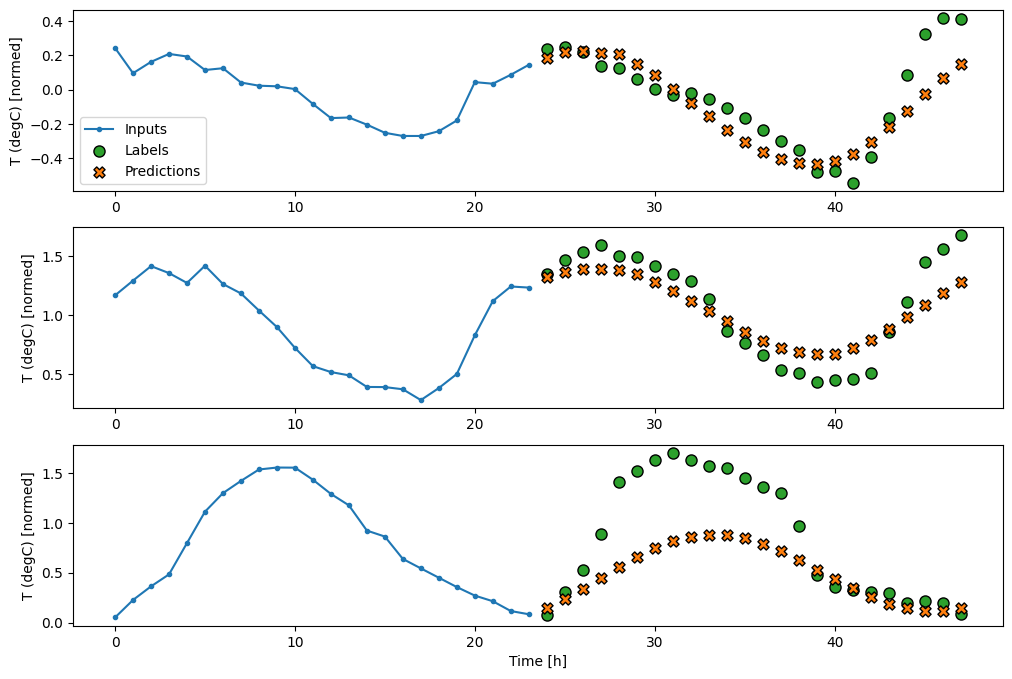

In [80]:
multi_linear_model = tf.keras.Sequential([
    # Take the last time-step.
    # Shape [batch, time, features] => [batch, 1, features]
    tf.keras.layers.Lambda(lambda x: x[:, -1:, :]),
    # Shape => [batch, 1, out_steps*features]
    tf.keras.layers.Dense(OUT_STEPS*num_features,
                          kernel_initializer=tf.initializers.zeros()),
    # Shape => [batch, out_steps, features]
    tf.keras.layers.Reshape([OUT_STEPS, num_features])
])

history = compile_and_fit(multi_linear_model, multi_window)

IPython.display.clear_output()
multi_val_performance['Linear'] = multi_linear_model.evaluate(multi_window.val)
multi_performance['Linear'] = multi_linear_model.evaluate(multi_window.test, verbose=0)
multi_window.plot(multi_linear_model)

#### Dense

Adding a `tf.keras.layers.Dense` between the input and output gives the linear model more power, but is still only based on a single input time step.

  1/437 [..............................] - ETA: 34s - loss: 0.2548 - mean_absolute_error: 0.3072

 22/437 [>.............................] - ETA: 1s - loss: 0.2190 - mean_absolute_error: 0.2835 

 44/437 [==>...........................] - ETA: 0s - loss: 0.2239 - mean_absolute_error: 0.2860

 66/437 [===>..........................] - ETA: 0s - loss: 0.2254 - mean_absolute_error: 0.2867

 88/437 [=====>........................] - ETA: 0s - loss: 0.2246 - mean_absolute_error: 0.2866

110/437 [======>.......................] - ETA: 0s - loss: 0.2238 - mean_absolute_error: 0.2859

132/437 [========>.....................] - ETA: 0s - loss: 0.2216 - mean_absolute_error: 0.2844

154/437 [=========>....................] - ETA: 0s - loss: 0.2208 - mean_absolute_error: 0.2839

177/437 [===========>..................] - ETA: 0s - loss: 0.2204 - mean_absolute_error: 0.2836

199/437 [============>.................] - ETA: 0s - loss: 0.2201 - mean_absolute_error: 0.2836

221/437 [==============>...............] - ETA: 0s - loss: 0.2204 - mean_absolute_error: 0.2837

243/437 [===============>..............] - ETA: 0s - loss: 0.2205 - mean_absolute_error: 0.2836

265/437 [=================>............] - ETA: 0s - loss: 0.2202 - mean_absolute_error: 0.2834

287/437 [==================>...........] - ETA: 0s - loss: 0.2205 - mean_absolute_error: 0.2834

309/437 [====================>.........] - ETA: 0s - loss: 0.2208 - mean_absolute_error: 0.2836

330/437 [=====================>........] - ETA: 0s - loss: 0.2211 - mean_absolute_error: 0.2838

352/437 [=======================>......] - ETA: 0s - loss: 0.2206 - mean_absolute_error: 0.2836

373/437 [========================>.....] - ETA: 0s - loss: 0.2208 - mean_absolute_error: 0.2836

395/437 [==========================>...] - ETA: 0s - loss: 0.2204 - mean_absolute_error: 0.2834

419/437 [===========================>..] - ETA: 0s - loss: 0.2206 - mean_absolute_error: 0.2835

437/437 [==============================] - 1s 2ms/step - loss: 0.2203 - mean_absolute_error: 0.2834


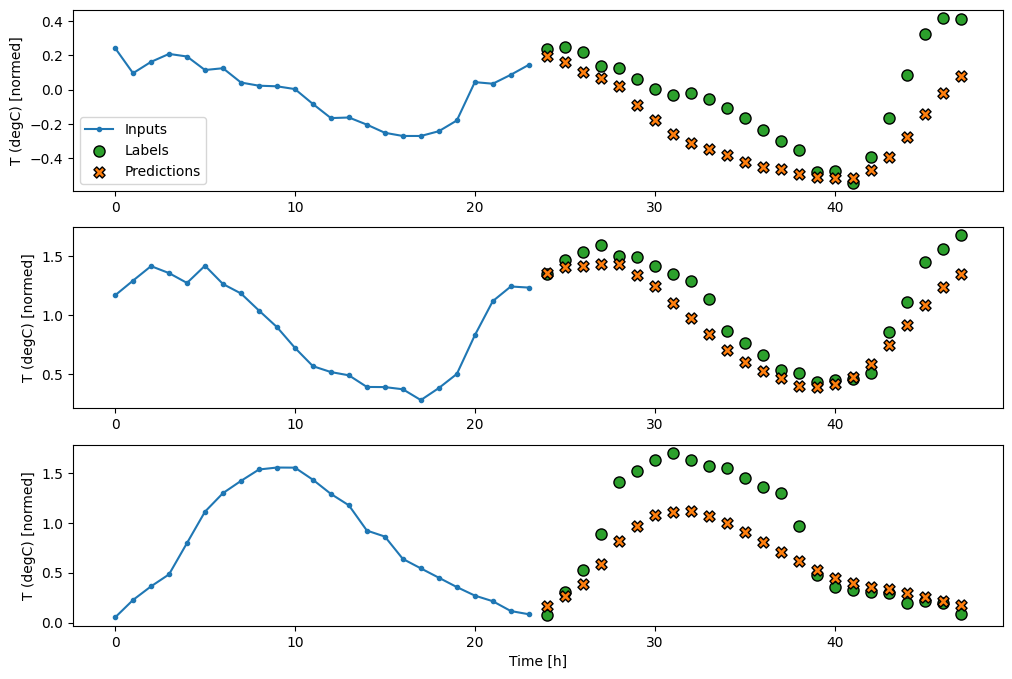

In [81]:
multi_dense_model = tf.keras.Sequential([
    # Take the last time step.
    # Shape [batch, time, features] => [batch, 1, features]
    tf.keras.layers.Lambda(lambda x: x[:, -1:, :]),
    # Shape => [batch, 1, dense_units]
    tf.keras.layers.Dense(512, activation='relu'),
    # Shape => [batch, out_steps*features]
    tf.keras.layers.Dense(OUT_STEPS*num_features,
                          kernel_initializer=tf.initializers.zeros()),
    # Shape => [batch, out_steps, features]
    tf.keras.layers.Reshape([OUT_STEPS, num_features])
])

history = compile_and_fit(multi_dense_model, multi_window)

IPython.display.clear_output()
multi_val_performance['Dense'] = multi_dense_model.evaluate(multi_window.val)
multi_performance['Dense'] = multi_dense_model.evaluate(multi_window.test, verbose=0)
multi_window.plot(multi_dense_model)

#### CNN

A convolutional model makes predictions based on a fixed-width history, which may lead to better performance than the dense model since it can see how things are changing over time:

![A convolutional model sees how things change over time](images/multistep_conv.png)

  1/437 [..............................] - ETA: 34s - loss: 0.2273 - mean_absolute_error: 0.2947

 23/437 [>.............................] - ETA: 0s - loss: 0.2127 - mean_absolute_error: 0.2803 

 45/437 [==>...........................] - ETA: 0s - loss: 0.2143 - mean_absolute_error: 0.2814

 69/437 [===>..........................] - ETA: 0s - loss: 0.2154 - mean_absolute_error: 0.2810

 93/437 [=====>........................] - ETA: 0s - loss: 0.2173 - mean_absolute_error: 0.2818

117/437 [=======>......................] - ETA: 0s - loss: 0.2160 - mean_absolute_error: 0.2813

141/437 [========>.....................] - ETA: 0s - loss: 0.2144 - mean_absolute_error: 0.2805

164/437 [==========>...................] - ETA: 0s - loss: 0.2136 - mean_absolute_error: 0.2799

188/437 [===========>..................] - ETA: 0s - loss: 0.2148 - mean_absolute_error: 0.2804

211/437 [=============>................] - ETA: 0s - loss: 0.2155 - mean_absolute_error: 0.2806

235/437 [===============>..............] - ETA: 0s - loss: 0.2154 - mean_absolute_error: 0.2807

258/437 [================>.............] - ETA: 0s - loss: 0.2161 - mean_absolute_error: 0.2809

281/437 [==================>...........] - ETA: 0s - loss: 0.2164 - mean_absolute_error: 0.2813

304/437 [===================>..........] - ETA: 0s - loss: 0.2159 - mean_absolute_error: 0.2809

327/437 [=====================>........] - ETA: 0s - loss: 0.2152 - mean_absolute_error: 0.2805

350/437 [=======================>......] - ETA: 0s - loss: 0.2150 - mean_absolute_error: 0.2805

373/437 [========================>.....] - ETA: 0s - loss: 0.2149 - mean_absolute_error: 0.2804

396/437 [==========================>...] - ETA: 0s - loss: 0.2149 - mean_absolute_error: 0.2804

422/437 [===========================>..] - ETA: 0s - loss: 0.2147 - mean_absolute_error: 0.2802

437/437 [==============================] - 1s 2ms/step - loss: 0.2145 - mean_absolute_error: 0.2801


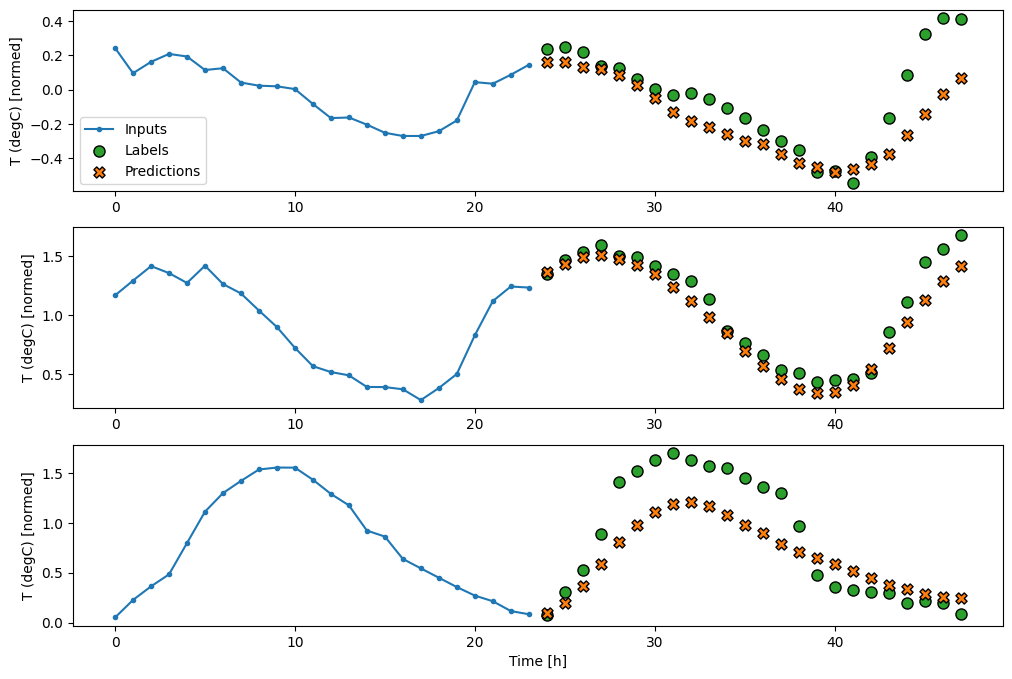

In [82]:
CONV_WIDTH = 3
multi_conv_model = tf.keras.Sequential([
    # Shape [batch, time, features] => [batch, CONV_WIDTH, features]
    tf.keras.layers.Lambda(lambda x: x[:, -CONV_WIDTH:, :]),
    # Shape => [batch, 1, conv_units]
    tf.keras.layers.Conv1D(256, activation='relu', kernel_size=(CONV_WIDTH)),
    # Shape => [batch, 1,  out_steps*features]
    tf.keras.layers.Dense(OUT_STEPS*num_features,
                          kernel_initializer=tf.initializers.zeros()),
    # Shape => [batch, out_steps, features]
    tf.keras.layers.Reshape([OUT_STEPS, num_features])
])

history = compile_and_fit(multi_conv_model, multi_window)

IPython.display.clear_output()

multi_val_performance['Conv'] = multi_conv_model.evaluate(multi_window.val)
multi_performance['Conv'] = multi_conv_model.evaluate(multi_window.test, verbose=0)
multi_window.plot(multi_conv_model)

#### RNN

A recurrent model can learn to use a long history of inputs, if it's relevant to the predictions the model is making. Here the model will accumulate internal state for 24 hours, before making a single prediction for the next 24 hours.

In this single-shot format, the LSTM only needs to produce an output at the last time step, so set `return_sequences=False` in `tf.keras.layers.LSTM`.

![The LSTM accumulates state over the input window, and makes a single prediction for the next 24 hours](images/multistep_lstm.png)


  1/437 [..............................] - ETA: 35s - loss: 0.2475 - mean_absolute_error: 0.2971

 20/437 [>.............................] - ETA: 1s - loss: 0.2107 - mean_absolute_error: 0.2818 

 40/437 [=>............................] - ETA: 1s - loss: 0.2107 - mean_absolute_error: 0.2817

 61/437 [===>..........................] - ETA: 0s - loss: 0.2102 - mean_absolute_error: 0.2810

 81/437 [====>.........................] - ETA: 0s - loss: 0.2108 - mean_absolute_error: 0.2816

101/437 [=====>........................] - ETA: 0s - loss: 0.2111 - mean_absolute_error: 0.2820

121/437 [=======>......................] - ETA: 0s - loss: 0.2119 - mean_absolute_error: 0.2826

141/437 [========>.....................] - ETA: 0s - loss: 0.2123 - mean_absolute_error: 0.2827

161/437 [==========>...................] - ETA: 0s - loss: 0.2132 - mean_absolute_error: 0.2831

181/437 [===========>..................] - ETA: 0s - loss: 0.2129 - mean_absolute_error: 0.2831

202/437 [============>.................] - ETA: 0s - loss: 0.2140 - mean_absolute_error: 0.2839

222/437 [==============>...............] - ETA: 0s - loss: 0.2134 - mean_absolute_error: 0.2836

242/437 [===============>..............] - ETA: 0s - loss: 0.2138 - mean_absolute_error: 0.2839

262/437 [================>.............] - ETA: 0s - loss: 0.2139 - mean_absolute_error: 0.2839

282/437 [==================>...........] - ETA: 0s - loss: 0.2140 - mean_absolute_error: 0.2839

303/437 [===================>..........] - ETA: 0s - loss: 0.2137 - mean_absolute_error: 0.2838

323/437 [=====================>........] - ETA: 0s - loss: 0.2136 - mean_absolute_error: 0.2840

343/437 [======================>.......] - ETA: 0s - loss: 0.2129 - mean_absolute_error: 0.2835

363/437 [=======================>......] - ETA: 0s - loss: 0.2130 - mean_absolute_error: 0.2836

383/437 [=========================>....] - ETA: 0s - loss: 0.2130 - mean_absolute_error: 0.2836

403/437 [==========================>...] - ETA: 0s - loss: 0.2134 - mean_absolute_error: 0.2840

424/437 [============================>.] - ETA: 0s - loss: 0.2129 - mean_absolute_error: 0.2837

437/437 [==============================] - 1s 3ms/step - loss: 0.2130 - mean_absolute_error: 0.2837


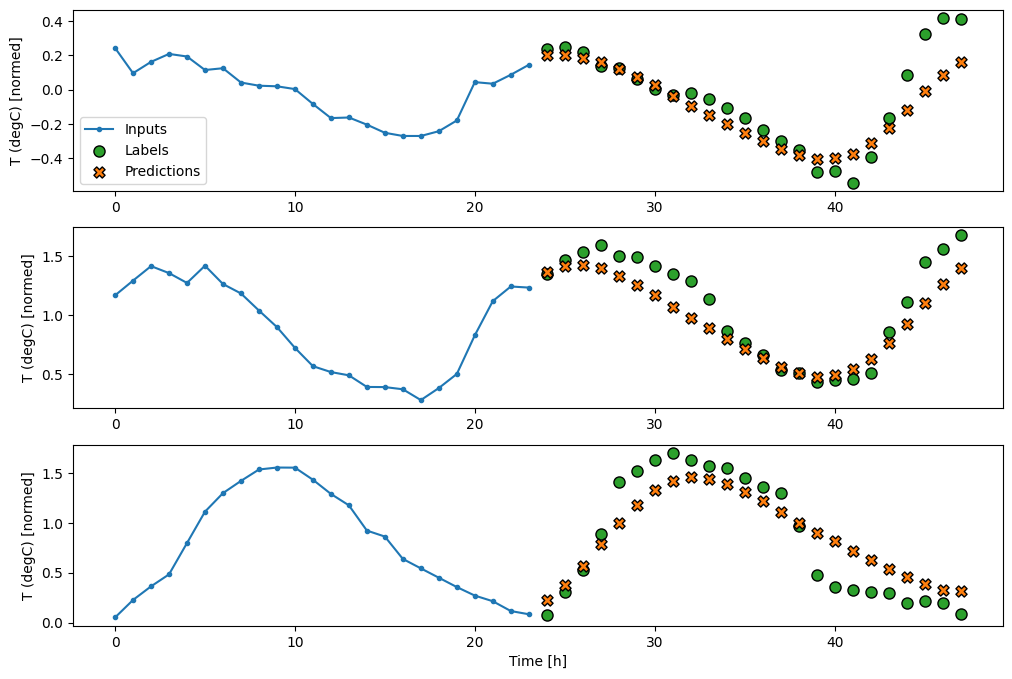

In [83]:
multi_lstm_model = tf.keras.Sequential([
    # Shape [batch, time, features] => [batch, lstm_units].
    # Adding more `lstm_units` just overfits more quickly.
    tf.keras.layers.LSTM(32, return_sequences=False),
    # Shape => [batch, out_steps*features].
    tf.keras.layers.Dense(OUT_STEPS*num_features,
                          kernel_initializer=tf.initializers.zeros()),
    # Shape => [batch, out_steps, features].
    tf.keras.layers.Reshape([OUT_STEPS, num_features])
])

history = compile_and_fit(multi_lstm_model, multi_window)

IPython.display.clear_output()

multi_val_performance['LSTM'] = multi_lstm_model.evaluate(multi_window.val)
multi_performance['LSTM'] = multi_lstm_model.evaluate(multi_window.test, verbose=0)
multi_window.plot(multi_lstm_model)

### Advanced: Autoregressive model

The above models all predict the entire output sequence in a single step.

In some cases it may be helpful for the model to decompose this prediction into individual time steps. Then, each model's output can be fed back into itself at each step and predictions can be made conditioned on the previous one, like in the classic <a href="https://arxiv.org/abs/1308.0850" class="external">Generating Sequences With Recurrent Neural Networks</a>.

One clear advantage to this style of model is that it can be set up to produce output with a varying length.

You could take any of the single-step multi-output models trained in the first half of this tutorial and run in an autoregressive feedback loop, but here you'll focus on building a model that's been explicitly trained to do that.

![Feedback a model's output to its input](images/multistep_autoregressive.png)

#### RNN

This tutorial only builds an autoregressive RNN model, but this pattern could be applied to any model that was designed to output a single time step.

The model will have the same basic form as the single-step LSTM models from earlier: a `tf.keras.layers.LSTM` layer followed by a `tf.keras.layers.Dense` layer that converts the `LSTM` layer's outputs to model predictions.

A `tf.keras.layers.LSTM` is a `tf.keras.layers.LSTMCell` wrapped in the higher level `tf.keras.layers.RNN` that manages the state and sequence results for you (Check out the [Recurrent Neural Networks (RNN) with Keras](https://www.tensorflow.org/guide/keras/rnn) guide for details).

In this case, the model has to manually manage the inputs for each step, so it uses `tf.keras.layers.LSTMCell` directly for the lower level, single time step interface.

In [84]:
class FeedBack(tf.keras.Model):
  def __init__(self, units, out_steps):
    super().__init__()
    self.out_steps = out_steps
    self.units = units
    self.lstm_cell = tf.keras.layers.LSTMCell(units)
    # Also wrap the LSTMCell in an RNN to simplify the `warmup` method.
    self.lstm_rnn = tf.keras.layers.RNN(self.lstm_cell, return_state=True)
    self.dense = tf.keras.layers.Dense(num_features)

In [85]:
feedback_model = FeedBack(units=32, out_steps=OUT_STEPS)

The first method this model needs is a `warmup` method to initialize its internal state based on the inputs. Once trained, this state will capture the relevant parts of the input history. This is equivalent to the single-step `LSTM` model from earlier:

In [86]:
def warmup(self, inputs):
  # inputs.shape => (batch, time, features)
  # x.shape => (batch, lstm_units)
  x, *state = self.lstm_rnn(inputs)

  # predictions.shape => (batch, features)
  prediction = self.dense(x)
  return prediction, state

FeedBack.warmup = warmup

This method returns a single time-step prediction and the internal state of the `LSTM`:

In [87]:
prediction, state = feedback_model.warmup(multi_window.example[0])
prediction.shape

TensorShape([32, 19])

With the `RNN`'s state, and an initial prediction you can now continue iterating the model feeding the predictions at each step back as the input.

The simplest approach for collecting the output predictions is to use a Python list and a `tf.stack` after the loop.

Note: Stacking a Python list like this only works with eager-execution, using `Model.compile(..., run_eagerly=True)` for training, or with a fixed length output. For a dynamic output length, you would need to use a `tf.TensorArray` instead of a Python list, and `tf.range` instead of the Python `range`.

In [88]:
def call(self, inputs, training=None):
  # Use a TensorArray to capture dynamically unrolled outputs.
  predictions = []
  # Initialize the LSTM state.
  prediction, state = self.warmup(inputs)

  # Insert the first prediction.
  predictions.append(prediction)

  # Run the rest of the prediction steps.
  for n in range(1, self.out_steps):
    # Use the last prediction as input.
    x = prediction
    # Execute one lstm step.
    x, state = self.lstm_cell(x, states=state,
                              training=training)
    # Convert the lstm output to a prediction.
    prediction = self.dense(x)
    # Add the prediction to the output.
    predictions.append(prediction)

  # predictions.shape => (time, batch, features)
  predictions = tf.stack(predictions)
  # predictions.shape => (batch, time, features)
  predictions = tf.transpose(predictions, [1, 0, 2])
  return predictions

FeedBack.call = call

Test run this model on the example inputs:

In [89]:
print('Output shape (batch, time, features): ', feedback_model(multi_window.example[0]).shape)

Output shape (batch, time, features):  (32, 24, 19)


Now, train the model:

  1/437 [..............................] - ETA: 36s - loss: 0.2431 - mean_absolute_error: 0.3142

  8/437 [..............................] - ETA: 3s - loss: 0.2476 - mean_absolute_error: 0.3089 

 15/437 [>.............................] - ETA: 3s - loss: 0.2339 - mean_absolute_error: 0.3042

 22/437 [>.............................] - ETA: 3s - loss: 0.2313 - mean_absolute_error: 0.3025

 29/437 [>.............................] - ETA: 3s - loss: 0.2295 - mean_absolute_error: 0.3008

 36/437 [=>............................] - ETA: 3s - loss: 0.2288 - mean_absolute_error: 0.3006

 43/437 [=>............................] - ETA: 3s - loss: 0.2278 - mean_absolute_error: 0.3004

 50/437 [==>...........................] - ETA: 2s - loss: 0.2272 - mean_absolute_error: 0.3004

 57/437 [==>...........................] - ETA: 2s - loss: 0.2273 - mean_absolute_error: 0.3005

 64/437 [===>..........................] - ETA: 2s - loss: 0.2286 - mean_absolute_error: 0.3014

 71/437 [===>..........................] - ETA: 2s - loss: 0.2289 - mean_absolute_error: 0.3016

 78/437 [====>.........................] - ETA: 2s - loss: 0.2284 - mean_absolute_error: 0.3019

 85/437 [====>.........................] - ETA: 2s - loss: 0.2281 - mean_absolute_error: 0.3016

 92/437 [=====>........................] - ETA: 2s - loss: 0.2276 - mean_absolute_error: 0.3010

 99/437 [=====>........................] - ETA: 2s - loss: 0.2270 - mean_absolute_error: 0.3006

106/437 [======>.......................] - ETA: 2s - loss: 0.2268 - mean_absolute_error: 0.3007

113/437 [======>.......................] - ETA: 2s - loss: 0.2264 - mean_absolute_error: 0.3004

120/437 [=======>......................] - ETA: 2s - loss: 0.2265 - mean_absolute_error: 0.3006

127/437 [=======>......................] - ETA: 2s - loss: 0.2271 - mean_absolute_error: 0.3007

134/437 [========>.....................] - ETA: 2s - loss: 0.2287 - mean_absolute_error: 0.3015

141/437 [========>.....................] - ETA: 2s - loss: 0.2283 - mean_absolute_error: 0.3015

148/437 [=========>....................] - ETA: 2s - loss: 0.2284 - mean_absolute_error: 0.3015

155/437 [=========>....................] - ETA: 2s - loss: 0.2288 - mean_absolute_error: 0.3017

162/437 [==========>...................] - ETA: 2s - loss: 0.2283 - mean_absolute_error: 0.3013

169/437 [==========>...................] - ETA: 2s - loss: 0.2278 - mean_absolute_error: 0.3011

176/437 [===========>..................] - ETA: 2s - loss: 0.2284 - mean_absolute_error: 0.3013

183/437 [===========>..................] - ETA: 1s - loss: 0.2282 - mean_absolute_error: 0.3014

190/437 [============>.................] - ETA: 1s - loss: 0.2281 - mean_absolute_error: 0.3013

197/437 [============>.................] - ETA: 1s - loss: 0.2284 - mean_absolute_error: 0.3015

204/437 [=============>................] - ETA: 1s - loss: 0.2284 - mean_absolute_error: 0.3015

211/437 [=============>................] - ETA: 1s - loss: 0.2278 - mean_absolute_error: 0.3012

218/437 [=============>................] - ETA: 1s - loss: 0.2281 - mean_absolute_error: 0.3014

225/437 [==============>...............] - ETA: 1s - loss: 0.2282 - mean_absolute_error: 0.3015

232/437 [==============>...............] - ETA: 1s - loss: 0.2282 - mean_absolute_error: 0.3013

239/437 [===============>..............] - ETA: 1s - loss: 0.2281 - mean_absolute_error: 0.3012

246/437 [===============>..............] - ETA: 1s - loss: 0.2282 - mean_absolute_error: 0.3013

253/437 [================>.............] - ETA: 1s - loss: 0.2283 - mean_absolute_error: 0.3015

260/437 [================>.............] - ETA: 1s - loss: 0.2282 - mean_absolute_error: 0.3017

267/437 [=================>............] - ETA: 1s - loss: 0.2284 - mean_absolute_error: 0.3018

274/437 [=================>............] - ETA: 1s - loss: 0.2289 - mean_absolute_error: 0.3020

281/437 [==================>...........] - ETA: 1s - loss: 0.2289 - mean_absolute_error: 0.3022

288/437 [==================>...........] - ETA: 1s - loss: 0.2288 - mean_absolute_error: 0.3023

295/437 [===================>..........] - ETA: 1s - loss: 0.2286 - mean_absolute_error: 0.3021

302/437 [===================>..........] - ETA: 1s - loss: 0.2288 - mean_absolute_error: 0.3023

309/437 [====================>.........] - ETA: 0s - loss: 0.2284 - mean_absolute_error: 0.3020

316/437 [====================>.........] - ETA: 0s - loss: 0.2285 - mean_absolute_error: 0.3022

323/437 [=====================>........] - ETA: 0s - loss: 0.2287 - mean_absolute_error: 0.3022

330/437 [=====================>........] - ETA: 0s - loss: 0.2287 - mean_absolute_error: 0.3022

337/437 [======================>.......] - ETA: 0s - loss: 0.2288 - mean_absolute_error: 0.3021

345/437 [======================>.......] - ETA: 0s - loss: 0.2289 - mean_absolute_error: 0.3021

352/437 [=======================>......] - ETA: 0s - loss: 0.2289 - mean_absolute_error: 0.3022

359/437 [=======================>......] - ETA: 0s - loss: 0.2288 - mean_absolute_error: 0.3022

366/437 [========================>.....] - ETA: 0s - loss: 0.2288 - mean_absolute_error: 0.3022

373/437 [========================>.....] - ETA: 0s - loss: 0.2285 - mean_absolute_error: 0.3021

380/437 [=========================>....] - ETA: 0s - loss: 0.2284 - mean_absolute_error: 0.3021

387/437 [=========================>....] - ETA: 0s - loss: 0.2281 - mean_absolute_error: 0.3019

394/437 [==========================>...] - ETA: 0s - loss: 0.2283 - mean_absolute_error: 0.3020

401/437 [==========================>...] - ETA: 0s - loss: 0.2284 - mean_absolute_error: 0.3021

408/437 [===========================>..] - ETA: 0s - loss: 0.2286 - mean_absolute_error: 0.3022

415/437 [===========================>..] - ETA: 0s - loss: 0.2284 - mean_absolute_error: 0.3021

422/437 [===========================>..] - ETA: 0s - loss: 0.2282 - mean_absolute_error: 0.3019

429/437 [============================>.] - ETA: 0s - loss: 0.2281 - mean_absolute_error: 0.3020

436/437 [============================>.] - ETA: 0s - loss: 0.2280 - mean_absolute_error: 0.3019

437/437 [==============================] - 3s 8ms/step - loss: 0.2280 - mean_absolute_error: 0.3019


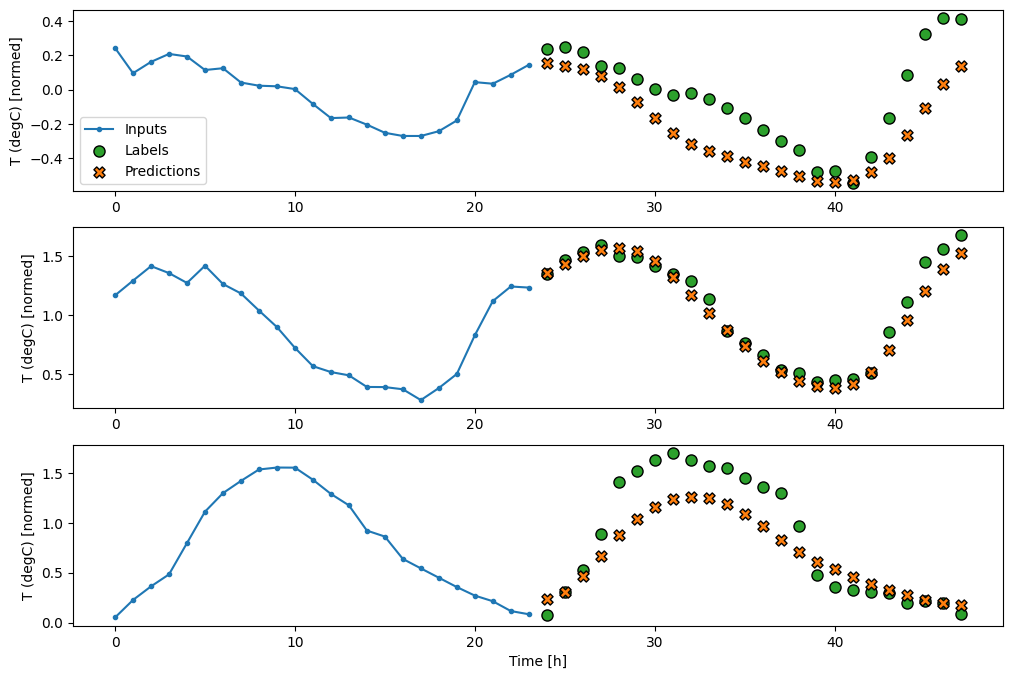

In [90]:
history = compile_and_fit(feedback_model, multi_window)

IPython.display.clear_output()

multi_val_performance['AR LSTM'] = feedback_model.evaluate(multi_window.val)
multi_performance['AR LSTM'] = feedback_model.evaluate(multi_window.test, verbose=0)
multi_window.plot(feedback_model)

### Performance

There are clearly diminishing returns as a function of model complexity on this problem:

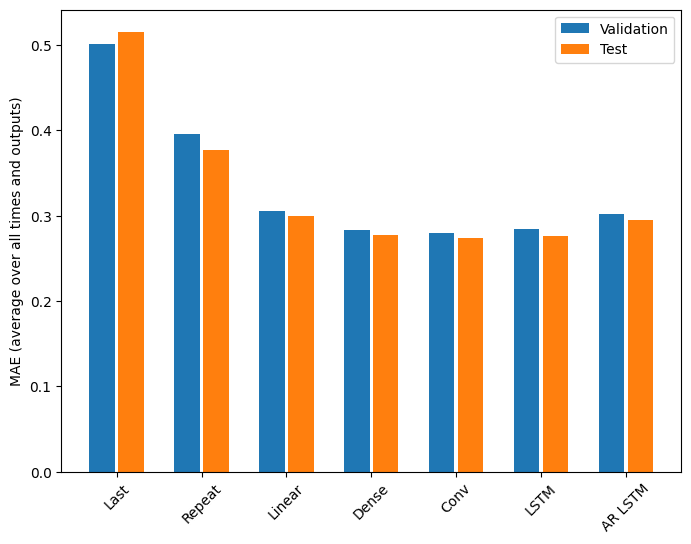

In [91]:
x = np.arange(len(multi_performance))
width = 0.3

metric_name = 'mean_absolute_error'
metric_index = lstm_model.metrics_names.index('mean_absolute_error')
val_mae = [v[metric_index] for v in multi_val_performance.values()]
test_mae = [v[metric_index] for v in multi_performance.values()]

plt.bar(x - 0.17, val_mae, width, label='Validation')
plt.bar(x + 0.17, test_mae, width, label='Test')
plt.xticks(ticks=x, labels=multi_performance.keys(),
           rotation=45)
plt.ylabel(f'MAE (average over all times and outputs)')
_ = plt.legend()

The metrics for the multi-output models in the first half of this tutorial show the performance averaged across all output features. These performances are similar but also averaged across output time steps. 

In [92]:
for name, value in multi_performance.items():
  print(f'{name:8s}: {value[1]:0.4f}')

Last    : 0.5157
Repeat  : 0.3774
Linear  : 0.2990
Dense   : 0.2776
Conv    : 0.2739
LSTM    : 0.2763
AR LSTM : 0.2944


The gains achieved going from a dense model to convolutional and recurrent models are only a few percent (if any), and the autoregressive model performed clearly worse. So these more complex approaches may not be worth while on **this** problem, but there was no way to know without trying, and these models could be helpful for **your** problem.

## Next steps

This tutorial was a quick introduction to time series forecasting using TensorFlow.

To learn more, refer to:

- Chapter 15 of <a href="https://www.oreilly.com/library/view/hands-on-machine-learning/9781492032632/" class="external">Hands-on Machine Learning with Scikit-Learn, Keras, and TensorFlow</a>, 2nd Edition.
- Chapter 6 of <a href="https://www.manning.com/books/deep-learning-with-python" class="external">Deep Learning with Python</a>.
- Lesson 8 of <a href="https://www.udacity.com/course/intro-to-tensorflow-for-deep-learning--ud187" class="external">Udacity's intro to TensorFlow for deep learning</a>, including the <a href="https://github.com/tensorflow/examples/tree/master/courses/udacity_intro_to_tensorflow_for_deep_learning" class="external">exercise notebooks</a>.

Also, remember that you can implement any <a href="https://otexts.com/fpp2/index.html" class="external">classical time series model</a> in TensorFlow—this tutorial just focuses on TensorFlow's built-in functionality.
